# Changes of cell type abundancies in PBMCs reflects the cancer and treatment effect of proton therapy (all cancers)

---
This notebook summarizes an essential part of the analysis corresponding to the results presented in figure 5 of the paper for all cancer patients. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgb

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def get_ct_abundance_data(data, normalize=True):
    ct_abundance_data = {
        "id": [],
        "sample": [],
        "timepoint": [],
        "cancer": [],
        "n_pbmc": [],
    }
    all_celltypes = np.unique(data.loc[:, "celltype"])
    for idx in np.unique(data.loc[:, "id"]):
        id_data = data.loc[data.id == idx]

        sample_name = np.array(id_data.loc[:, "sample"])[0]
        timepoint = np.array(id_data.loc[:, "timepoint"])[0]
        condition = np.array(id_data.loc[:, "cancer"])[0]
        n_pbmc = len(id_data)

        ct_abundance_data["id"].append(idx)
        ct_abundance_data["sample"].append(sample_name)
        ct_abundance_data["timepoint"].append(timepoint)
        ct_abundance_data["cancer"].append(condition)
        ct_abundance_data["n_pbmc"].append(n_pbmc)

        for ct in all_celltypes:
            if ct not in ct_abundance_data:
                ct_abundance_data[ct] = []
            count = len(id_data.loc[id_data.loc[:, "celltype"] == ct])
            if normalize:
                count /= n_pbmc
            ct_abundance_data[ct].append(count)

    return pd.DataFrame(ct_abundance_data)

<IPython.core.display.Javascript object>

In [3]:
def plot_celltype_abundancies(
    data,
    celltypes,
    celltype_labels=None,
    cut=2,
    figsize=[4, 4],
    plot_type="violin",
    quantiles=None,
    test="Mann-Whitney",
):

    mg_colors = ["cornflowerblue", "lightsteelblue", "slategray"]
    gl_colors = ["orange", "gold", "darkkhaki"]
    hn_colors = ["orchid", "mediumvioletred", "darkorchid"]

    violin_all_colors = mg_colors + gl_colors + hn_colors
    bar_all_colors = []
    for i in range(3):

        bar_all_colors.append(mg_colors[i])
        bar_all_colors.append(gl_colors[i])
        bar_all_colors.append(hn_colors[i])

    for i in range(len(celltypes)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=figsize,
            marker=celltypes[i],
            label_col="cancer",
            order=["Meningioma", "Glioma", "Head & Neck"],
            box_pairs=[
                (("Meningioma", "prior"), ("Meningioma", "during")),
                (("Meningioma", "prior"), ("Meningioma", "end")),
                (("Meningioma", "during"), ("Meningioma", "end")),
                (("Glioma", "prior"), ("Glioma", "during")),
                (("Glioma", "prior"), ("Glioma", "end")),
                (("Glioma", "during"), ("Glioma", "end")),
                (("Head & Neck", "prior"), ("Head & Neck", "during")),
                (("Head & Neck", "prior"), ("Head & Neck", "end")),
                (("Head & Neck", "during"), ("Head & Neck", "end")),
            ],
            stat_annot="star",
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
            palette="gray",
            hue="timepoint",
            hue_order=["prior", "during", "end"],
            test=test,
        )
        ax.set_xlabel("Condition")
        if celltype_labels is not None:
            ax.set_ylabel(celltype_labels[i])

        handles = []
        if plot_type == "violin":
            for ind, obj in enumerate(ax.findobj(PolyCollection)):
                rgb = to_rgb(violin_all_colors[ind])
                obj.set_facecolor(rgb)
                handles.append(
                    plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor="black")
                )
        elif plot_type == "bar":
            for ind, bar in enumerate(ax.patches):
                rgb = to_rgb(bar_all_colors[ind])
                bar.set_color(rgb)
                handles_color = to_rgb(violin_all_colors[ind])
                handles.append(
                    plt.Rectangle(
                        (0, 0), 0, 0, facecolor=handles_color, edgecolor="black"
                    )
                )
        else:
            raise NotImplementedError

        ax.legend(
            handles=[
                tuple(handles[0::3]),
                tuple(handles[1::3]),
                tuple(handles[2::3]),
            ],
            labels=tp_order,
            title="Timepoint",
            handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            bbox_to_anchor=(1.02, 0.5),
            loc="center left",
            borderaxespad=0,
        )

        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [4]:
def plot_cell_type_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=2,
    plot_type="violin",
    palette=None,
    figsize=[4, 4],
    hue=None,
    hue_order=None,
    test="t-test_ind",
):
    for i in range(len(markers)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=figsize,
            marker=markers[i],
            label_col="celltype",
            order=["CD3+", "CD3-"],
            box_pairs=[
                ("CD3+", "CD3-"),
            ],
            stat_annot="star",
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
            palette=palette,
            hue=hue,
            hue_order=hue_order,
            test=test,
        )
        ax.set_xlabel("Cell type")
        ax.set_ylabel(marker_labels[i])
        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [5]:
def plot_timepoint_cancer_celltype_markers_dist(
    data,
    markers,
    marker_labels,
    celltypes,
    quantiles=None,
    cut=2,
    plot_type="violin",
    palette=None,
    figsize=[4, 4],
    hue=None,
    hue_order=None,
):
    mg_colors = ["cornflowerblue", "lightsteelblue", "slategray"]
    gl_colors = ["orange", "gold", "darkkhaki"]
    hn_colors = ["orchid", "mediumvioletred", "darkorchid"]

    violin_all_colors = mg_colors + gl_colors + hn_colors
    bar_all_colors = []
    for i in range(3):
        bar_all_colors.append(mg_colors[i])
        bar_all_colors.append(gl_colors[i])
        bar_all_colors.append(hn_colors[i])

    for i in range(len(markers)):
        fig, ax = plt.subplots(figsize=figsize, ncols=len(celltypes), sharey=True)
        ax = ax.flatten()
        for j, celltype in enumerate(celltypes):

            fig, ax[j] = plot_marker_distribution(
                data.loc[data.loc[:, "celltype"] == celltype],
                figsize=figsize,
                marker=markers[i],
                label_col="cancer",
                order=["Meningioma", "Glioma", "Head & Neck"],
                box_pairs=[
                    (("Meningioma", "prior"), ("Meningioma", "during")),
                    (("Meningioma", "prior"), ("Meningioma", "end")),
                    (("Meningioma", "during"), ("Meningioma", "end")),
                    (("Glioma", "prior"), ("Glioma", "during")),
                    (("Glioma", "prior"), ("Glioma", "end")),
                    (("Glioma", "during"), ("Glioma", "end")),
                    (("Head & Neck", "prior"), ("Head & Neck", "during")),
                    (("Head & Neck", "prior"), ("Head & Neck", "end")),
                    (("Head & Neck", "during"), ("Head & Neck", "end")),
                ],
                stat_annot="star",
                quantiles=quantiles,
                cut=cut,
                plot_type=plot_type,
                palette="gray",
                hue="timepoint",
                hue_order=["prior", "during", "end"],
                fig=fig,
                ax=ax[j],
            )
        for j in range(len(ax)):
            ax[j].set_xlabel("Cancer type")
            ax[j].set_ylabel(marker_labels[i])
            if j != len(ax) - 1:
                ax[j].legend().remove()

            handles = []
            if plot_type == "violin":
                for ind, obj in enumerate(ax[j].findobj(PolyCollection)):
                    rgb = to_rgb(violin_all_colors[ind])
                    obj.set_facecolor(rgb)
                    handles.append(
                        plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor="black")
                    )
            elif plot_type == "bar":
                for ind, bar in enumerate(ax[j].patches):
                    rgb = to_rgb(bar_all_colors[ind])
                    bar.set_color(rgb)
                    handles_color = to_rgb(violin_all_colors[ind])
                    handles.append(
                        plt.Rectangle(
                            (0, 0), 0, 0, facecolor=handles_color, edgecolor="black"
                        )
                    )
            else:
                raise NotImplementedError

        ax[-1].legend(
            handles=[tuple(handles[::3]), tuple(handles[1::3]), tuple(handles[2::3])],
            labels=tp_order,
            title="Timepoint",
            handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            bbox_to_anchor=(1.02, 0.5),
            loc="center left",
            borderaxespad=0,
        )

        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [6]:
color_palette = {
    "Meningioma": "cornflowerblue",
    "Glioma": "orange",
    "Head & Neck": "orchid",
}

<IPython.core.display.Javascript object>

In [7]:
mg_colors = ["cornflowerblue", "lightsteelblue", "slategray"]
gl_colors = ["orange", "gold", "darkkhaki"]
hn_colors = ["orchid", "mediumvioletred", "darkorchid"]

<IPython.core.display.Javascript object>

---

## 1. Read in data

In this notebook we assess the differences of the cell states of PBMCs at three different time points of the proton therapy treatment: before, during (~3 weeks in) and at the end of the treatment (final week of treatment). To this end, we obtained PBMCs of 8 Meningioma, 8 Glioma and 6 Head & Neck cancer patients stained them for DNA and CD3 (alongside gH2AX and Lamin A/C) and obtained fluorescent images.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

#### Meningioma

In [8]:
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
marker_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

In [9]:
mg_tp1_root_data_dir = "../../data/meningioma/proteins/timepoint_1"

mg_tp1_data = read_in_marker_dataset(
    data_dir=mg_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp1_data["id"] = mg_tp1_data["sample"] + mg_tp1_data["timepoint"]
mg_tp1_data["timepoint"] = "prior"
mg_tp1_data["cancer"] = "Meningioma"
mg_tp1_data["file_name"] = np.array(list(mg_tp1_data.index))

Load data: 100%|██████████| 6/6 [00:00<00:00, 24.21it/s]


<IPython.core.display.Javascript object>

In [10]:
mg_tp2_root_data_dir = "../../data/meningioma/proteins/timepoint_2"

mg_tp2_data = read_in_marker_dataset(
    data_dir=mg_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp2_data["id"] = mg_tp2_data["sample"] + mg_tp2_data["timepoint"]
mg_tp2_data["timepoint"] = "during"
mg_tp2_data["cancer"] = "Meningioma"
mg_tp2_data["file_name"] = np.array(list(mg_tp2_data.index))

Load data: 100%|██████████| 6/6 [00:00<00:00, 29.73it/s]


<IPython.core.display.Javascript object>

In [11]:
mg_tp3_root_data_dir = "../../data/meningioma/proteins/timepoint_3"

mg_tp3_data = read_in_marker_dataset(
    data_dir=mg_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp3_data["id"] = mg_tp3_data["sample"] + mg_tp3_data["timepoint"]
mg_tp3_data["timepoint"] = "end"
mg_tp3_data["cancer"] = "Meningioma"
mg_tp3_data["file_name"] = np.array(list(mg_tp3_data.index))

Load data: 100%|██████████| 6/6 [00:00<00:00, 24.20it/s]


<IPython.core.display.Javascript object>

---

#### Glioma

In [12]:
gl_tp1_root_data_dir = "../../data/glioma/proteins/timepoint_1"

gl_tp1_data = read_in_marker_dataset(
    data_dir=gl_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp1_data["id"] = gl_tp1_data["sample"] + gl_tp1_data["timepoint"]
gl_tp1_data["timepoint"] = "prior"
gl_tp1_data["cancer"] = "Glioma"
gl_tp1_data["file_name"] = np.array(list(gl_tp1_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 29.10it/s]


<IPython.core.display.Javascript object>

In [13]:
gl_tp2_root_data_dir = "../../data/glioma/proteins/timepoint_2"

gl_tp2_data = read_in_marker_dataset(
    data_dir=gl_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp2_data["id"] = gl_tp2_data["sample"] + gl_tp2_data["timepoint"]
gl_tp2_data["timepoint"] = "during"
gl_tp2_data["cancer"] = "Glioma"
gl_tp2_data["file_name"] = np.array(list(gl_tp2_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 25.65it/s]


<IPython.core.display.Javascript object>

In [14]:
gl_tp3_root_data_dir = "../../data/glioma/proteins/timepoint_3"

gl_tp3_data = read_in_marker_dataset(
    data_dir=gl_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp3_data["id"] = gl_tp3_data["sample"] + gl_tp3_data["timepoint"]
gl_tp3_data["timepoint"] = "end"
gl_tp3_data["cancer"] = "Glioma"
gl_tp3_data["file_name"] = np.array(list(gl_tp3_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 24.42it/s]


<IPython.core.display.Javascript object>

---

#### Head & Neck cancers

In [15]:
hn_tp1_root_data_dir = "../../data/headneck/proteins/timepoint_1"

hn_tp1_data = read_in_marker_dataset(
    data_dir=hn_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp1_data["id"] = hn_tp1_data["sample"] + hn_tp1_data["timepoint"]
hn_tp1_data["timepoint"] = "prior"
hn_tp1_data["cancer"] = "Head & Neck"
hn_tp1_data["file_name"] = np.array(list(hn_tp1_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 19.29it/s]


<IPython.core.display.Javascript object>

In [16]:
hn_tp2_root_data_dir = "../../data/headneck/proteins/timepoint_2"

hn_tp2_data = read_in_marker_dataset(
    data_dir=hn_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp2_data["id"] = hn_tp2_data["sample"] + hn_tp2_data["timepoint"]
hn_tp2_data["timepoint"] = "during"
hn_tp2_data["cancer"] = "Head & Neck"
hn_tp2_data["file_name"] = np.array(list(hn_tp2_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 23.89it/s]


<IPython.core.display.Javascript object>

In [17]:
hn_tp3_root_data_dir = "../../data/headneck/proteins/timepoint_3"

hn_tp3_data = read_in_marker_dataset(
    data_dir=hn_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp3_data["id"] = hn_tp3_data["sample"] + hn_tp3_data["timepoint"]
hn_tp3_data["timepoint"] = "end"
hn_tp3_data["cancer"] = "Head & Neck"
hn_tp3_data["file_name"] = np.array(list(hn_tp3_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 31.20it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [18]:
mg_tp1_data = preprocess_data(mg_tp1_data, remove_constant_features=False)
mg_tp2_data = preprocess_data(mg_tp2_data, remove_constant_features=False)
mg_tp3_data = preprocess_data(mg_tp3_data, remove_constant_features=False)

gl_tp1_data = preprocess_data(gl_tp1_data, remove_constant_features=False)
gl_tp2_data = preprocess_data(gl_tp2_data, remove_constant_features=False)
gl_tp3_data = preprocess_data(gl_tp3_data, remove_constant_features=False)

hn_tp1_data = preprocess_data(hn_tp1_data, remove_constant_features=False)
hn_tp2_data = preprocess_data(hn_tp2_data, remove_constant_features=False)
hn_tp3_data = preprocess_data(hn_tp3_data, remove_constant_features=False)

all_data = (
    mg_tp1_data.append(gl_tp1_data)
    .append(hn_tp1_data)
    .append(mg_tp2_data)
    .append(gl_tp2_data)
    .append(hn_tp2_data)
    .append(mg_tp3_data)
    .append(gl_tp3_data)
    .append(hn_tp3_data)
)

Nuclei that did not pass the quality check: 179/2650. Remaining: 2471.
Removed 32 constant or features with missing values. Remaining: 272.
Removed additional 6 features. Remaining: 266.
Nuclei that did not pass the quality check: 142/2814. Remaining: 2672.
Removed 29 constant or features with missing values. Remaining: 275.
Removed additional 6 features. Remaining: 269.
Nuclei that did not pass the quality check: 96/3106. Remaining: 3010.
Removed 32 constant or features with missing values. Remaining: 272.
Removed additional 6 features. Remaining: 266.
Nuclei that did not pass the quality check: 113/3204. Remaining: 3091.
Removed 12 constant or features with missing values. Remaining: 292.
Removed additional 6 features. Remaining: 286.
Nuclei that did not pass the quality check: 283/4394. Remaining: 4111.
Removed 9 constant or features with missing values. Remaining: 295.
Removed additional 6 features. Remaining: 289.
Nuclei that did not pass the quality check: 422/4336. Remaining: 39

<IPython.core.display.Javascript object>

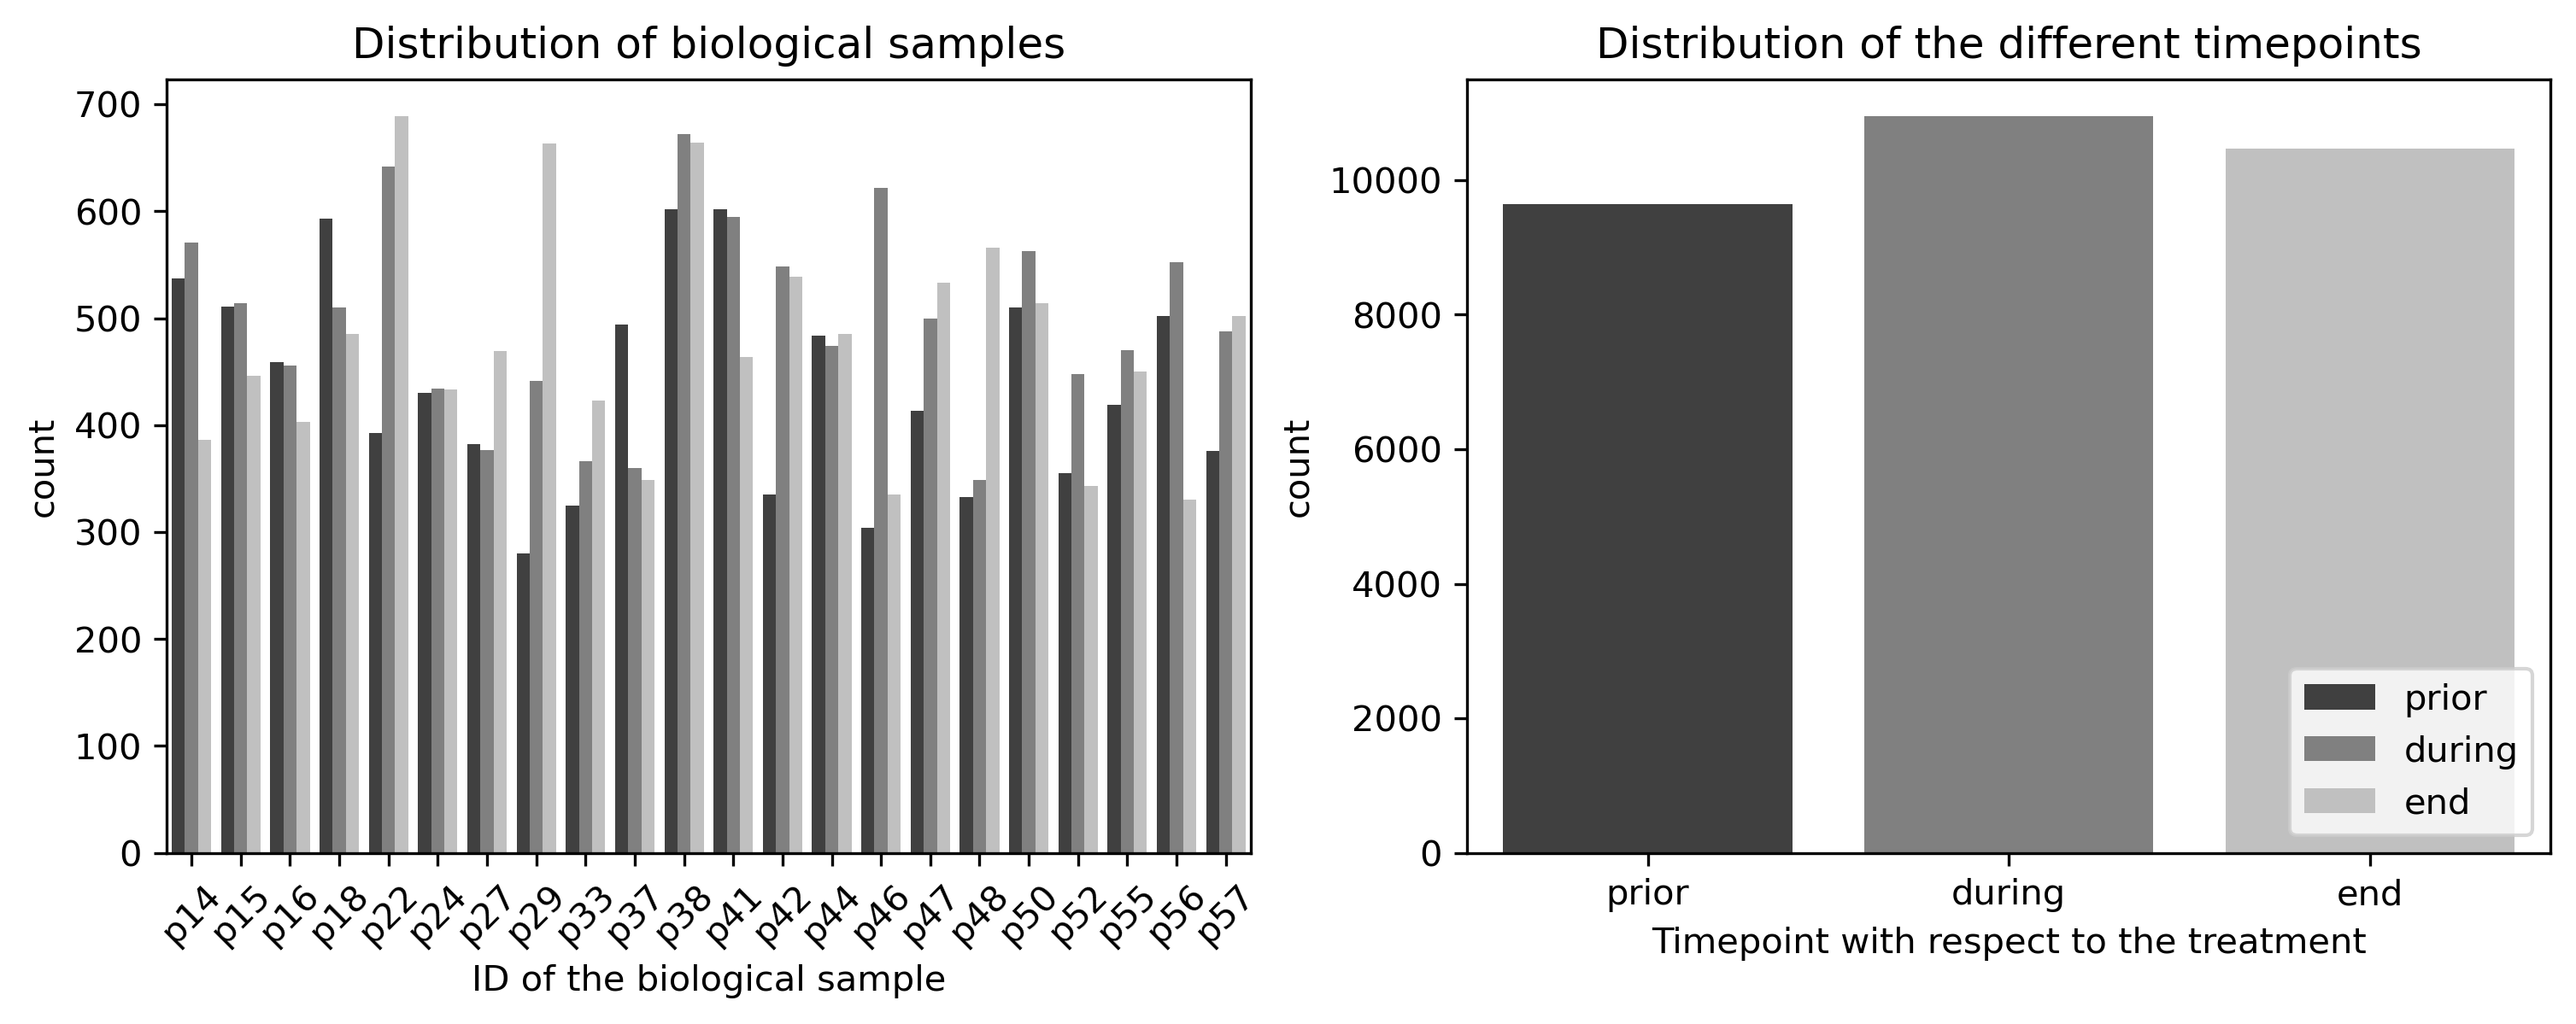

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette="gray",
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=all_data,
    ax=ax[1],
    order=tp_order,
    dodge=False,
    palette="gray",
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

---

#### Add cell type identities

In [20]:
celltype_cols = ["cd3"]
coding_dict = {0: "-", 1: "+"}
for celltype_col in celltype_cols:
    all_data.loc[:, celltype_col] = all_data.loc[:, celltype_col].map(coding_dict)

all_data["celltype"] = "CD3" + all_data["cd3"]
celltypes = np.unique(all_data.loc[:, "celltype"].dropna())

<IPython.core.display.Javascript object>

In [21]:
ct_abundance_data = get_ct_abundance_data(all_data, normalize=True)

<IPython.core.display.Javascript object>

Let us quickly look at the distribution of the cell types across samples, cancer types and treatment timepoints.

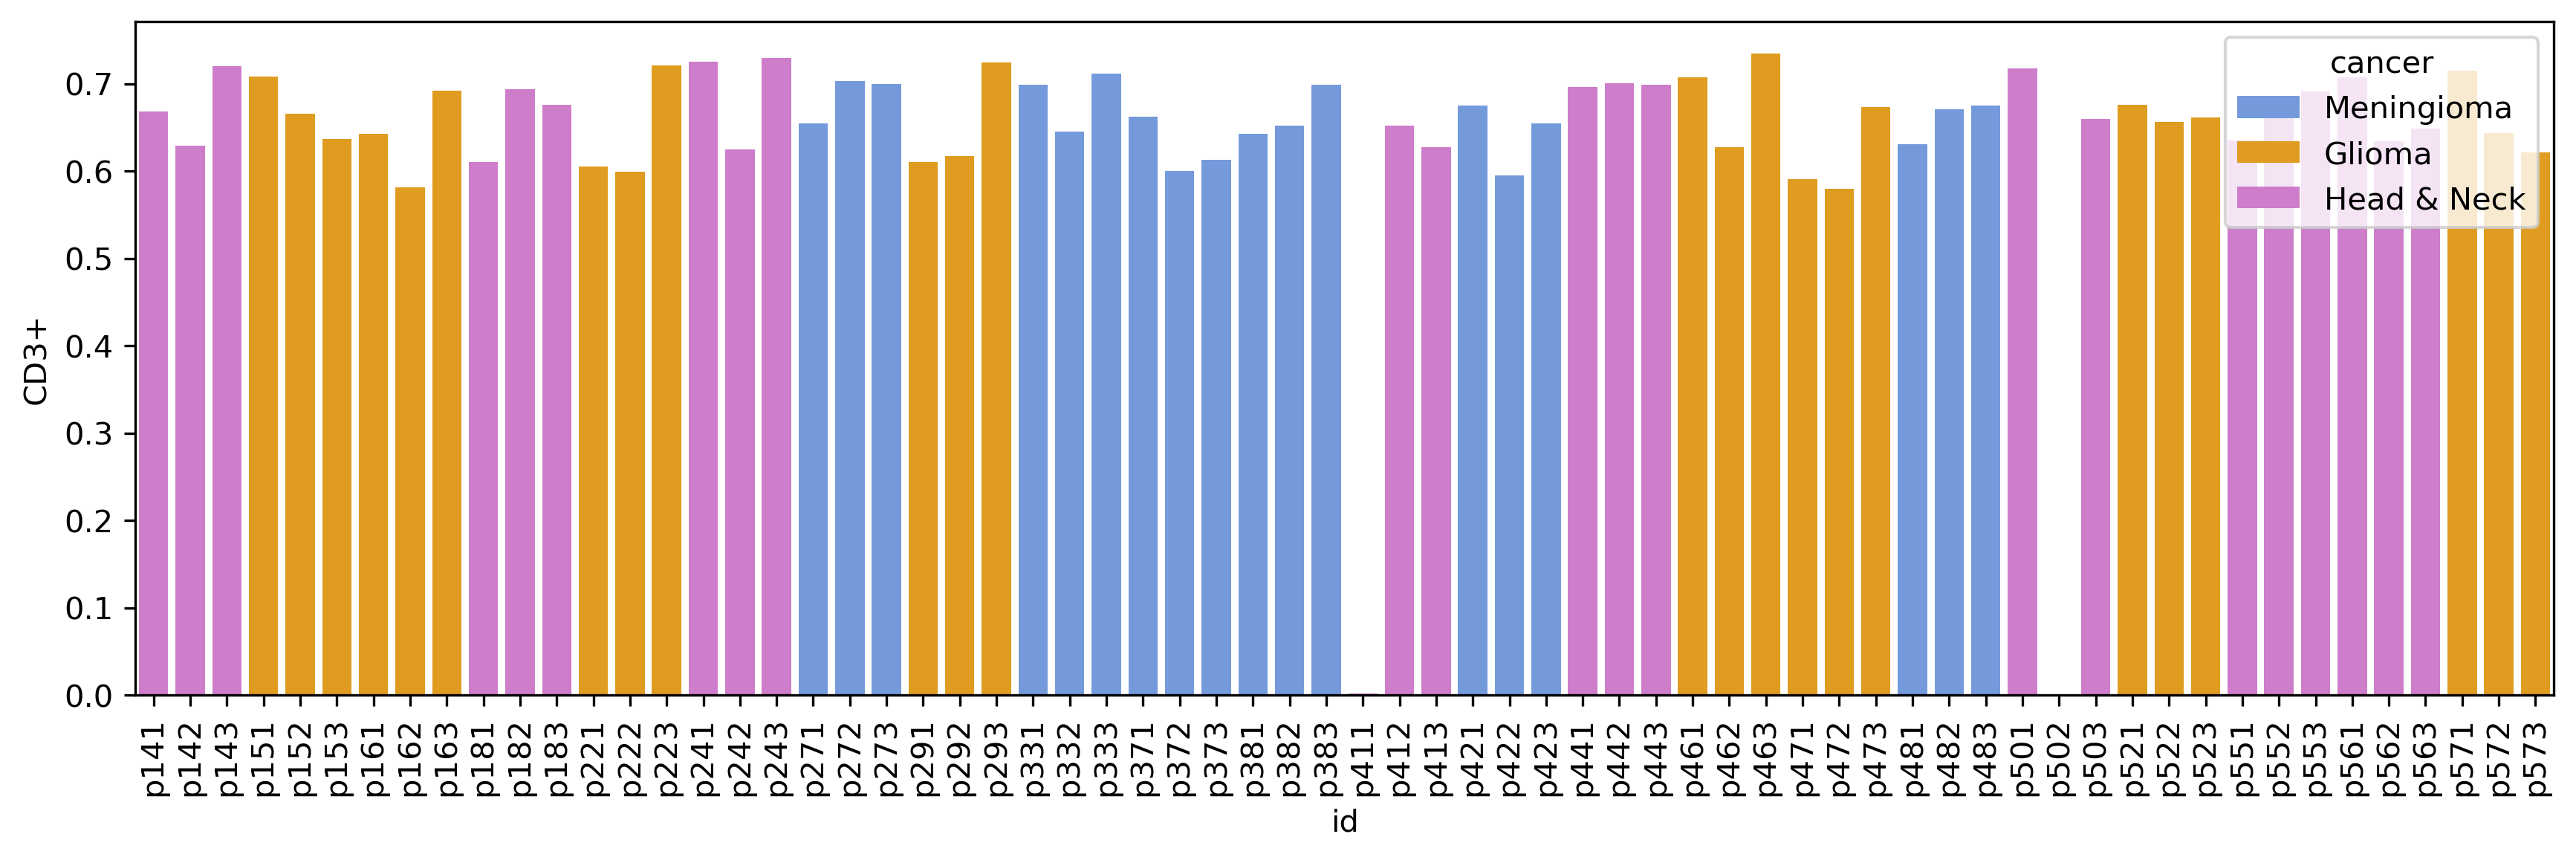

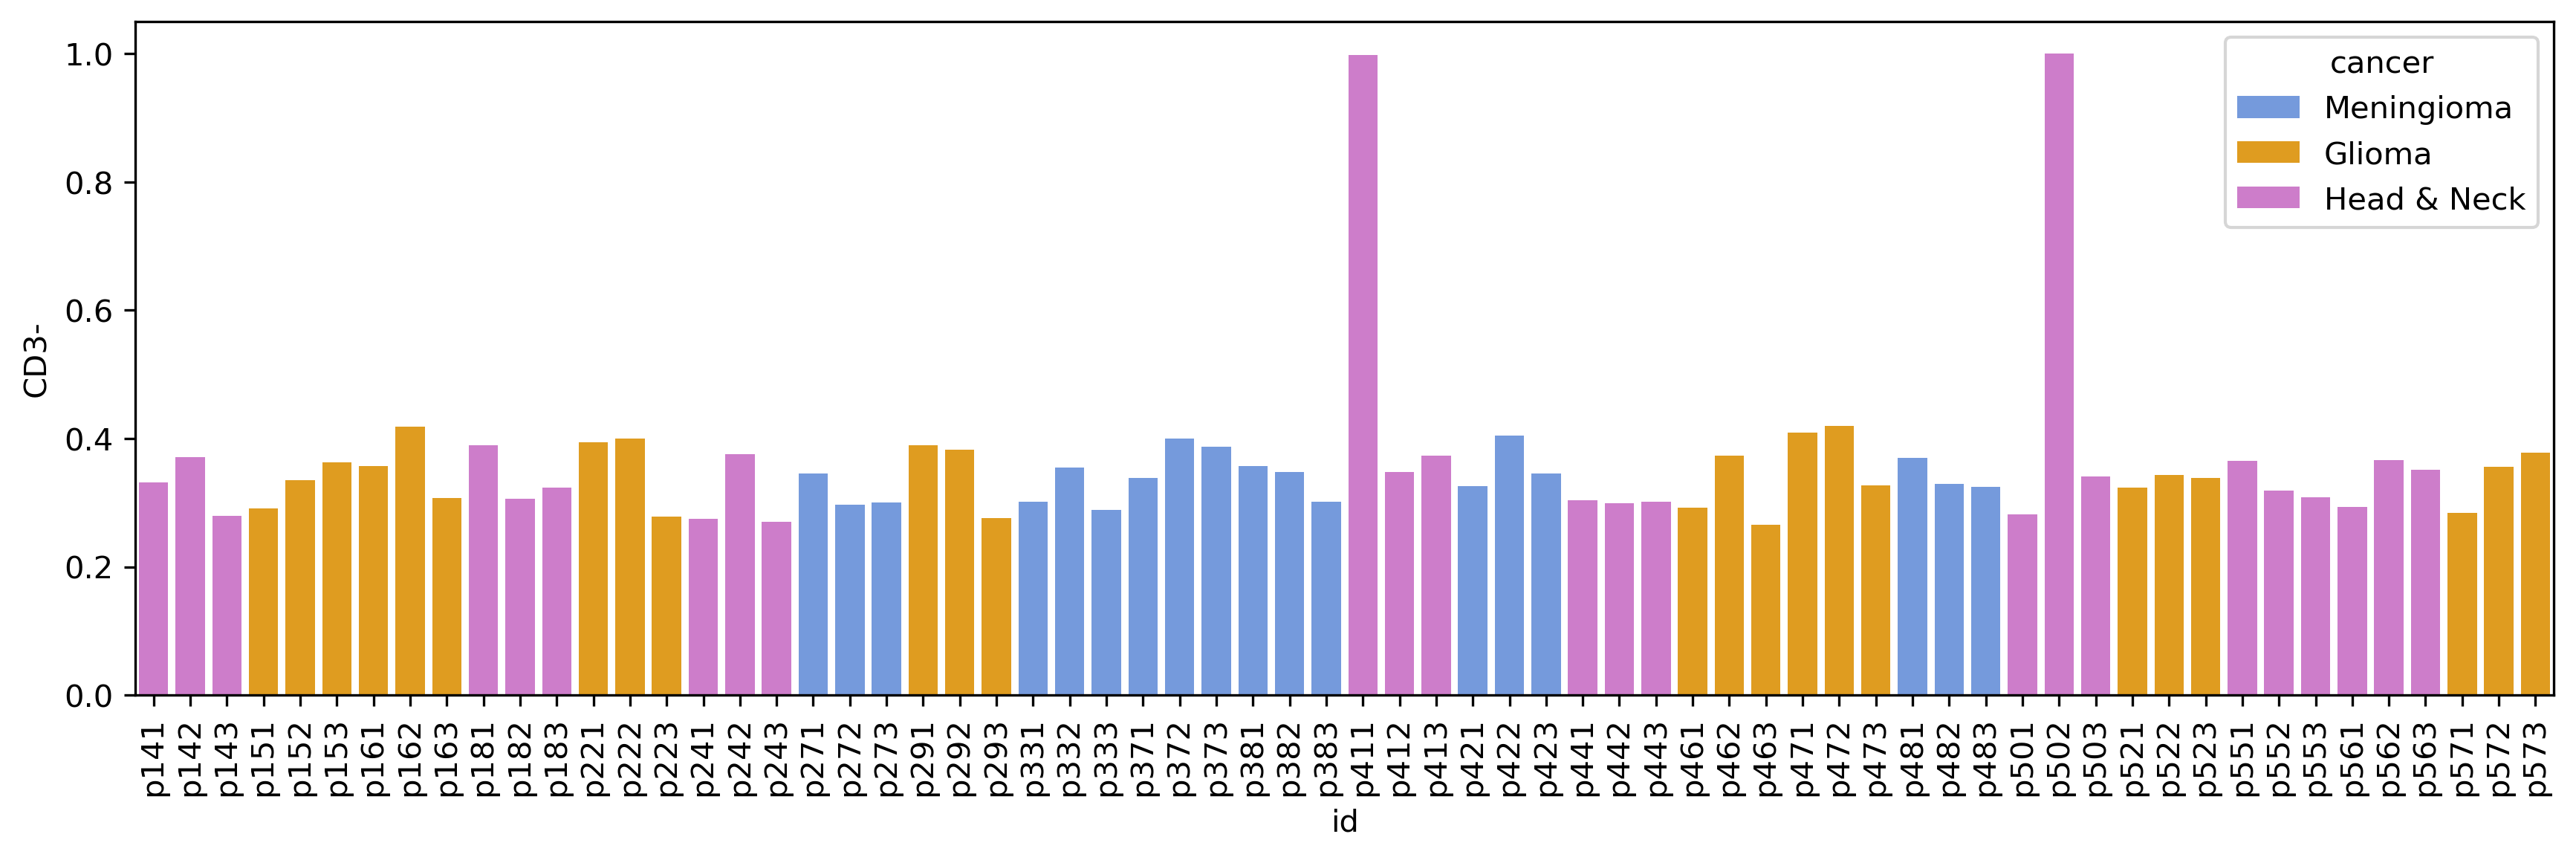

<IPython.core.display.Javascript object>

In [22]:
for celltype in celltypes:
    fig, ax = plt.subplots(figsize=[14, 4])
    ax = sns.barplot(
        data=ct_abundance_data,
        x="id",
        y=celltype,
        ax=ax,
        hue="cancer",
        hue_order=list(color_palette.keys()),
        palette=color_palette,
        dodge=False,
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

#### Subsampling

We next subsample the data set such that for each timepoint we have the same number of nuclei in the data set. Additionally, we ensure that the individual timepoint population are approximately uniformly represented by the different biological (patient) samples.

In [23]:
sampled_data = get_stratified_data(
    all_data, id_column="id", cond_column="timepoint", seed=1234
)

<IPython.core.display.Javascript object>

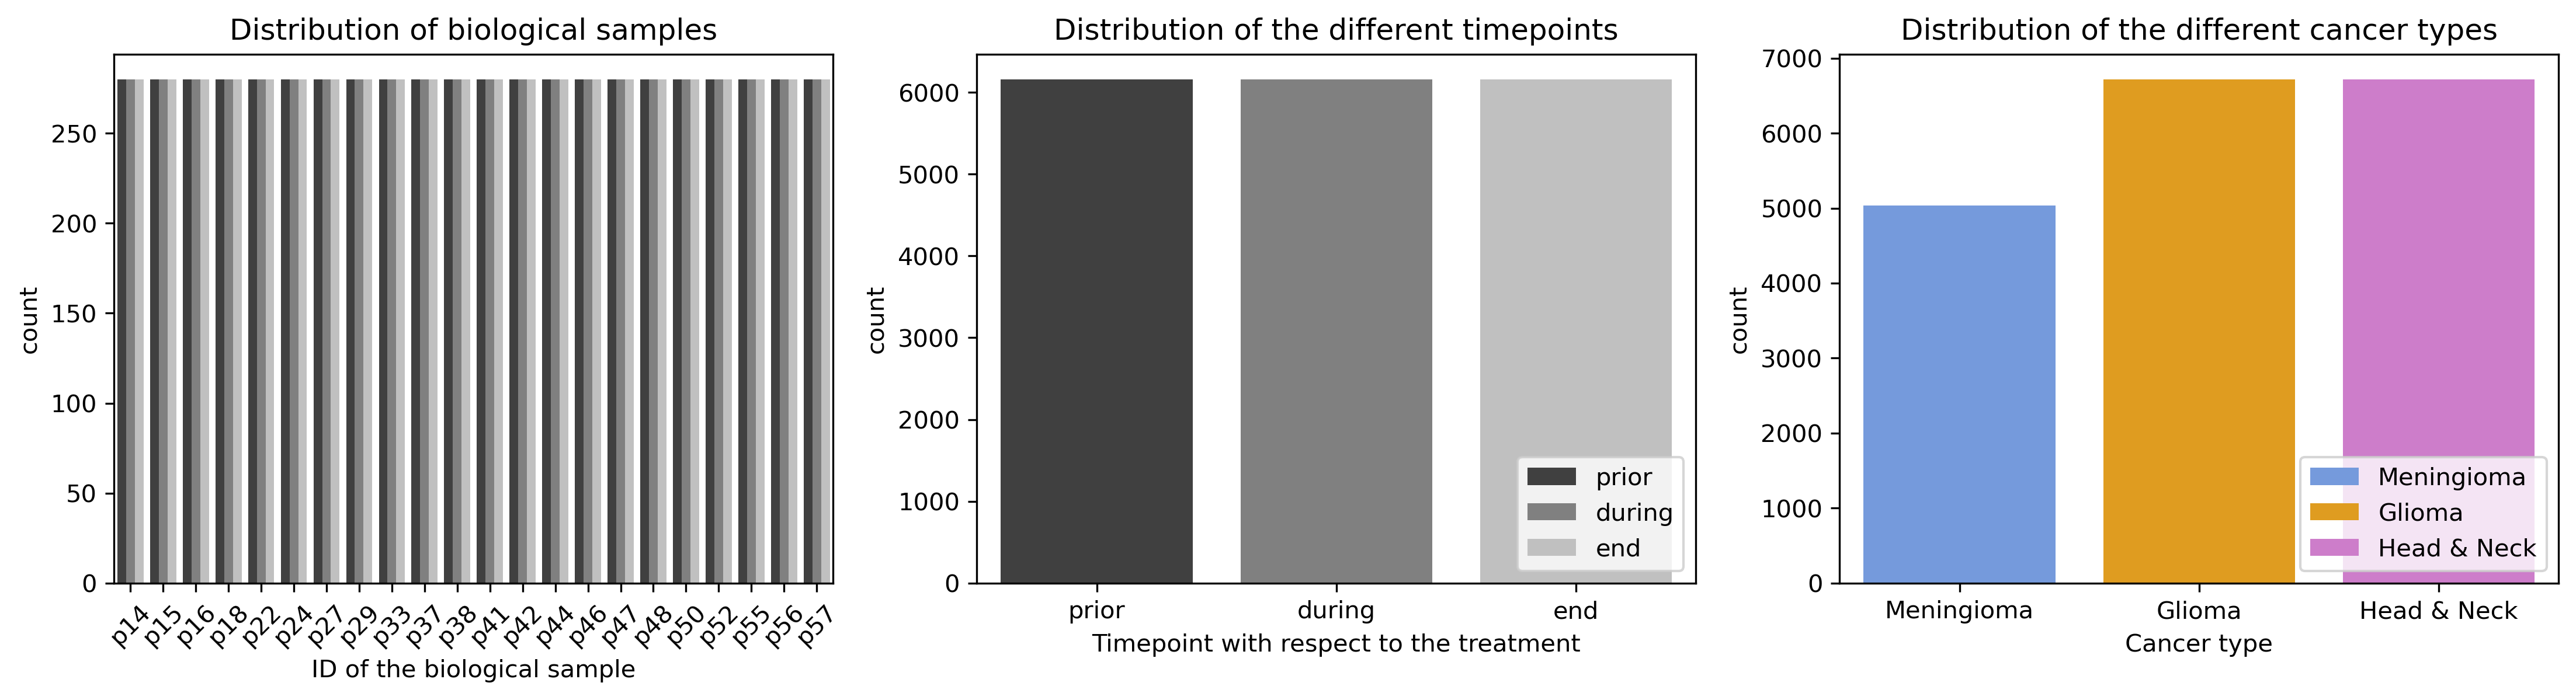

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(figsize=[18, 4], ncols=3)
tp_order = ["prior", "during", "end"]
cancer_order = ["Meningioma", "Glioma", "Head & Neck"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette="gray",
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=sampled_data,
    ax=ax[1],
    order=tp_order,
    hue_order=tp_order,
    dodge=False,
    palette="gray",
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

ax[2] = sns.countplot(
    x="cancer",
    hue="cancer",
    data=sampled_data,
    ax=ax[2],
    order=cancer_order,
    hue_order=cancer_order,
    dodge=False,
    palette=color_palette,
)
ax[2].set_xlabel("Cancer type")
ax[2].set_title("Distribution of the different cancer types")
ax[2].legend(loc="lower right")

plt.show()
plt.close()

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features.

In [25]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/18480. Remaining: 18480.
Removed 27 constant or features with missing values. Remaining: 263.
Removed additional 0 features. Remaining: 263.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [26]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin", "cd3"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]
cancer_labels = data.loc[:, "cancer"]
ct_labels = data.loc[:, "celltype"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [27]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 134/193 features with a Pearson correlation above 0.8. Remaining: 59


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 4 of the paper.

---

### 3.a. T cell abundancies changes during the treatment

At first we look at the relative frequencies of CD3+/- PBMCs in our samples at the different treatment timepoints.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.359e-02 (ns) U_stat=8.000e+00
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.184e-01 U_stat=4.200e+01
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.893e-01 U_stat=1.900e+01
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.752e-01 U_stat=2.200e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.735e-01 U_stat=9.000e+00
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg c

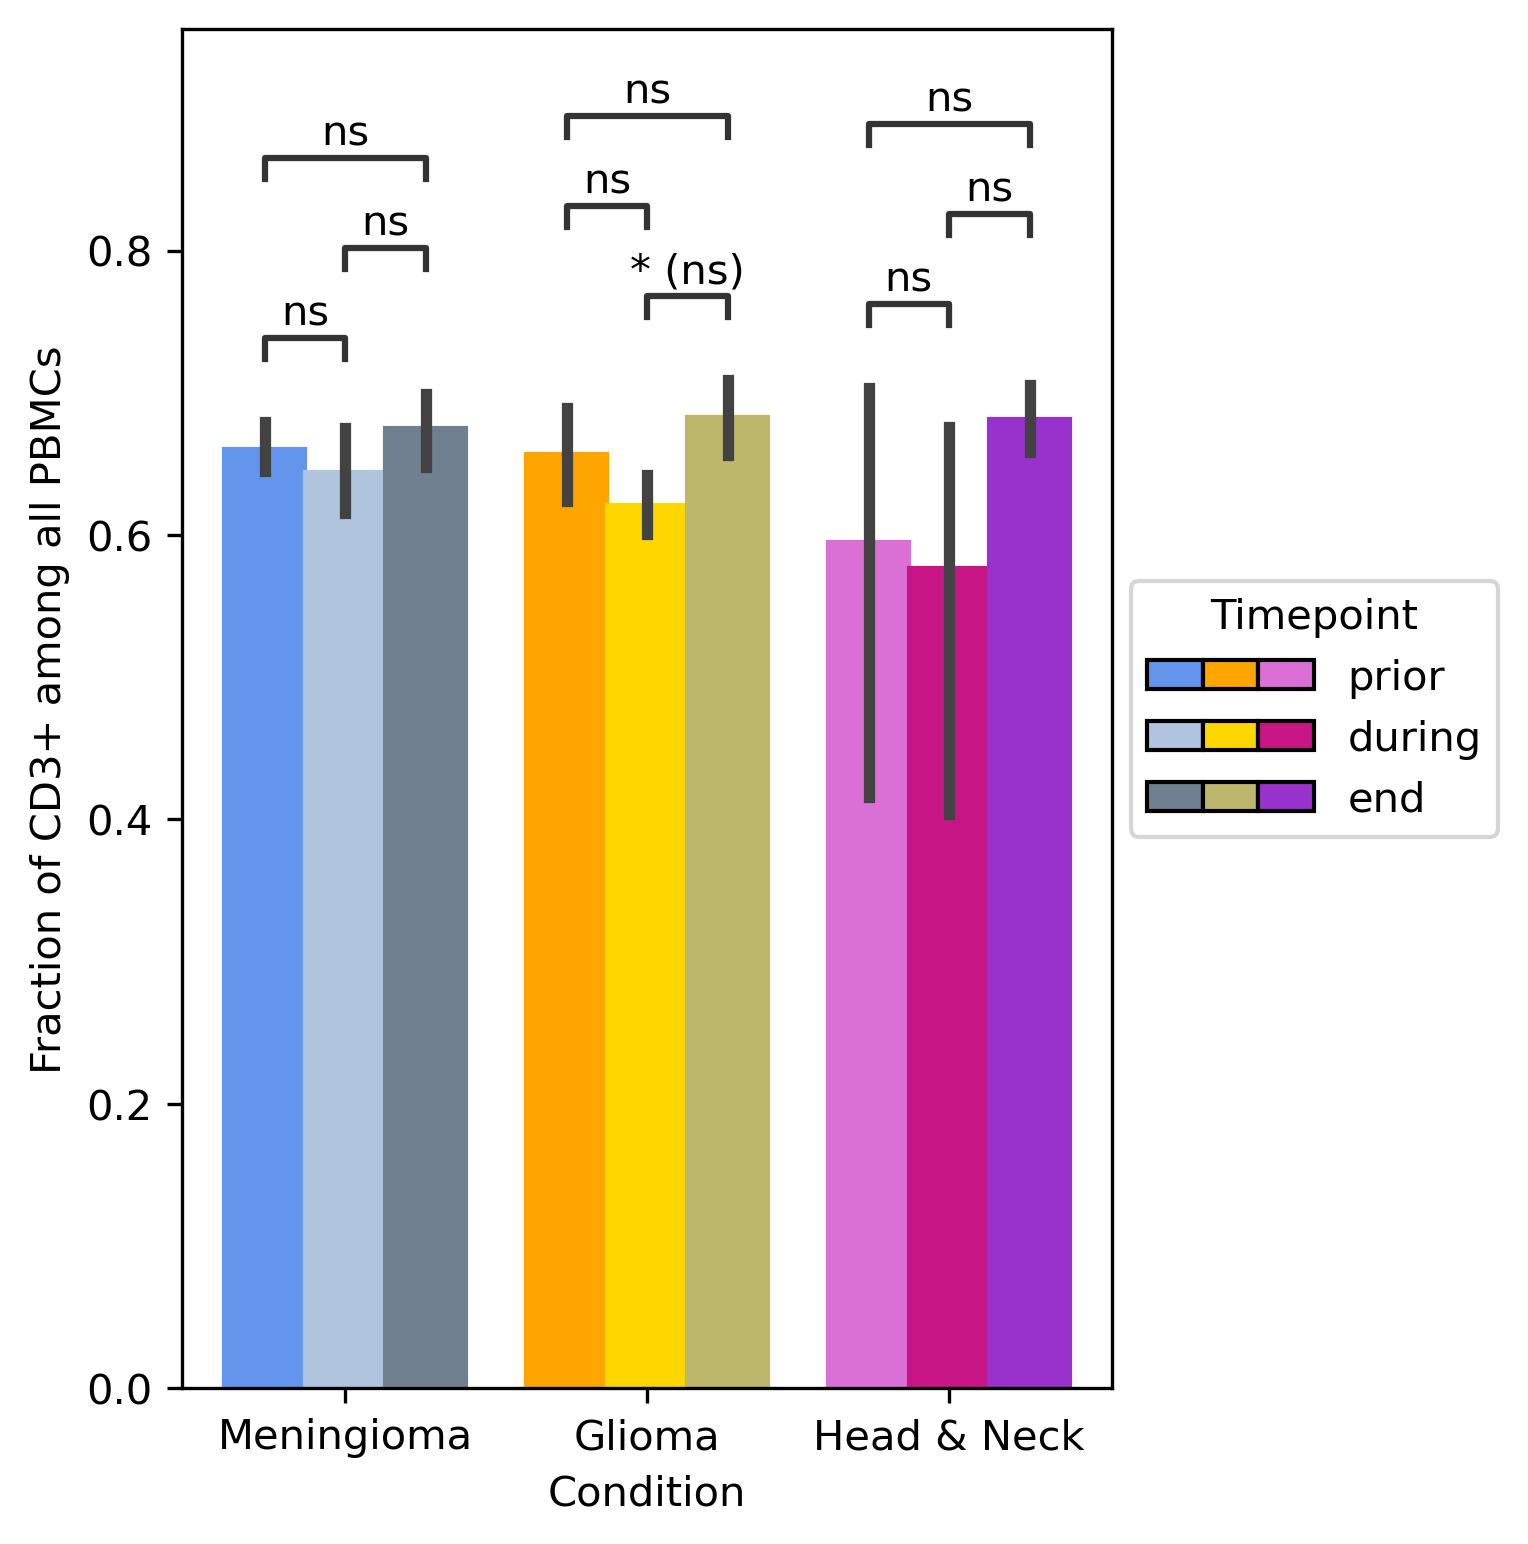

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.359e-02 (ns) U_stat=5.600e+01
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.184e-01 U_stat=2.200e+01
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.893e-01 U_stat=4.500e+01
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.752e-01 U_stat=1.400e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.735e-01 U_stat=2.700e+01
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg c

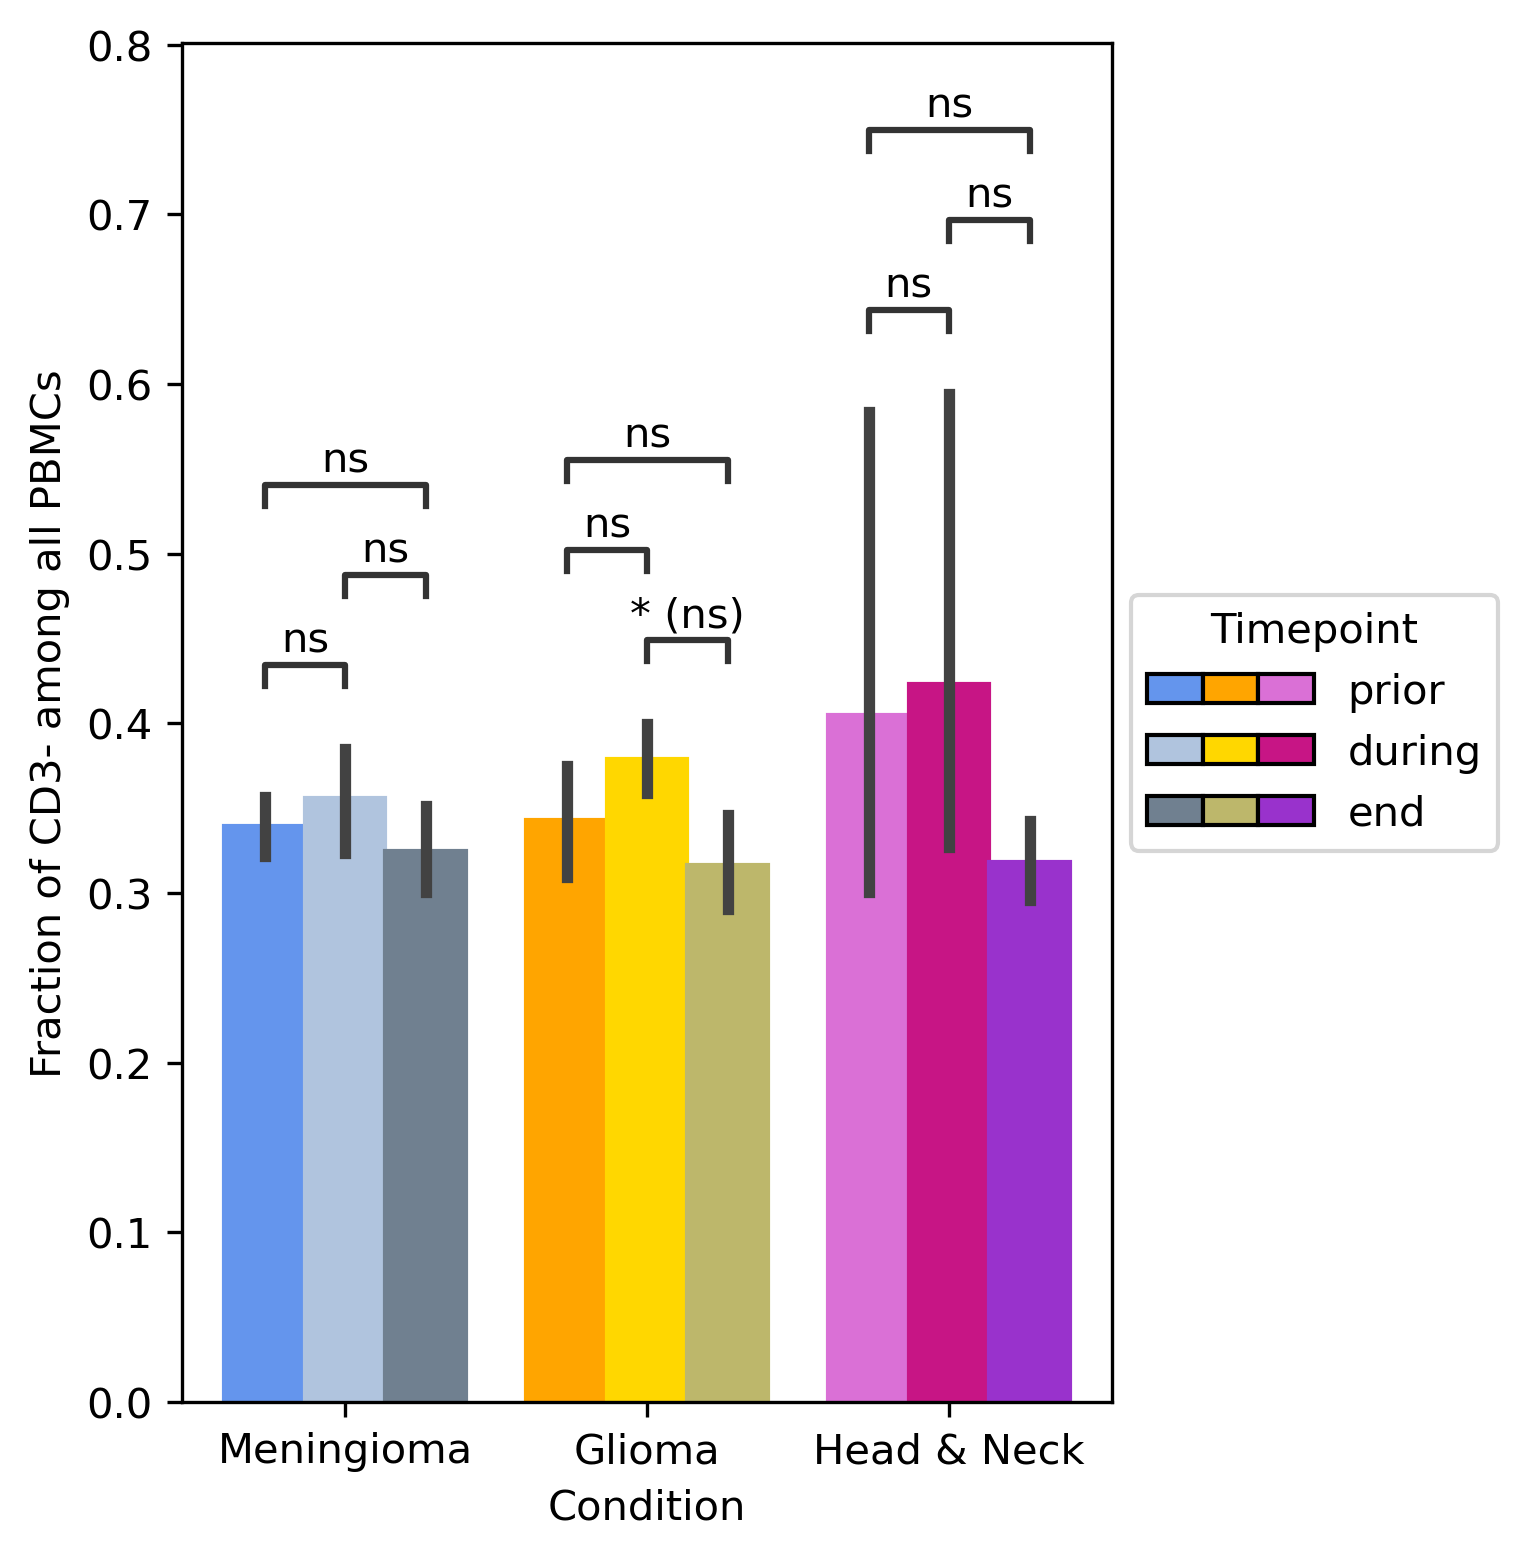

<IPython.core.display.Javascript object>

In [28]:
celltype_labels = []
for celltype in celltypes:
    celltype_labels.append("Fraction of {} among all PBMCs".format(celltype))

plot_celltype_abundancies(
    ct_abundance_data,
    celltypes=celltypes,
    celltype_labels=celltype_labels,
    figsize=[4, 6],
    plot_type="bar",
)

The above plot indicates that there are no significant differences between abundancies of CD3+ T cells between cancer types and/or the different treatment time points. 

___

### 3.b. Chrometric differences between CD3+/- PBMCs

We will now check whether or not there are significant differences between the previously identified chromatin biomarkers that capture the treatment effects between CD3+ positive and CD3- negative PBMCs.

#### Classification

To this end, we will first assess how well a RandomForest classifier can distinguish between the CD3+/- PBMCs based on the chrometric features. We first obtain a random balanced subset of CD3+ and CD3- PBMCs and then evaluate the class separability using a 10-fold stratfied cross-validation approach.

In [29]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

sampled_ct_data, sampled_ct_labels = RandomUnderSampler(random_state=seed).fit_resample(
    chrometric_data, ct_labels
)

<IPython.core.display.Javascript object>

In [30]:
ct_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=sampled_ct_data,
    labels=sampled_ct_labels,
    scale_features=False,
    n_folds=10,
    order=["CD3+", "CD3-"],
)
normalized_ct_cv_conf_mtx_nuclei = ct_cv_conf_mtx_nuclei.divide(
    ct_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

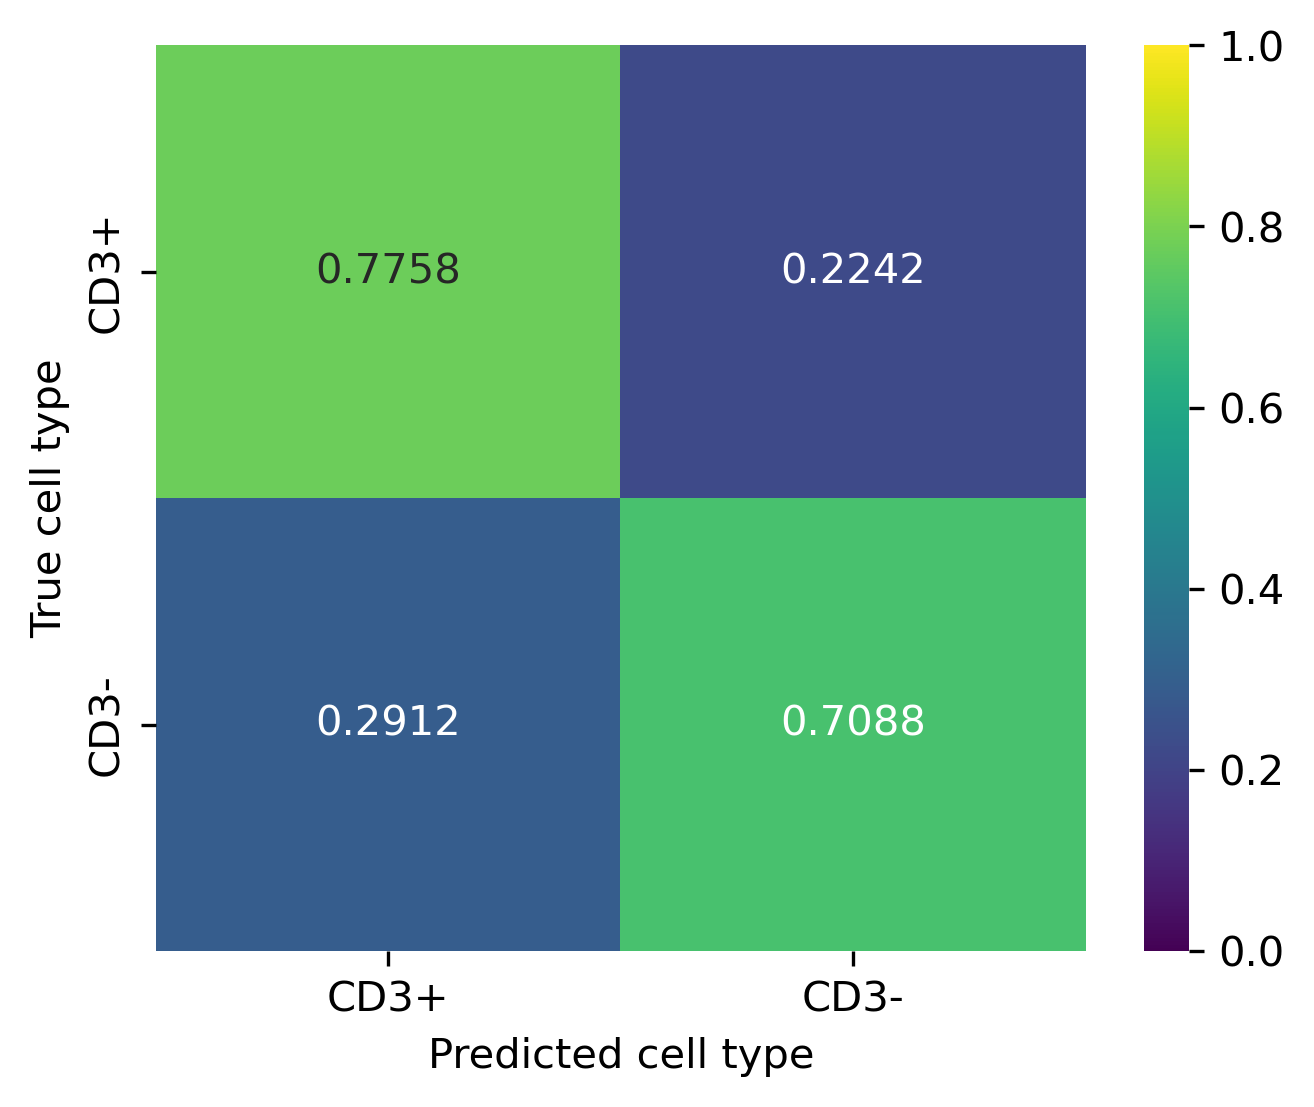

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_ct_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted cell type")
ax.set_ylabel("True cell type")
plt.show()

We notice that the classifier can accurately distinguish between CD3+ and CD3- PBMCs based on the chrometric profiles as indicated in the above confusion matrix.

---

#### Feature importance

The feature importance plot shown below identifies the chrometric markers which are most indicative of the cell type.

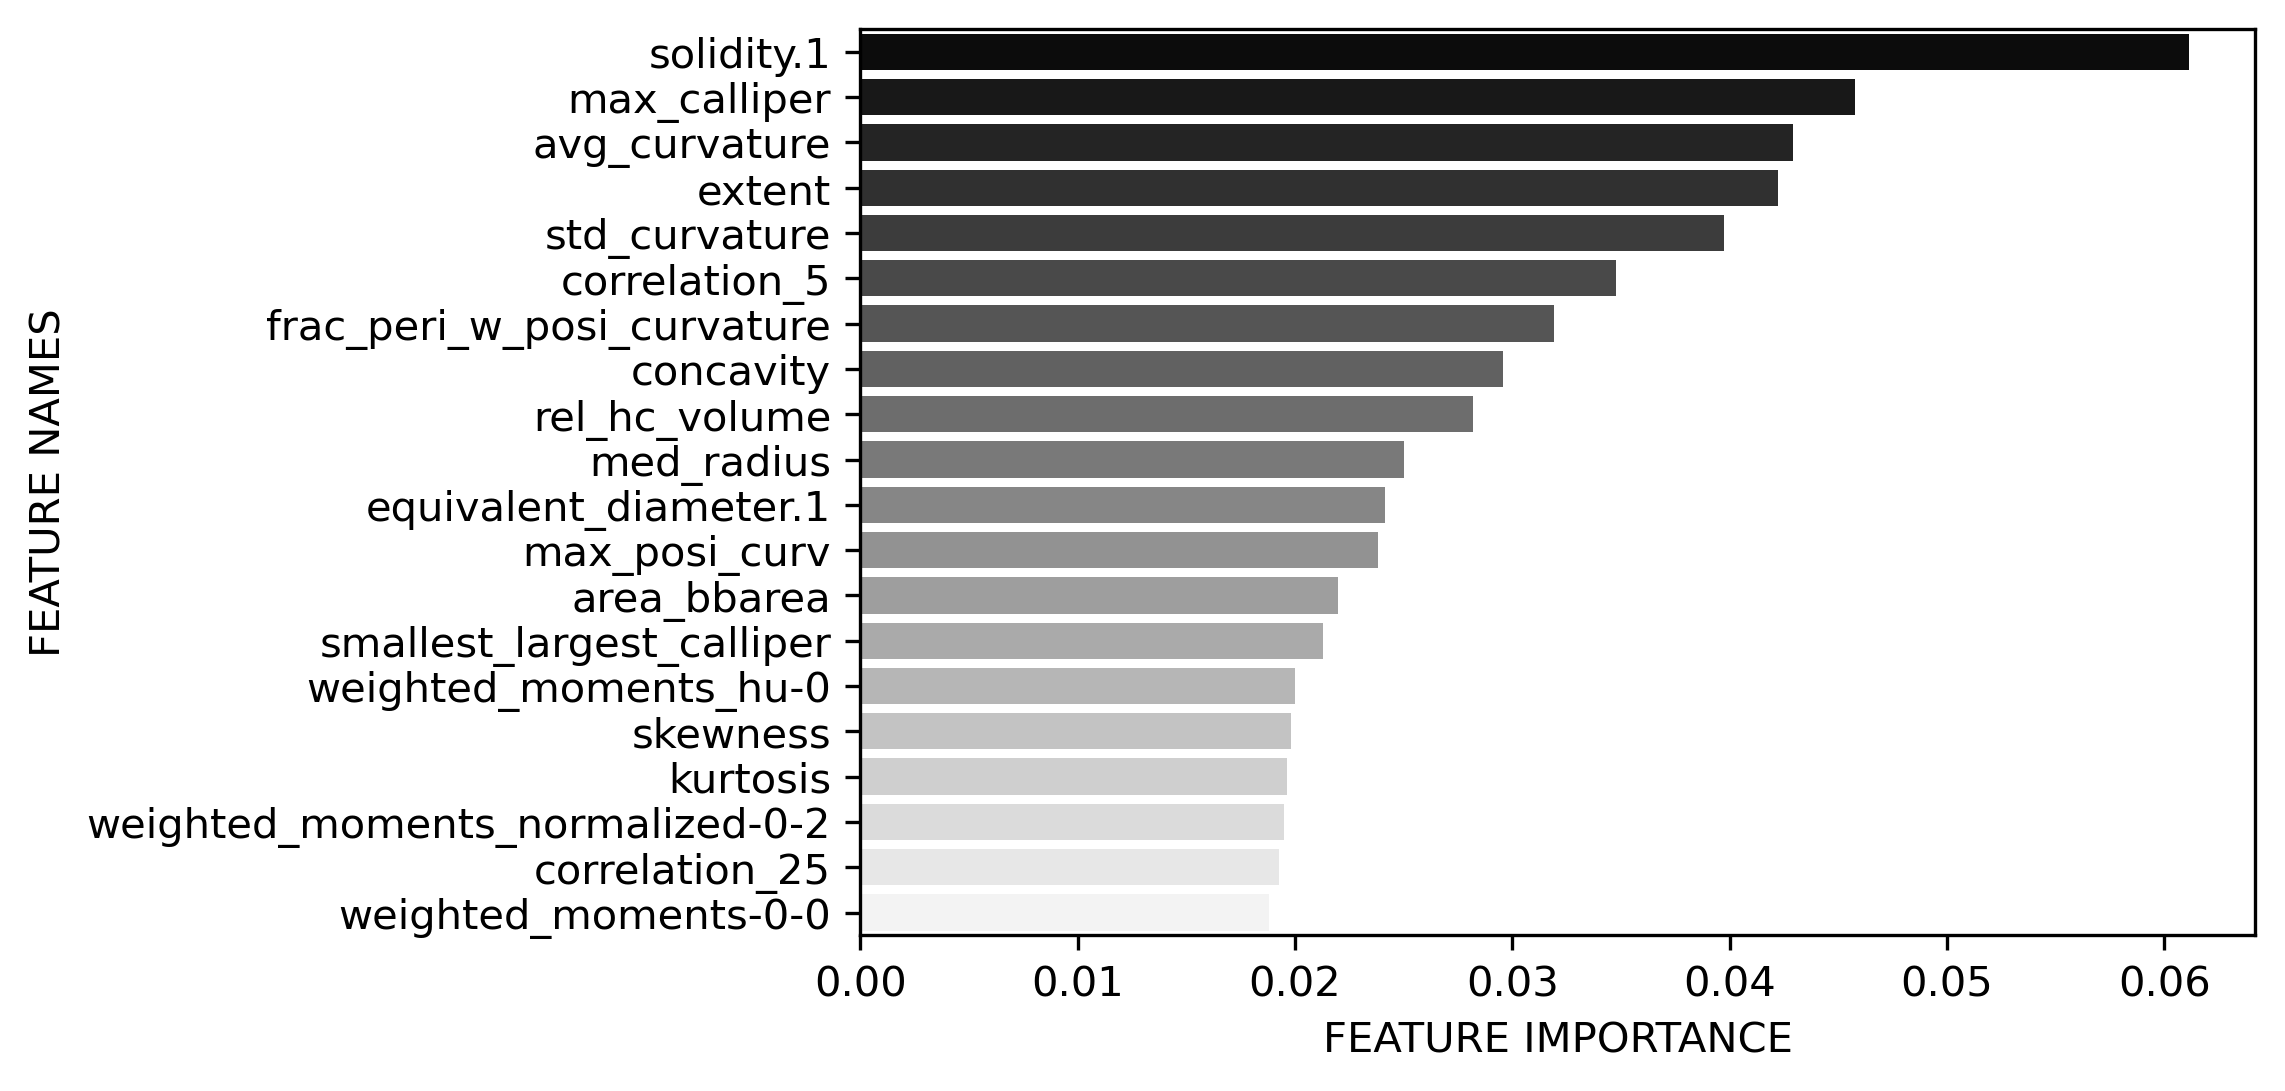

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    sampled_ct_data,
    sampled_ct_labels,
    scale_features=False,
    cmap="gray",
    figsize=[6, 4],
)

#### CD3+ marker screen

The results of a t-test based marker screen validates that in particular shape features like the solidity, the nuclear size as well as the curvature of the boundary of the projected nuclear mask carry information that distinguish the individual cell types.

In [33]:
marker_screen_results_ct = find_markers(chrometric_data, ct_labels)
marker_screen_results_ct.loc[marker_screen_results_ct.label == "CD3+"].head(10)

Run marker screen:   0%|          | 0/2 [00:00<?, ?it/s]

label                      marker        fc  abs_delta_fc           pval  \
14  CD3+      num_prominant_neg_curv  0.807214      0.192786   0.000000e+00   
55  CD3+                      extent  1.089222      0.089222   0.000000e+00   
7   CD3+               avg_curvature  1.064526      0.064526   0.000000e+00   
8   CD3+               std_curvature  0.845087      0.154913   0.000000e+00   
1   CD3+                max_calliper  0.927960      0.072040   0.000000e+00   
56  CD3+                  solidity.1  1.046189      0.046189   0.000000e+00   
15  CD3+  frac_peri_w_posi_curvature  1.037008      0.037008  2.753866e-305   
13  CD3+      num_prominant_pos_curv  0.845350      0.154650  1.646799e-295   
5   CD3+                   concavity  0.724823      0.275177  1.262099e-266   
2   CD3+   smallest_largest_calliper  1.059230      0.059230  6.138109e-237   

      pval_adjust  
14   0.000000e+00  
55   0.000000e+00  
7    0.000000e+00  
8    0.000000e+00  
1    0.000000e+00  
56   0.000000e+00  
15  2.321116e-304  
13  1.214514e-294  
5   8.273760e-266  
2   3.621484e-236

<IPython.core.display.Javascript object>

We note that the CD3+ cells show on average a more curved nuclear boundary with less changes of the same that features a more convex shape as apposed to CD3- cells.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:4.448e-173 t=-2.822e+01


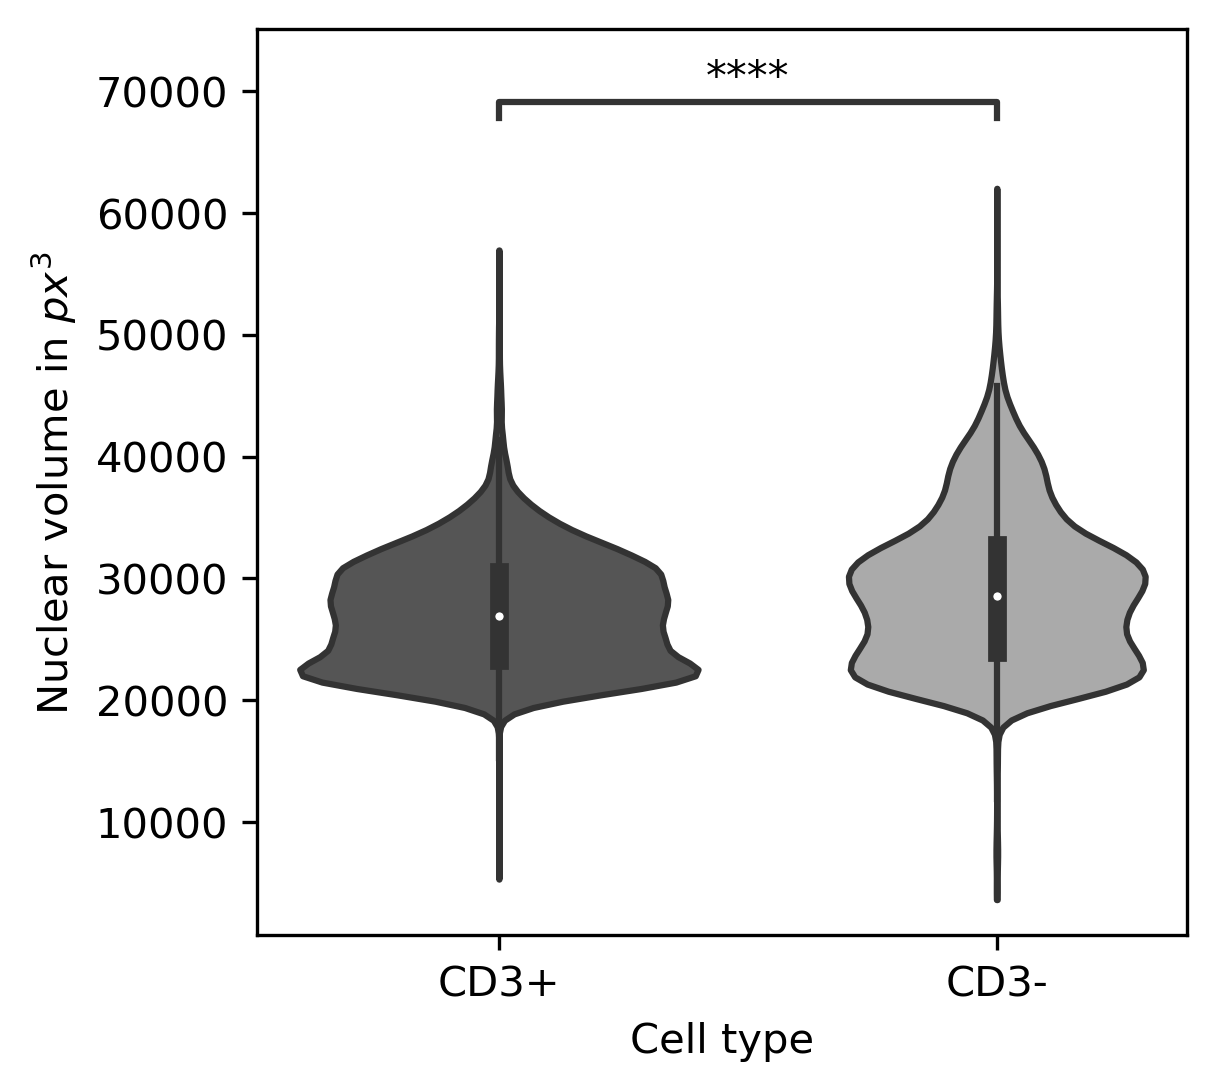

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-6.034e+01


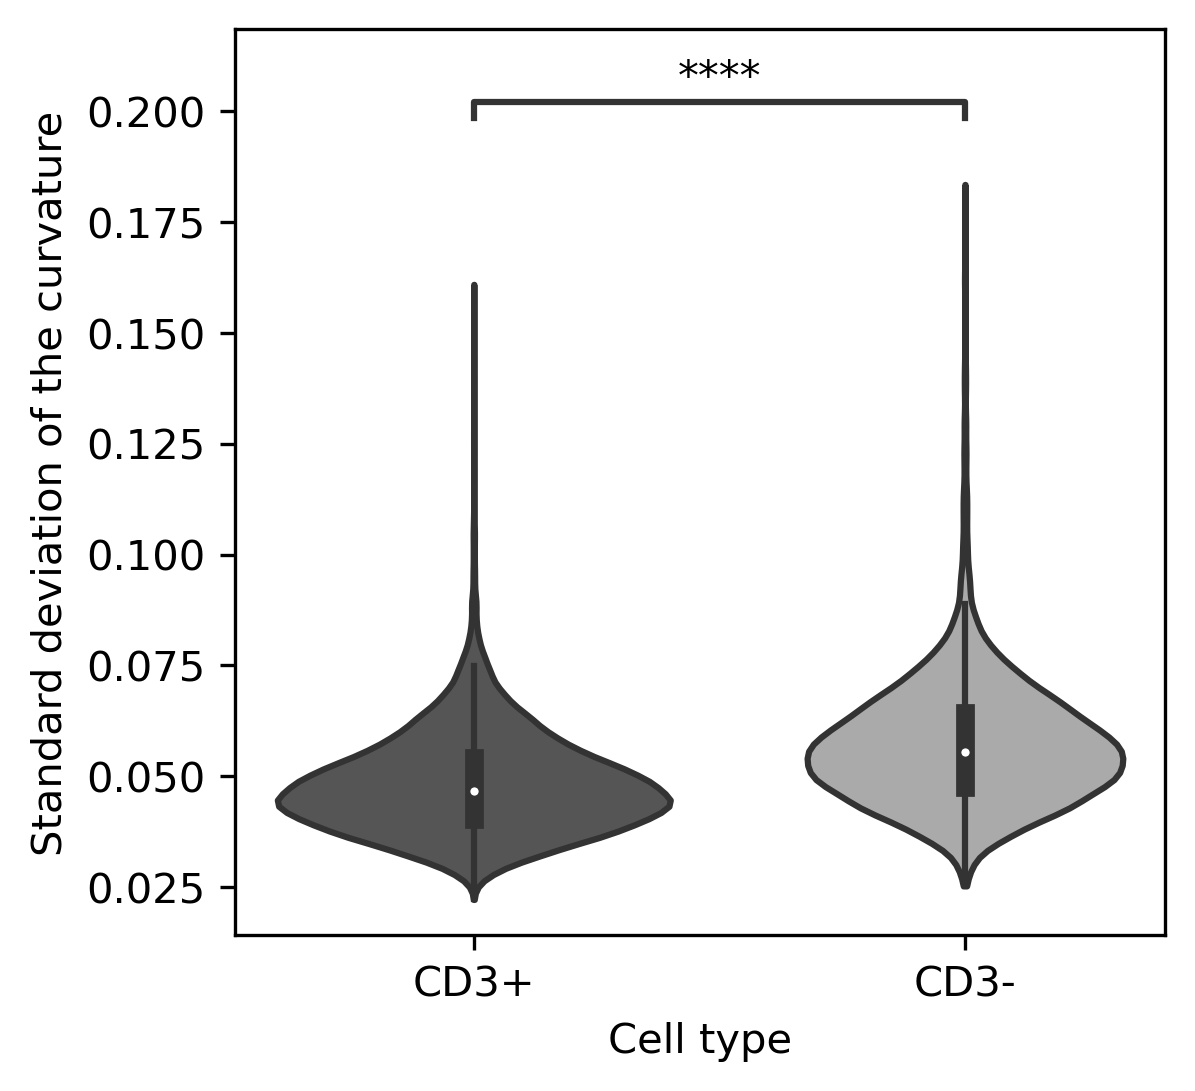

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.542e+01


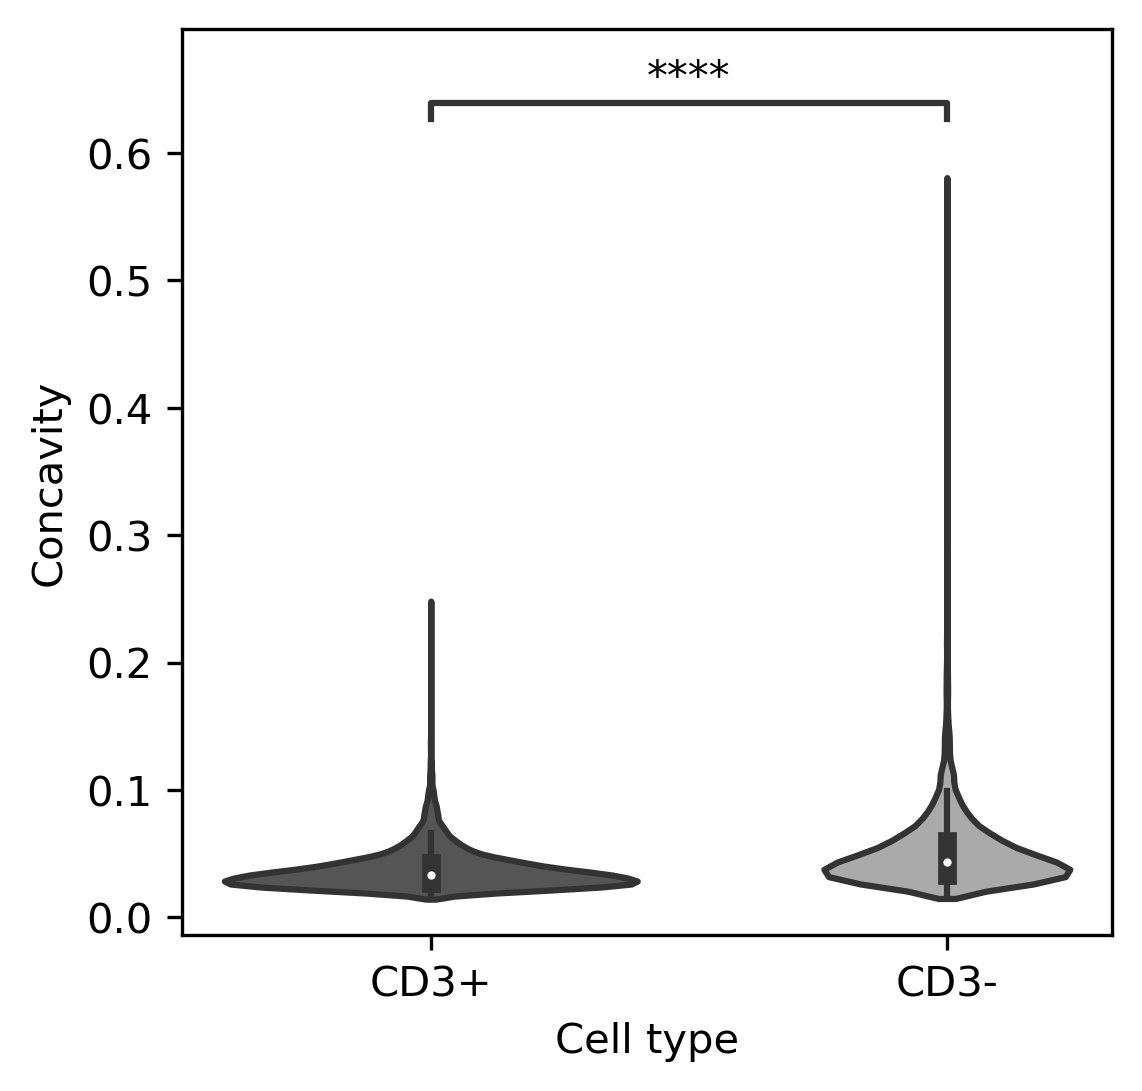

<IPython.core.display.Javascript object>

In [34]:
markers = ["nuclear_volume", "std_curvature", "concavity"]
marker_labels = [
    r"Nuclear volume in $px^3$",
    "Standard deviation of the curvature",
    "Concavity",
]
plot_cell_type_markers_dist(
    data=all_data, markers=markers, marker_labels=marker_labels, cut=0, palette="gray"
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:4.448e-173 t=-2.822e+01


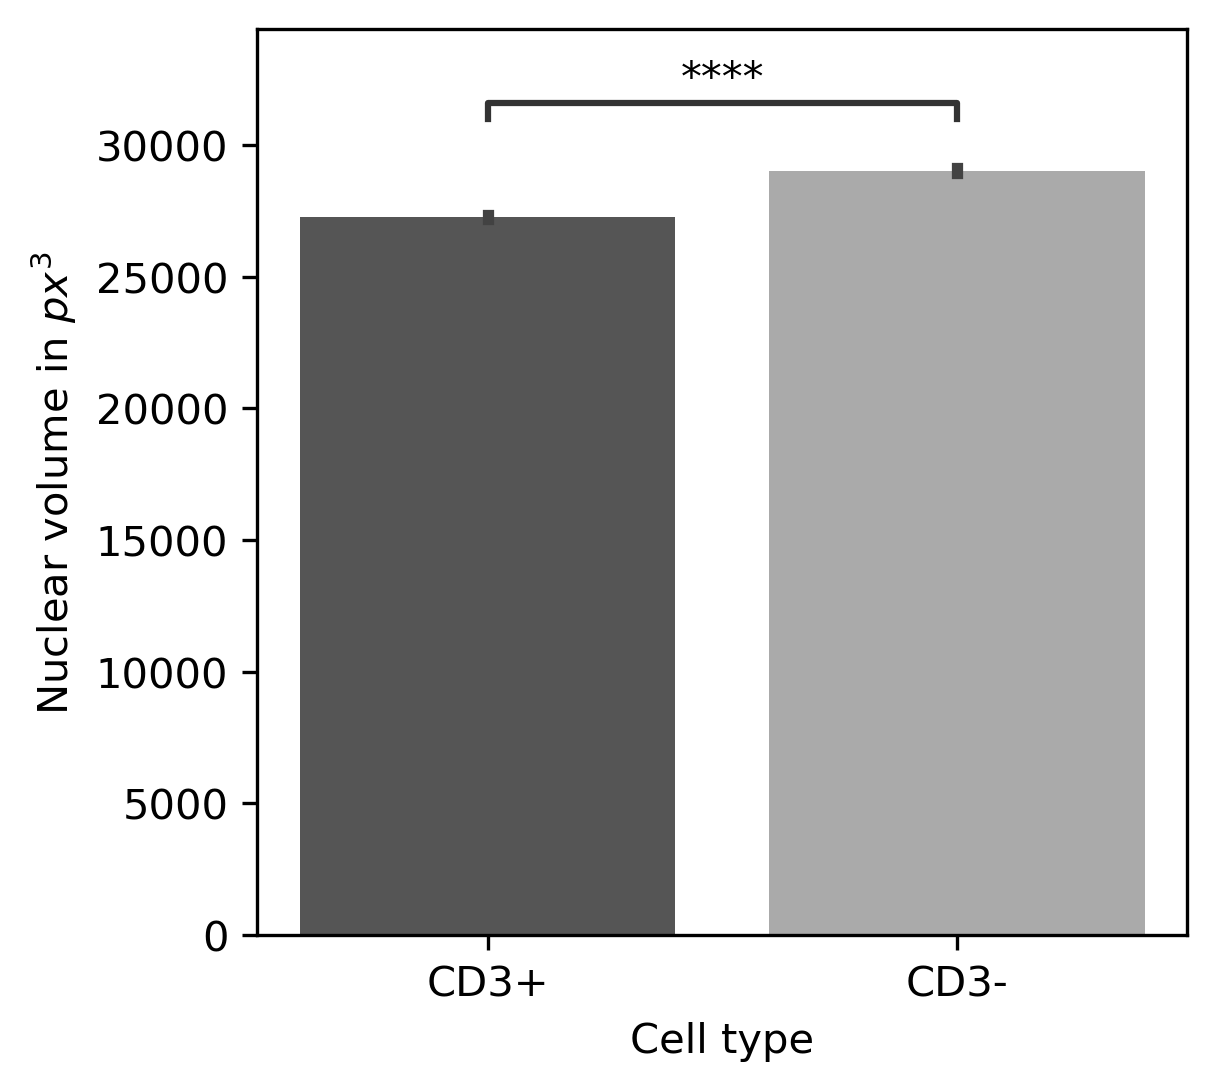

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-6.034e+01


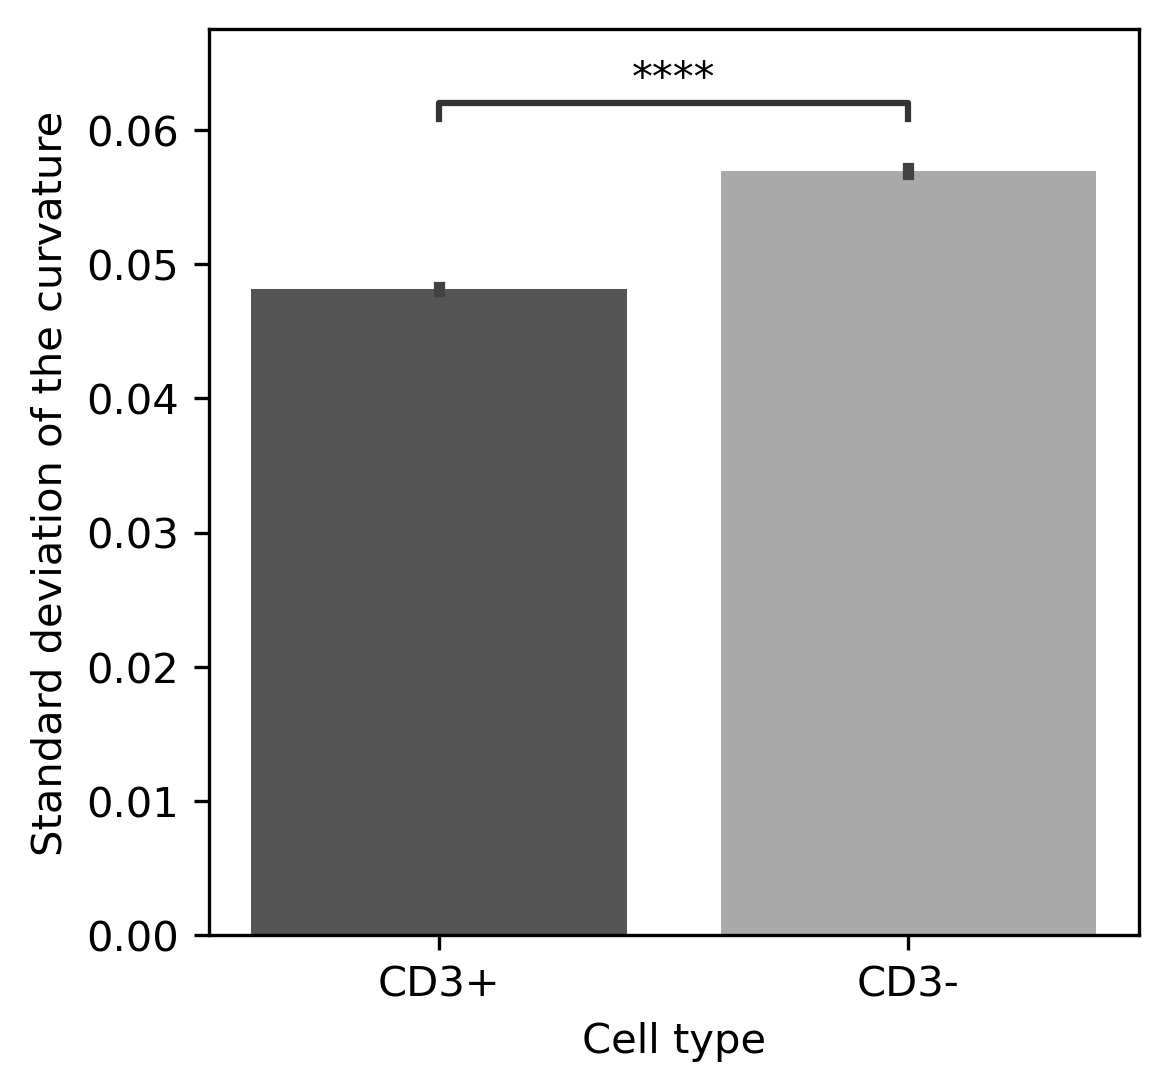

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD3+ vs. CD3-: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.542e+01


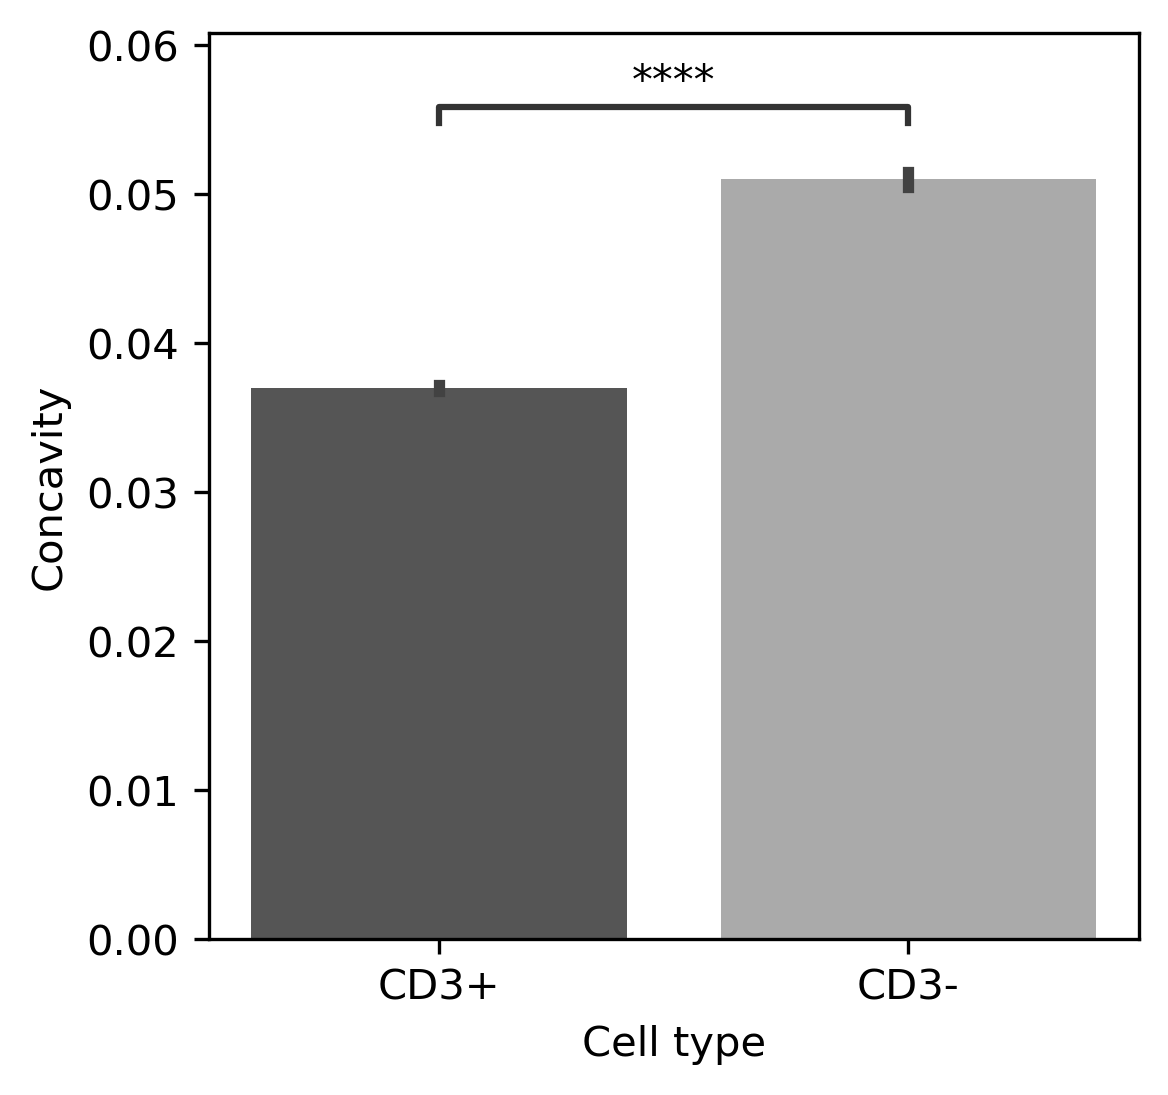

<IPython.core.display.Javascript object>

In [35]:
markers = ["nuclear_volume", "std_curvature", "concavity"]
marker_labels = [
    r"Nuclear volume in $px^3$",
    "Standard deviation of the curvature",
    "Concavity",
]
plot_cell_type_markers_dist(
    data=all_data,
    markers=markers,
    marker_labels=marker_labels,
    cut=0,
    palette="gray",
    plot_type="bar",
)

---

### 3b. Parametric analysis captures captures differences of PBMCs at different timepoints of the proton therapy treatment

Since there are significant differences of the chrometric phenotypes between CD3+ and CD3- negative cells we will now look at the previously identifed features that are the most significantly changing for both CD3+ and CD3- negative cells.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=7.843e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.274e-112 t=2.363e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.652e-318 t=4.368e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.704e-16 t=-8.250e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.323e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.270e-320 t=-4.368e+01
Head & Neck_prior vs. Head & Neck_end: t-test 

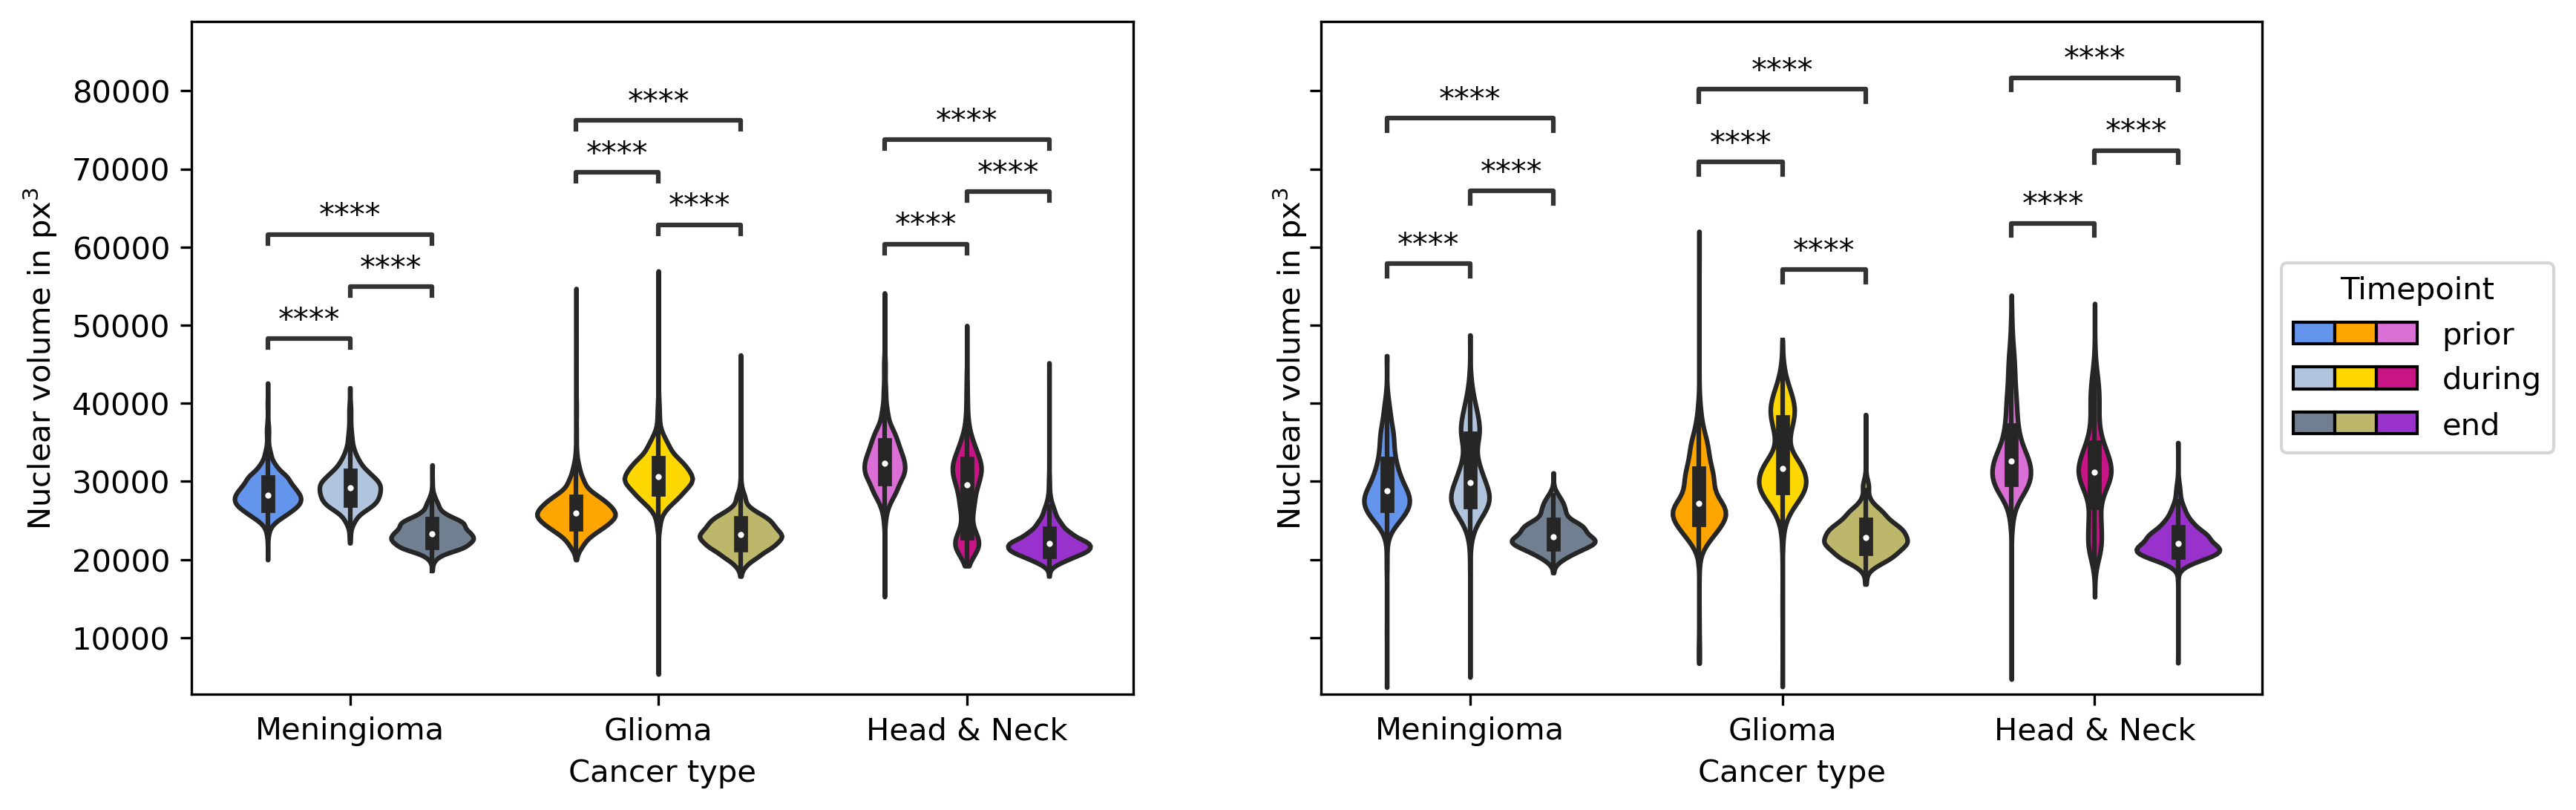

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.757e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.544e-139 t=2.668e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.811e-267 t=3.914e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.759e-167 t=-3.012e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.012e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-6.039e+01
Head & Neck_prior vs. Head & Neck_end: t-test 

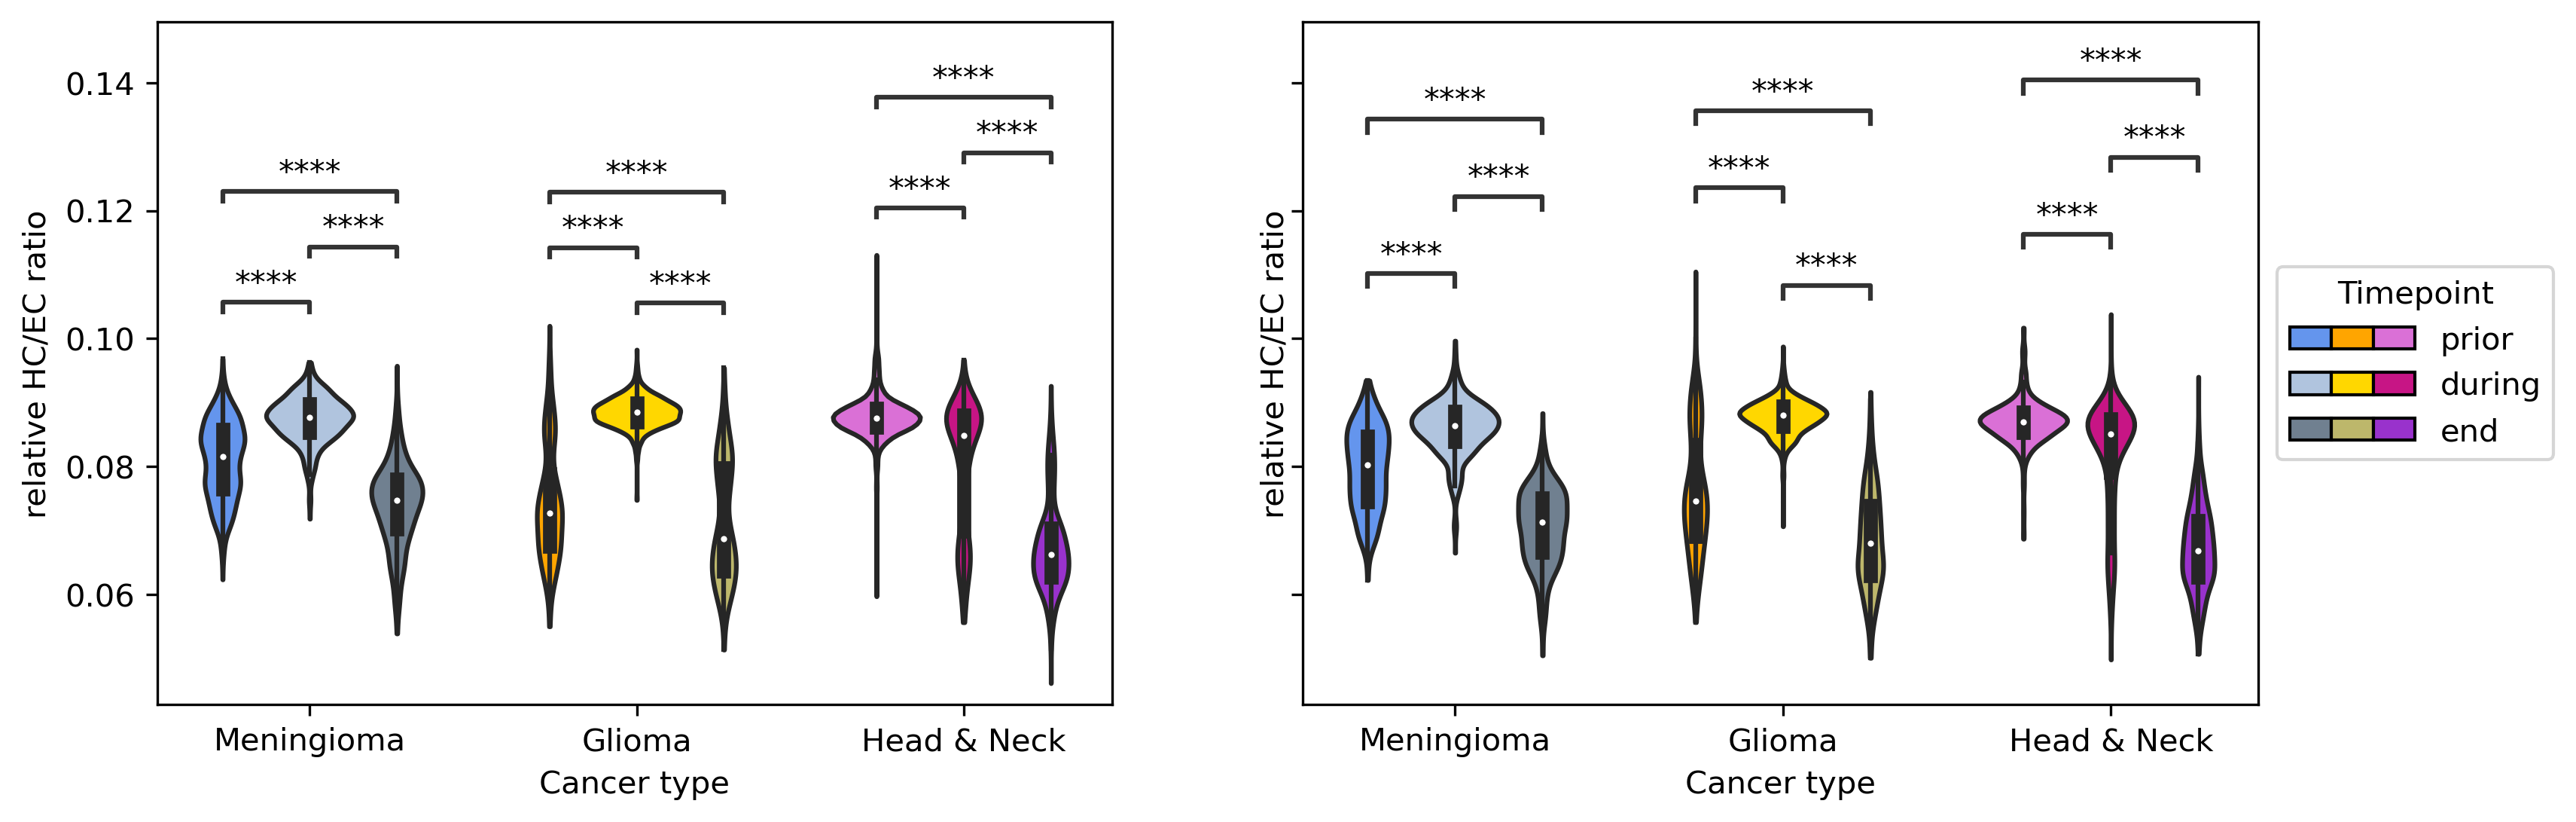

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.493e-42 t=-1.390e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.238e-15 t=-8.050e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.350e-28 t=-1.105e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.872e-07 t=4.980e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.769e-12 t=-7.029e+00
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.076e-51 t=1.544e+01
Head & Neck_prior vs. Head & Neck_end: t-test i

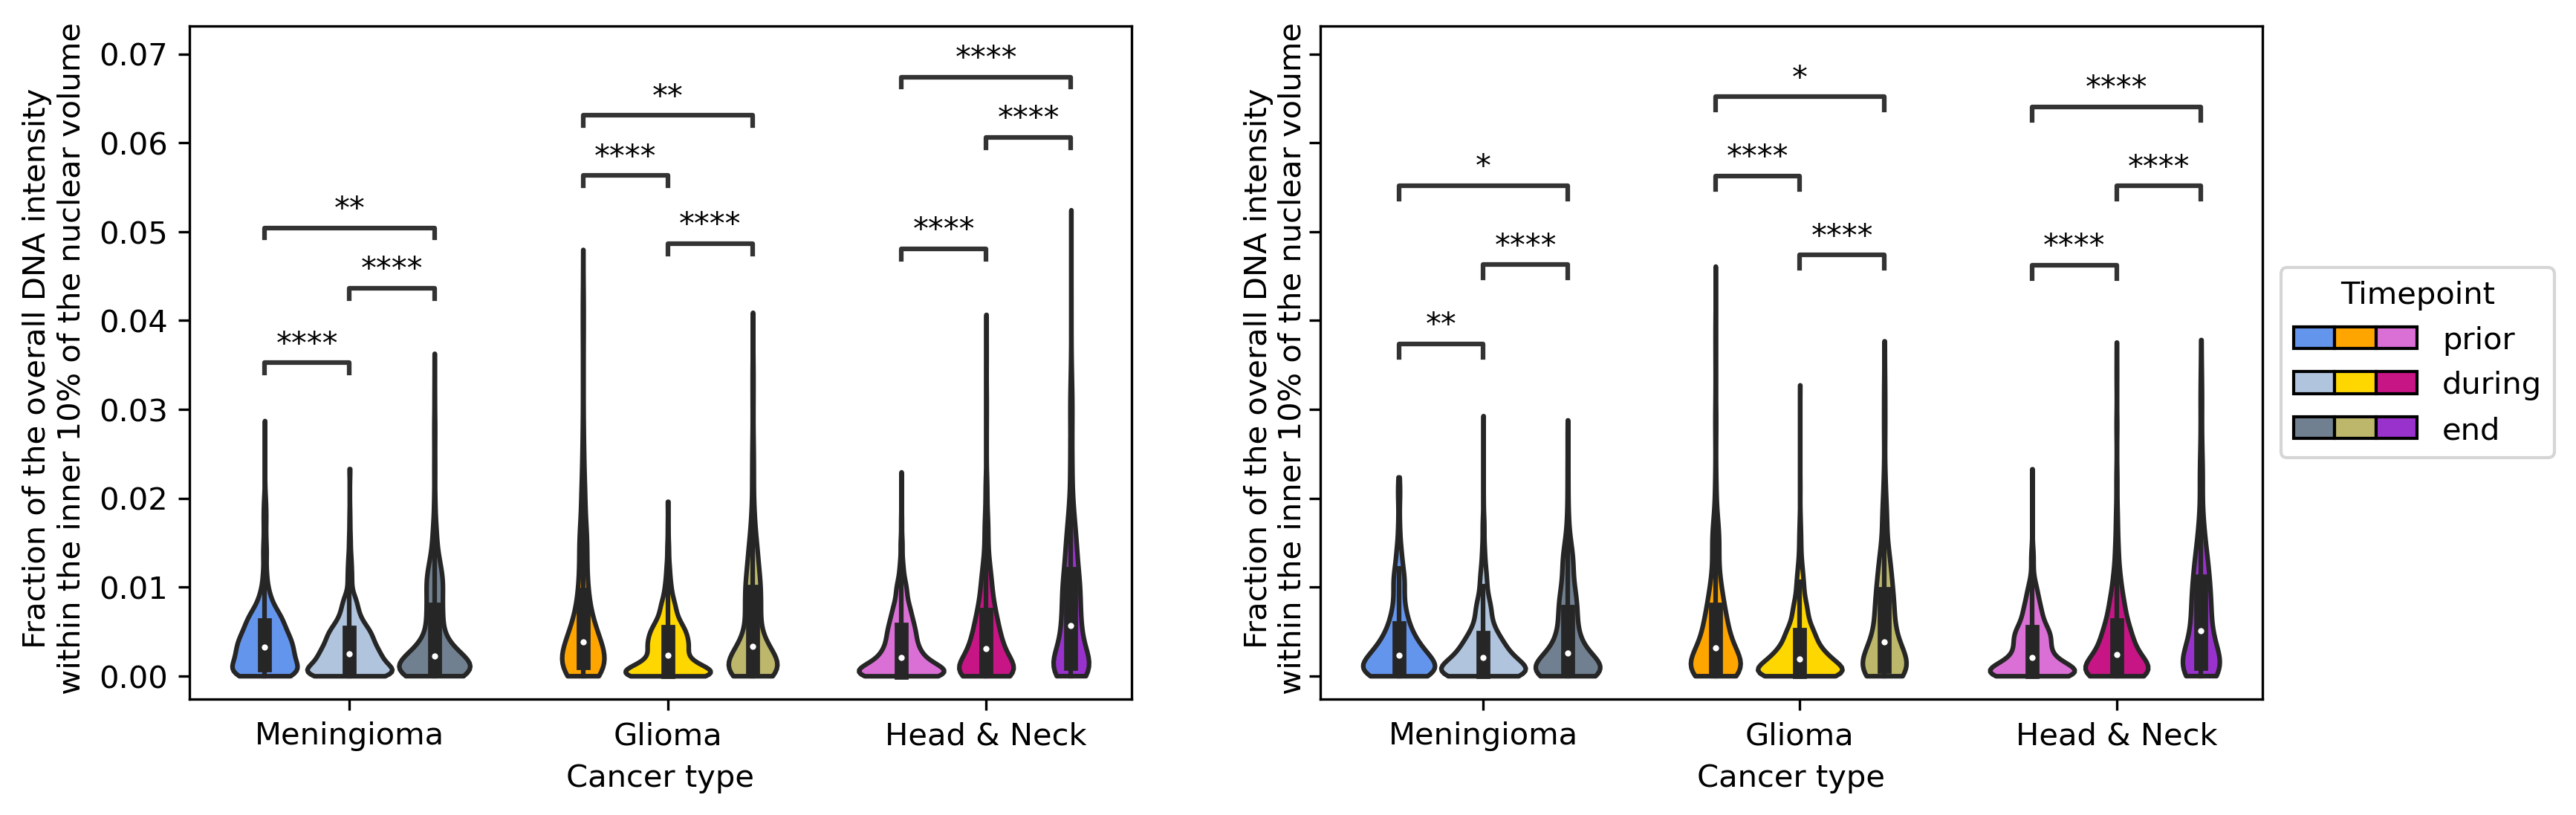

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.137e-90 t=2.082e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:9.466e-18 t=8.641e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.625e-51 t=1.542e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.228e-36 t=-1.273e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.339e-27 t=1.098e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.451e-142 t=-2.689e+01
Head & Neck_prior vs. Head & Neck_end: t-test in

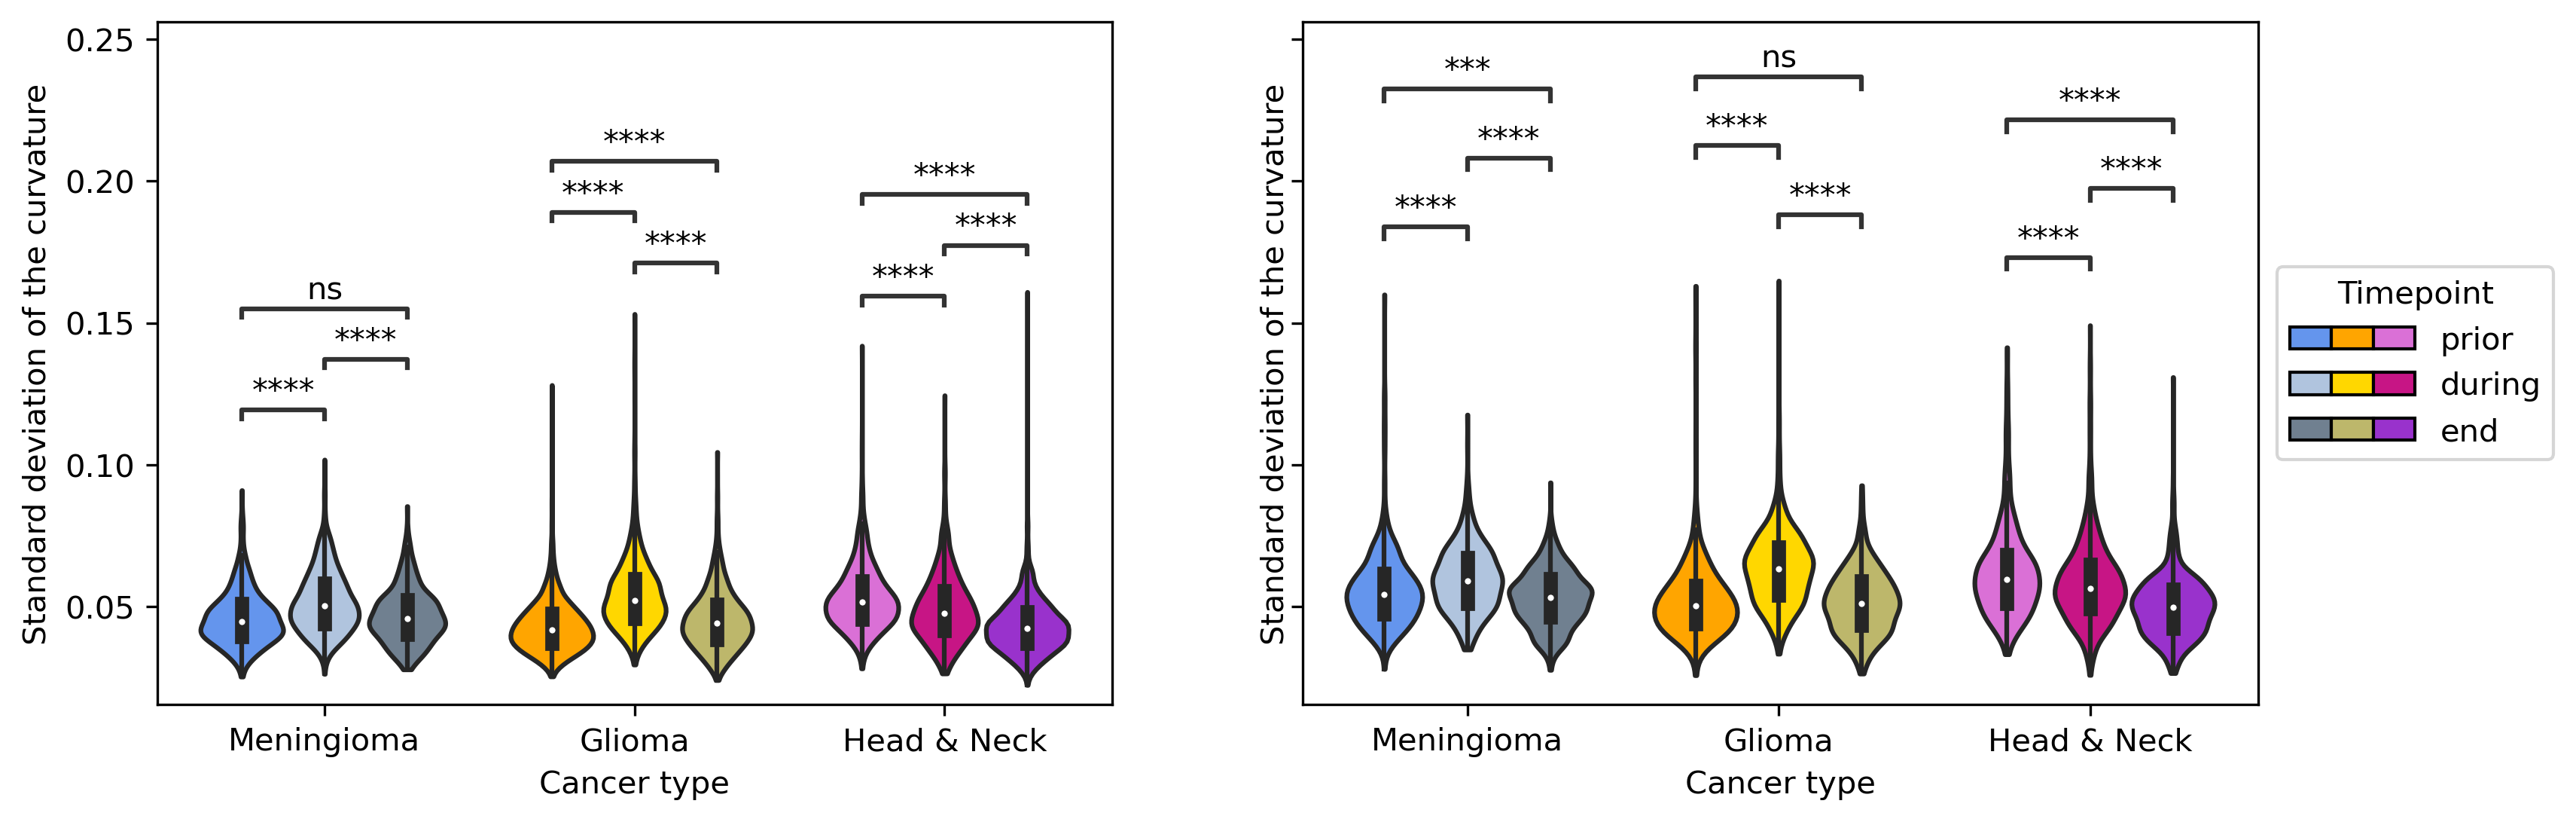

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.158e-64 t=-1.733e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.875e-01 t=1.415e-01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.122e-18 t=-8.735e+00
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.629e-45 t=-1.439e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.085e-09 t=5.905e+00
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.515e-32 t=1.189e+01
Head & Neck_prior vs. Head & Neck_end: t-test in

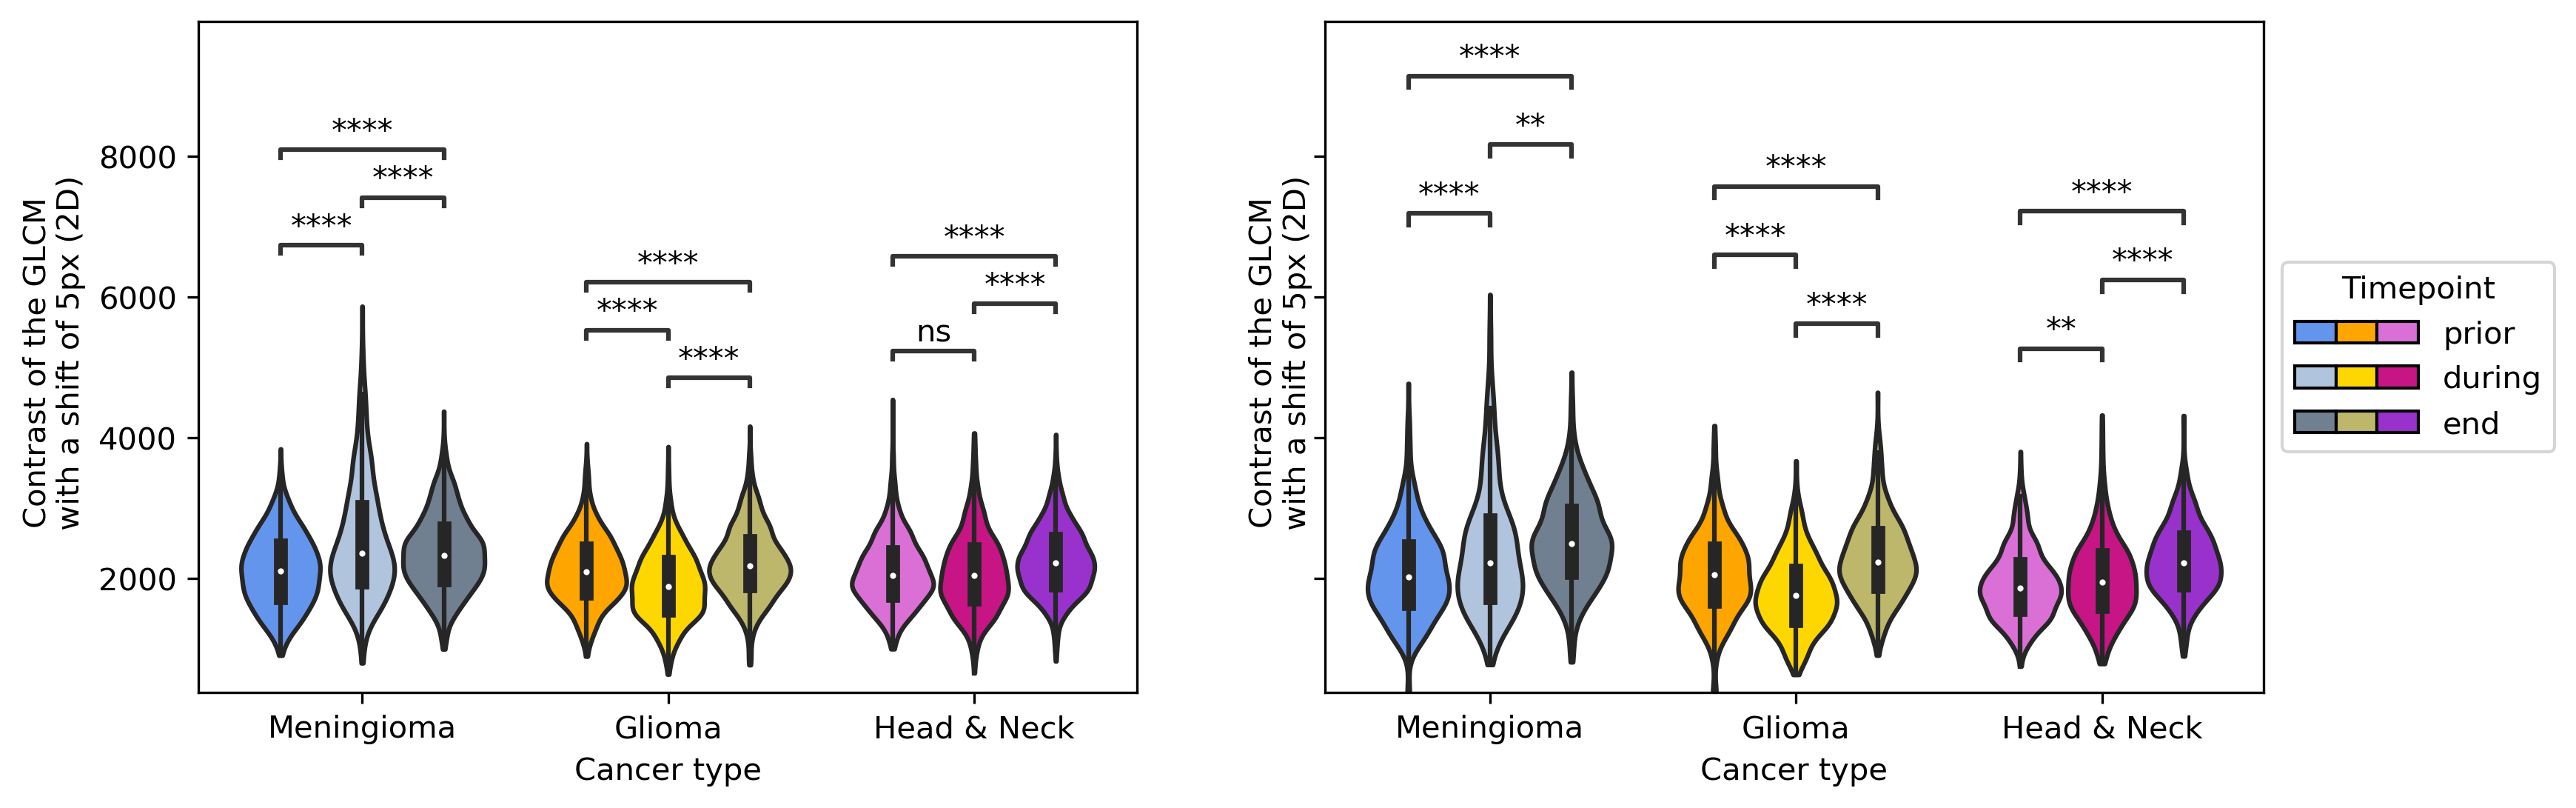

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.149e-163 t=-2.907e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.458e-14 t=-7.735e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.989e-87 t=-2.047e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.484e-06 t=4.827e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.530e-40 t=-1.354e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.496e-167 t=2.945e+01
Head & Neck_prior vs. Head & Neck_end: t-test

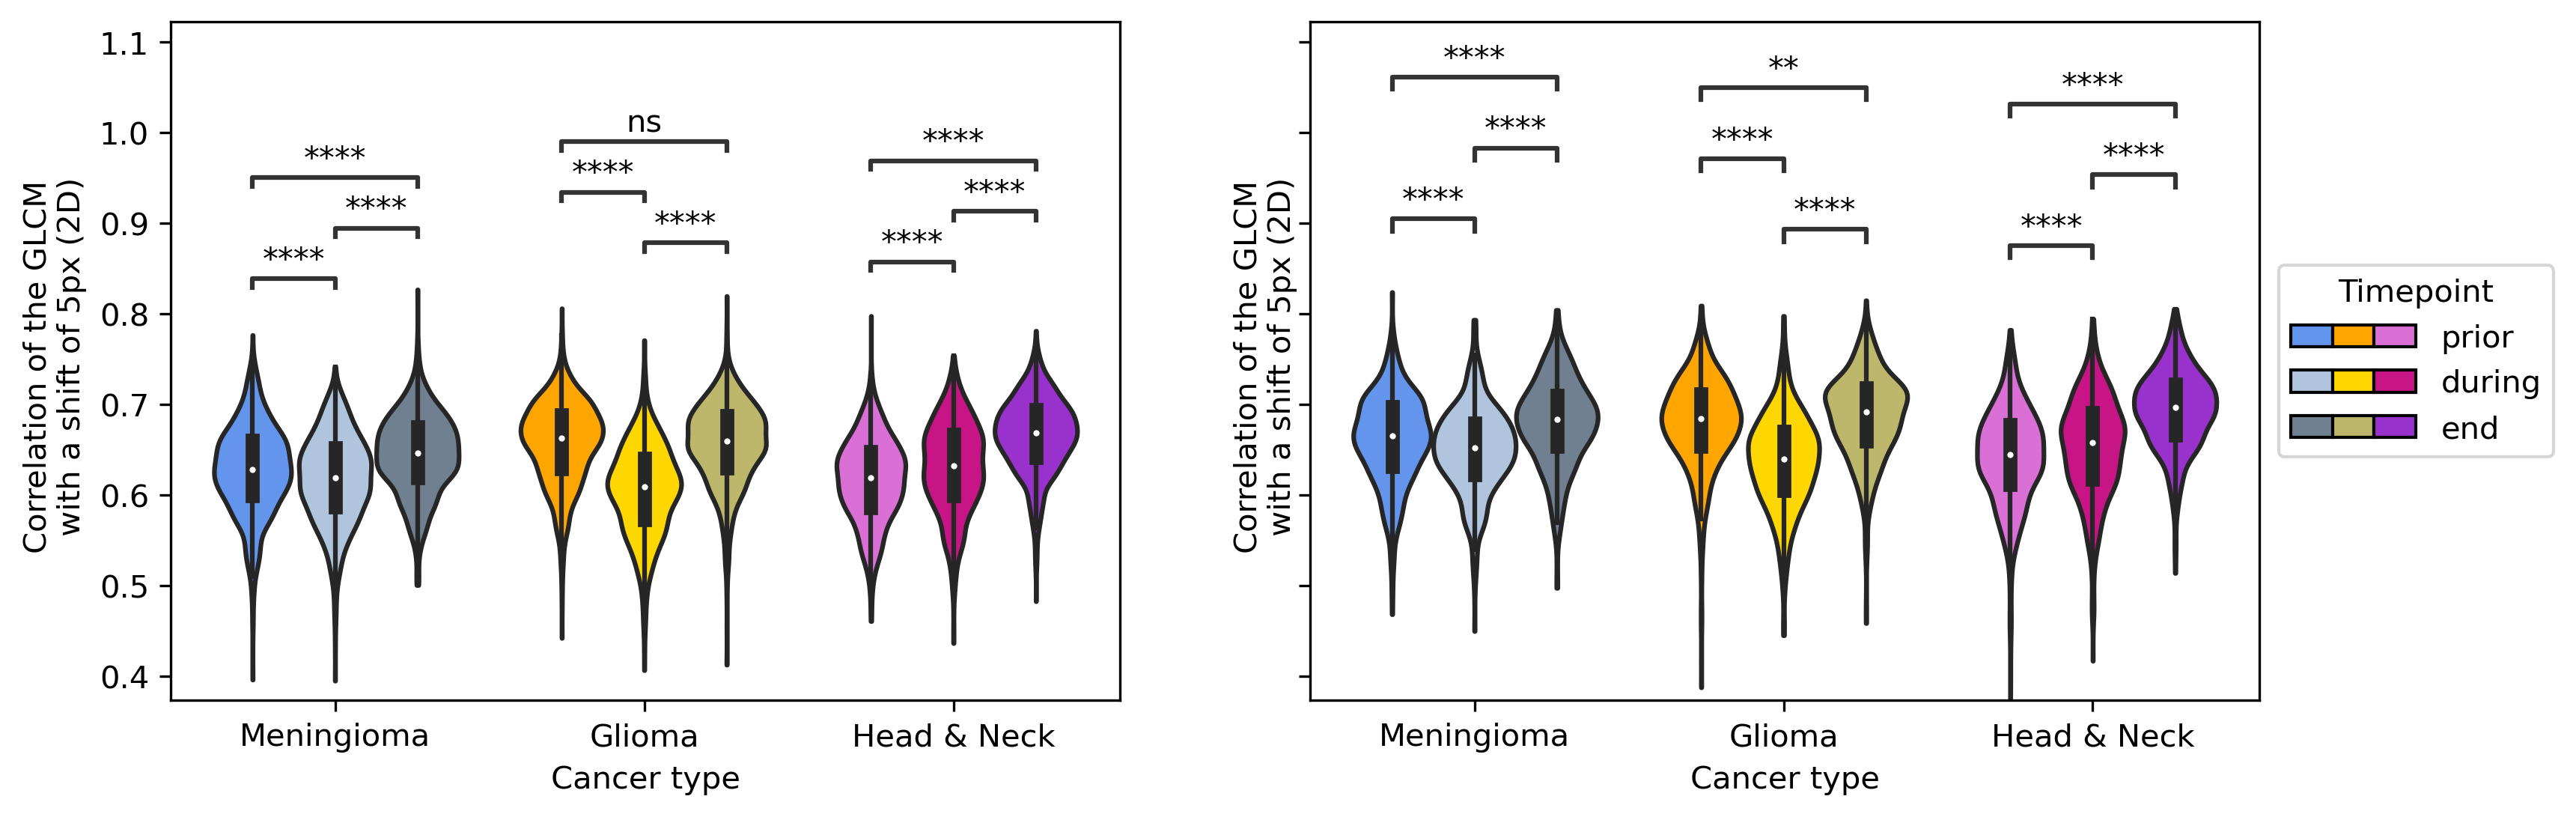

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.681e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.996e-58 t=1.645e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.521e-209 t=3.370e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.537e-22 t=-9.743e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.273e-211 t=3.477e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.682e+01
Head & Neck_prior vs. Head & Neck_end: t-test i

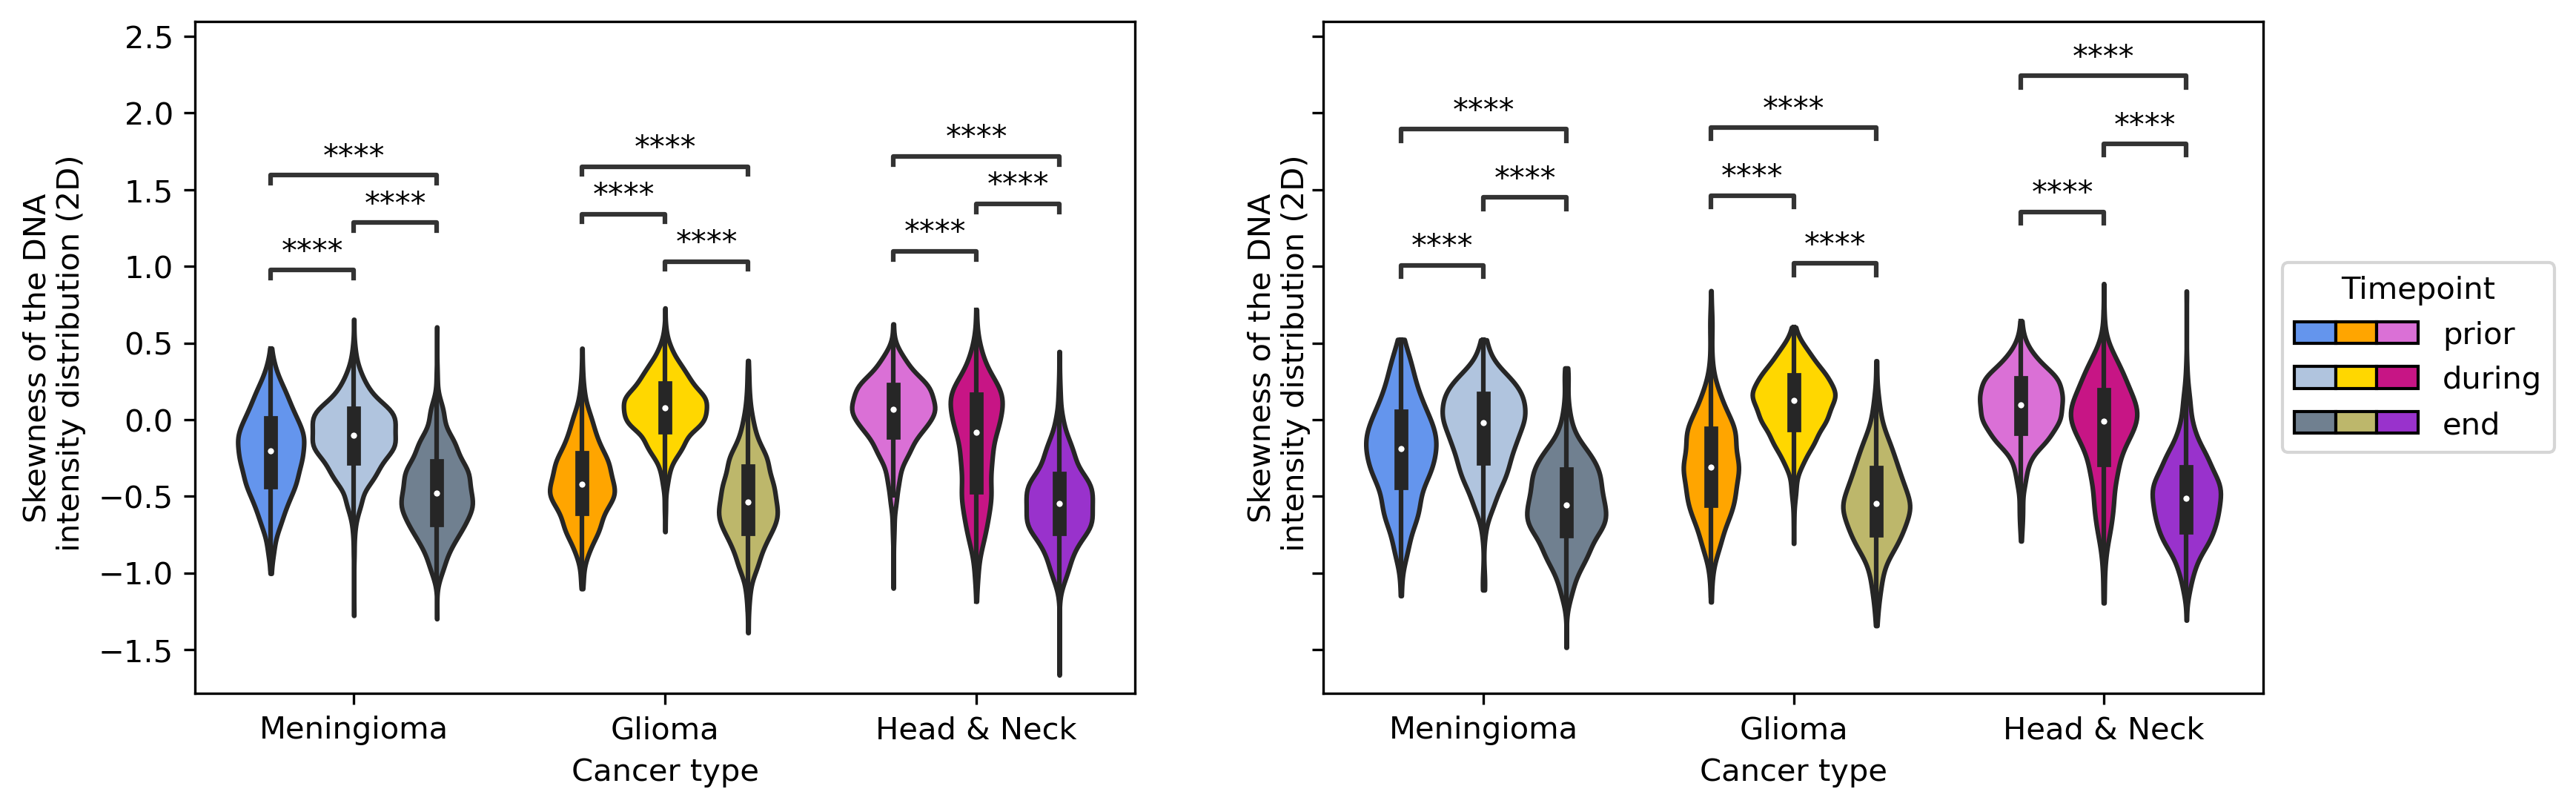

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.472e-215 t=-3.413e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.890e-58 t=-1.650e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.874e-84 t=-2.016e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.289e-92 t=2.138e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.257e-171 t=-3.060e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:9.375e-230 t=3.556e+01
Head & Neck_prior vs. Head & Neck_end: t-tes

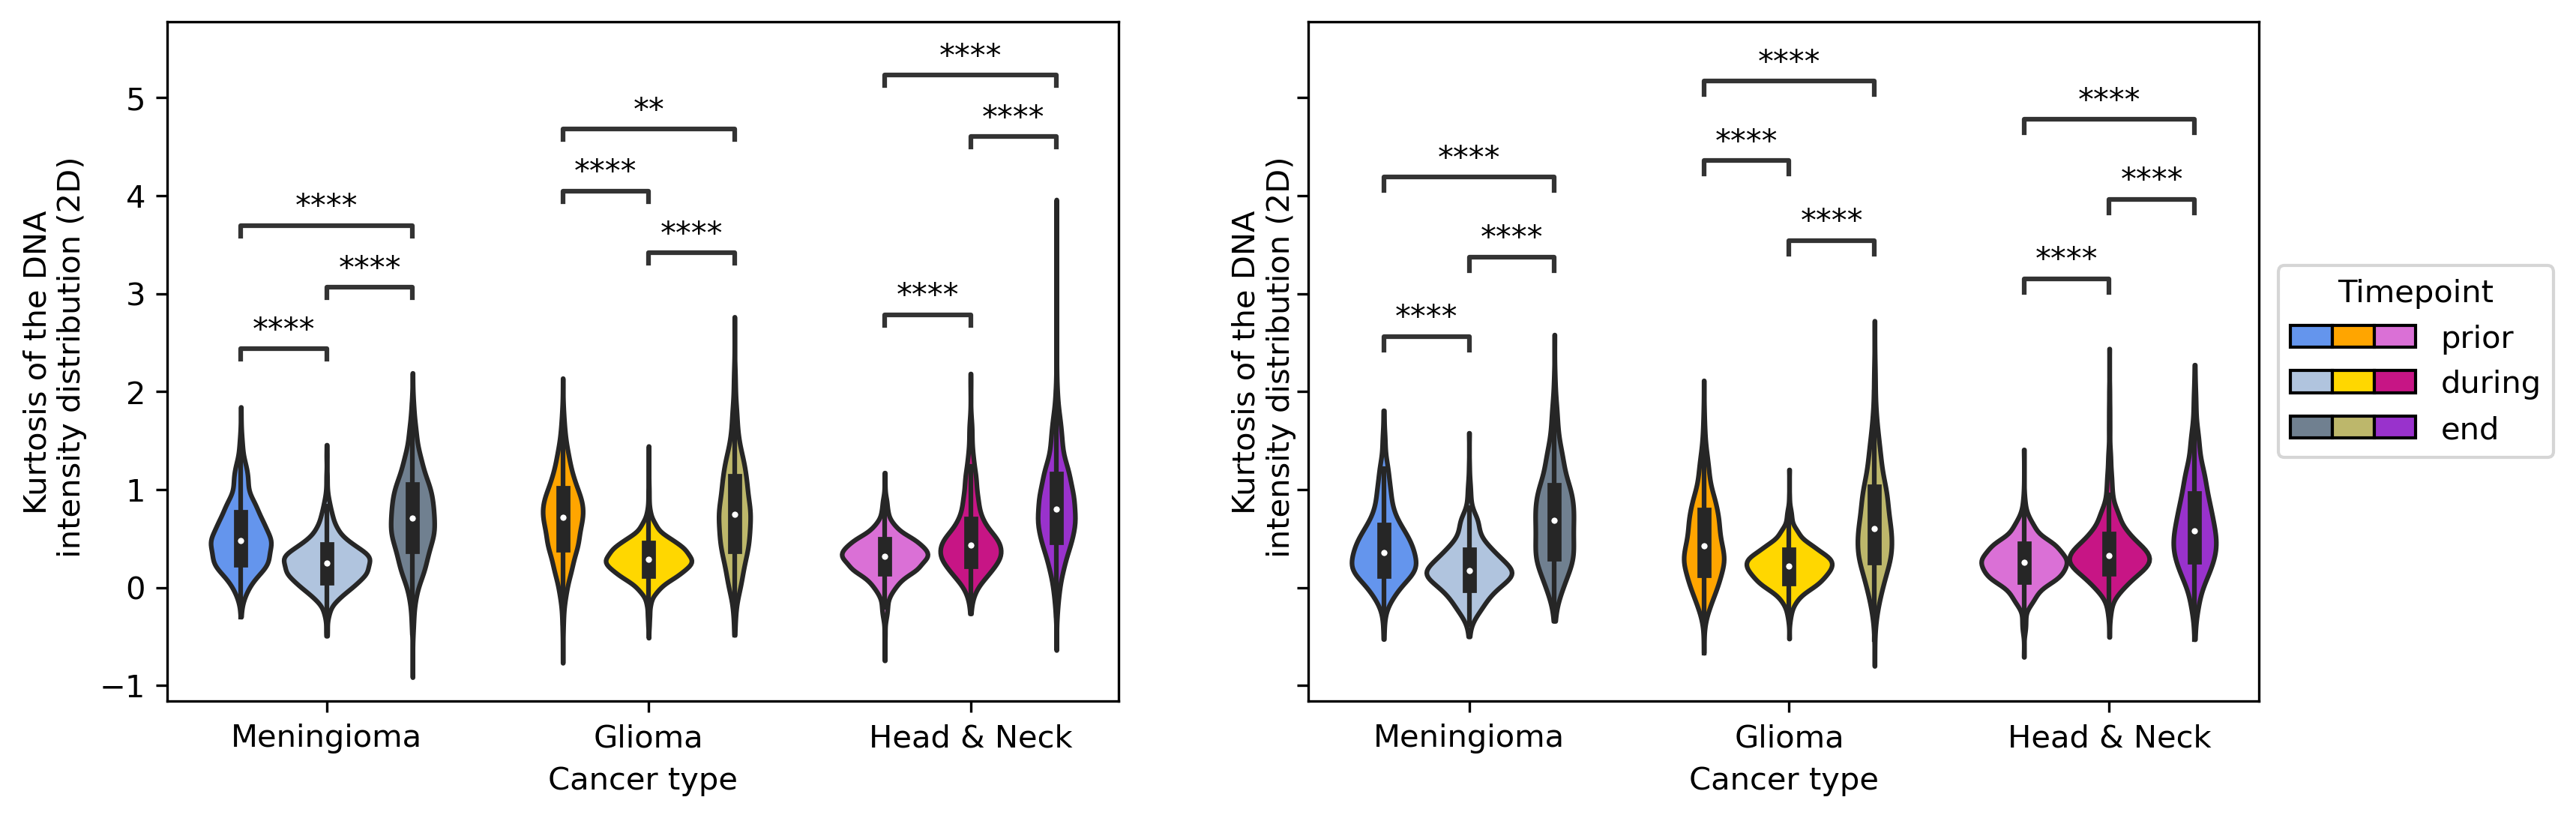

<IPython.core.display.Javascript object>

In [36]:
markers = [
    "nuclear_volume",
    "hc_ec_ratio_3d",
    "rdp_1",
    "std_curvature",
    "contrast_5",
    "correlation_5",
    "skewness",
    "kurtosis",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "relative HC/EC ratio",
    "Fraction of the overall DNA intensity \n within the inner 10% of the nuclear volume",
    "Standard deviation of the curvature",
    "Contrast of the GLCM \n with a shift of 5px (2D)",
    "Correlation of the GLCM \n with a shift of 5px (2D)",
    "Skewness of the DNA\n intensity distribution (2D)",
    "Kurtosis of the DNA\n intensity distribution (2D)",
]
plot_timepoint_cancer_celltype_markers_dist(
    data,
    markers,
    marker_labels,
    celltypes=["CD3+", "CD3-"],
    cut=0,
    palette=color_palette,
    figsize=[12, 4],
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=7.843e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.274e-112 t=2.363e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.652e-318 t=4.368e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.704e-16 t=-8.250e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.323e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.270e-320 t=-4.368e+01
Head & Neck_prior vs. Head & Neck_end: t-test 

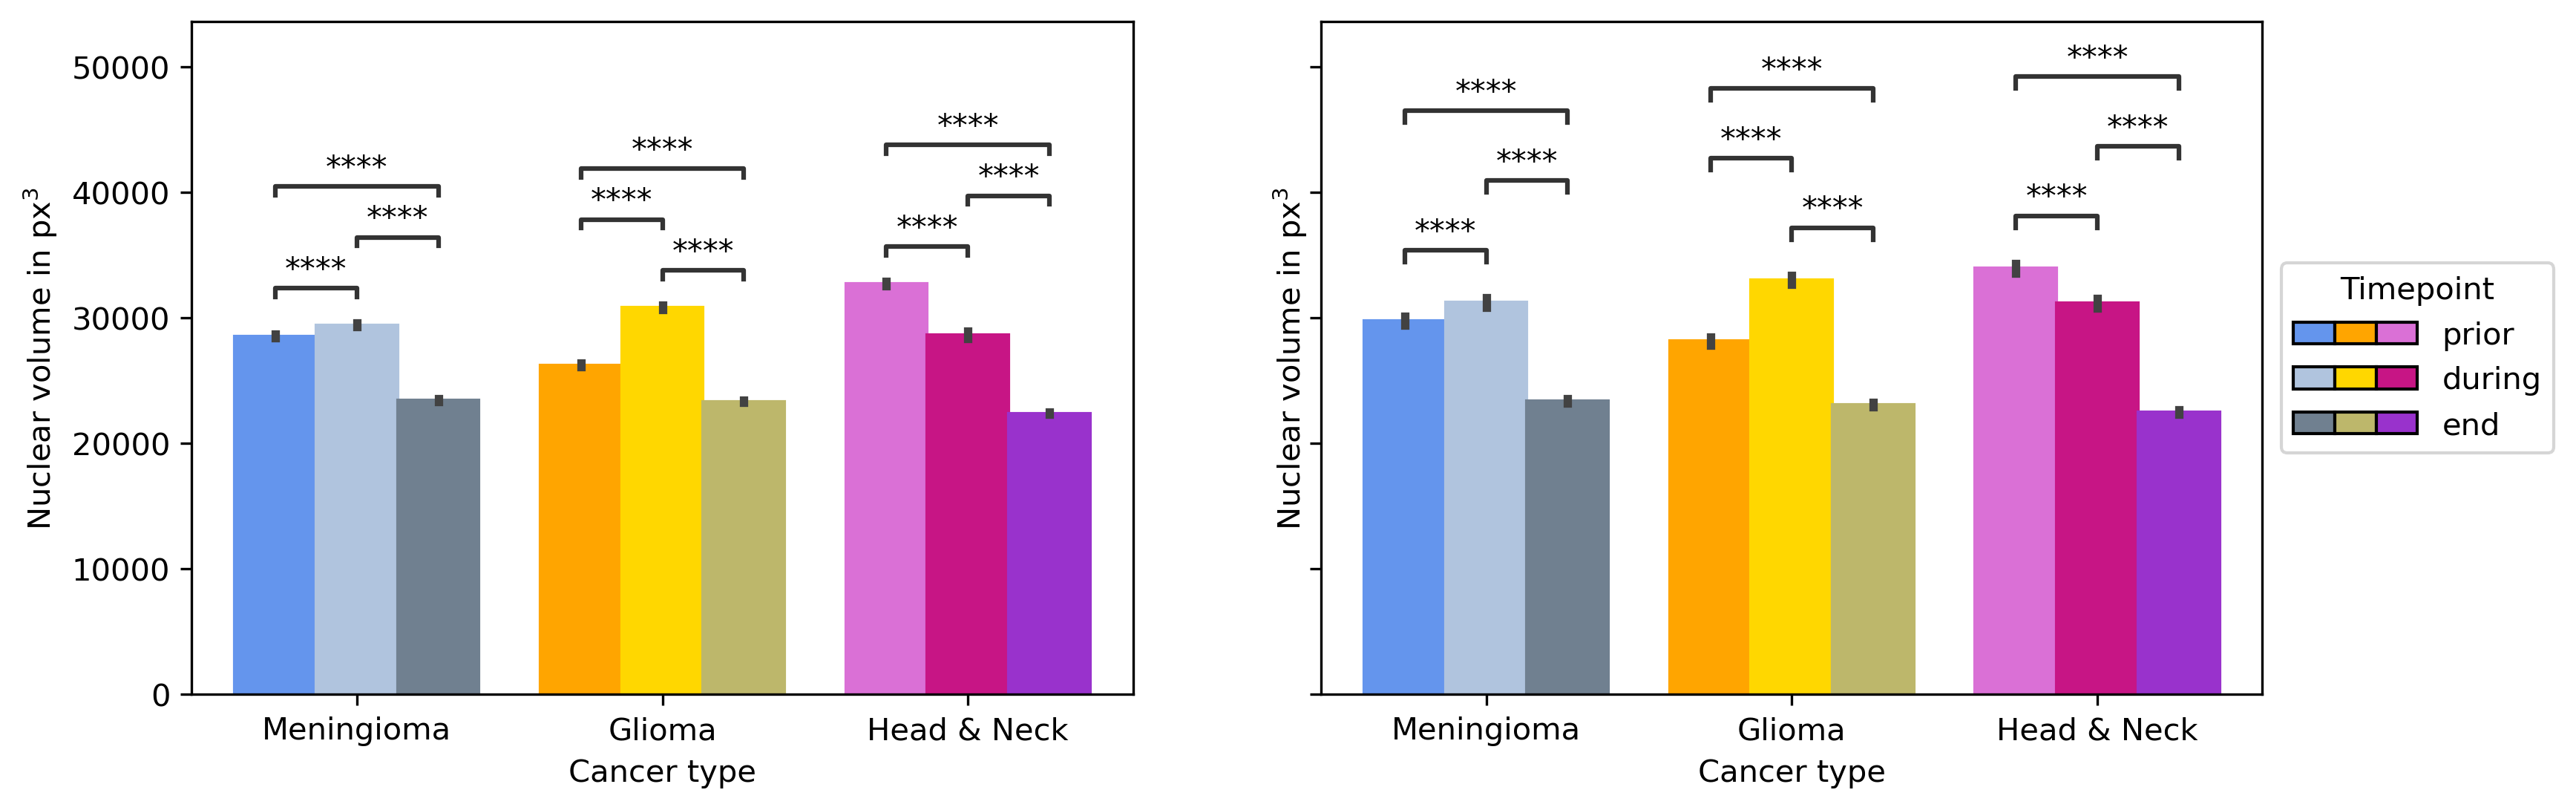

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.757e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.544e-139 t=2.668e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.811e-267 t=3.914e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.759e-167 t=-3.012e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.012e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-6.039e+01
Head & Neck_prior vs. Head & Neck_end: t-test 

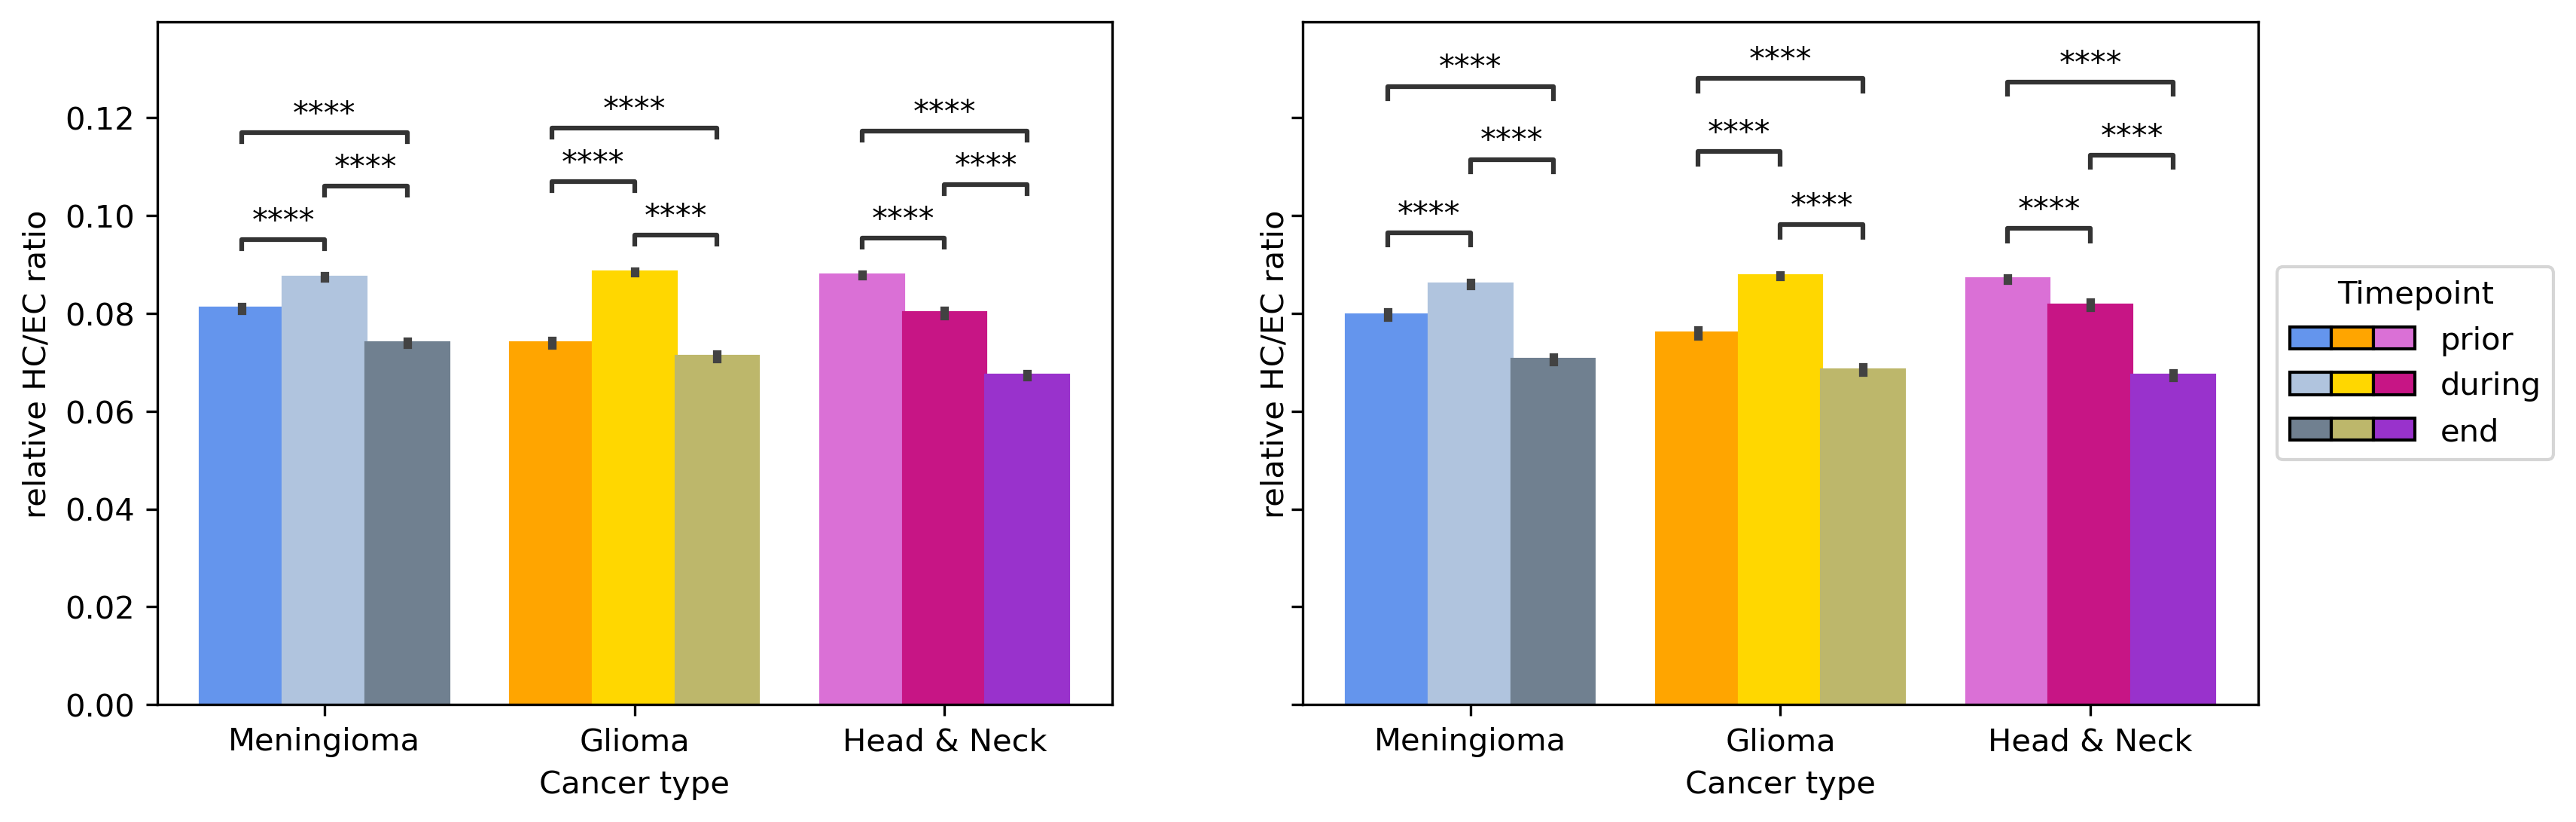

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.493e-42 t=-1.390e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.238e-15 t=-8.050e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.350e-28 t=-1.105e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.872e-07 t=4.980e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.769e-12 t=-7.029e+00
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.076e-51 t=1.544e+01
Head & Neck_prior vs. Head & Neck_end: t-test i

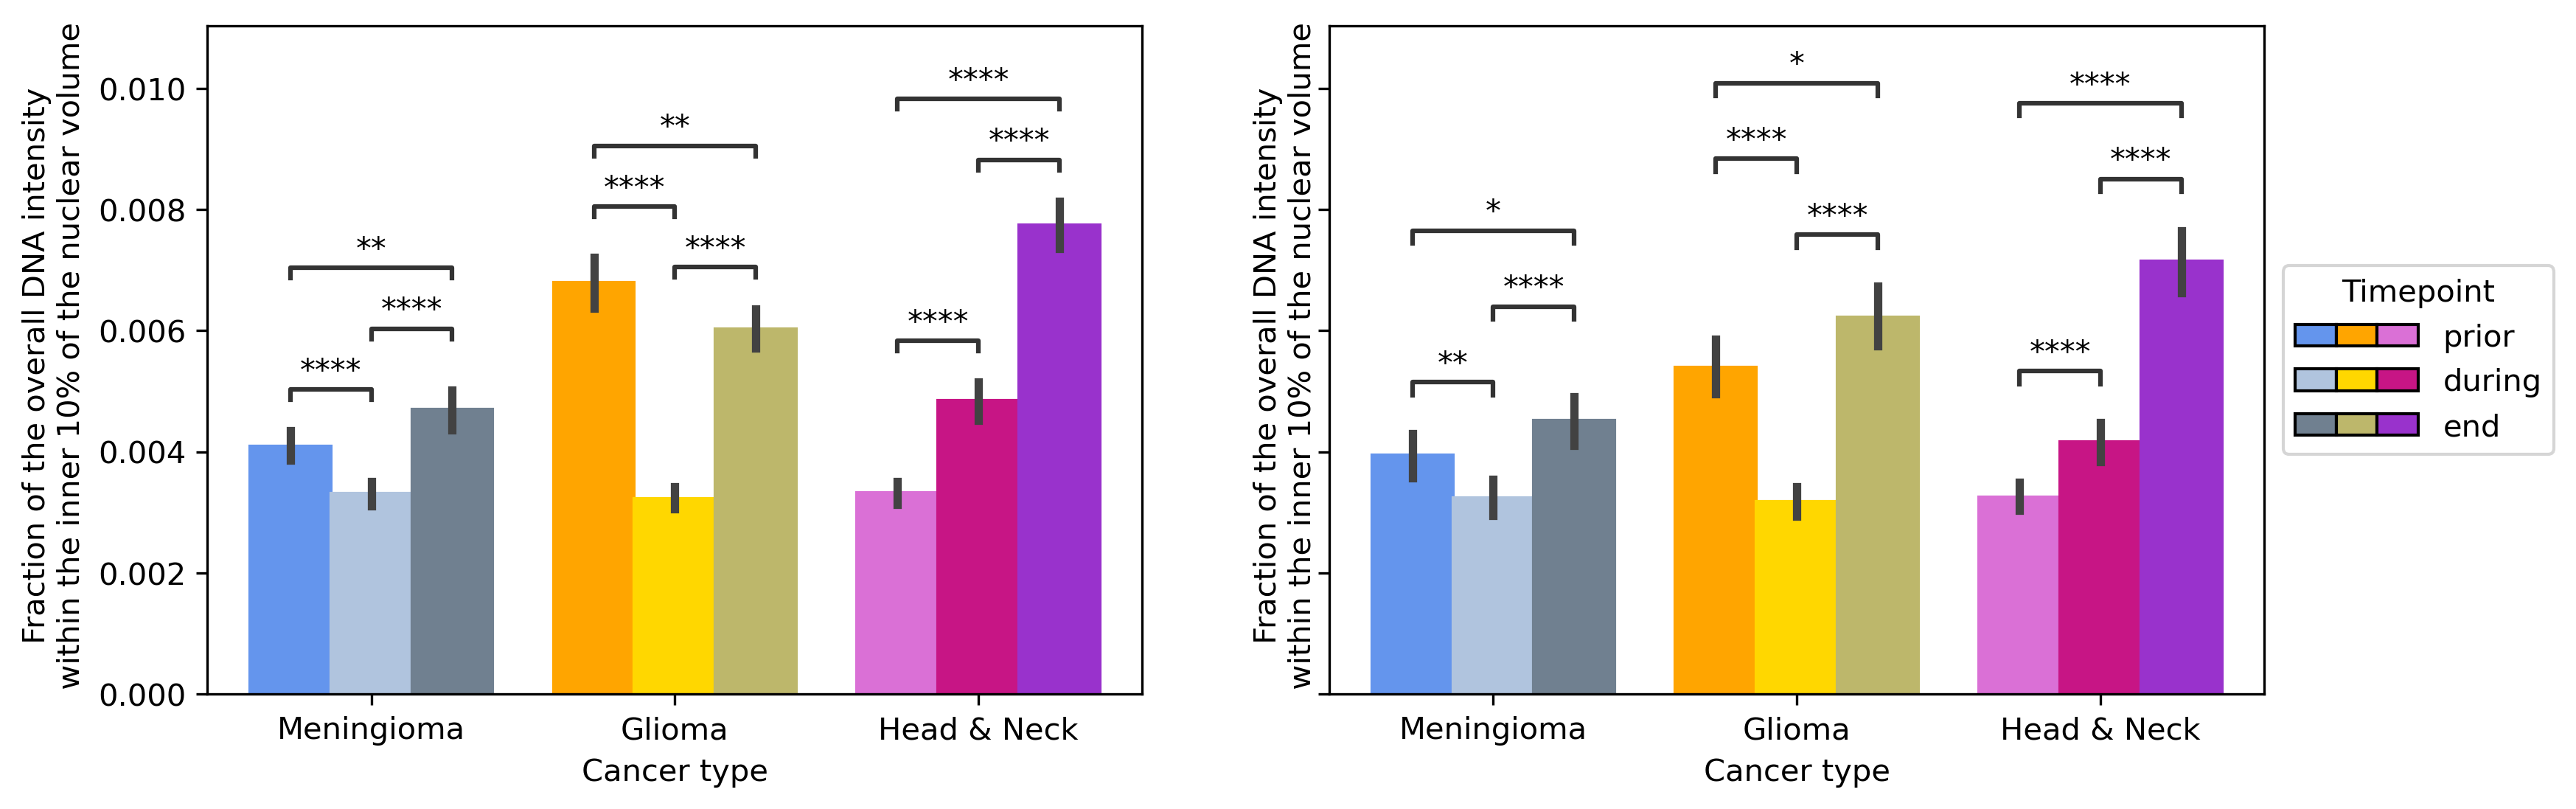

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.137e-90 t=2.082e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:9.466e-18 t=8.641e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.625e-51 t=1.542e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.228e-36 t=-1.273e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.339e-27 t=1.098e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.451e-142 t=-2.689e+01
Head & Neck_prior vs. Head & Neck_end: t-test in

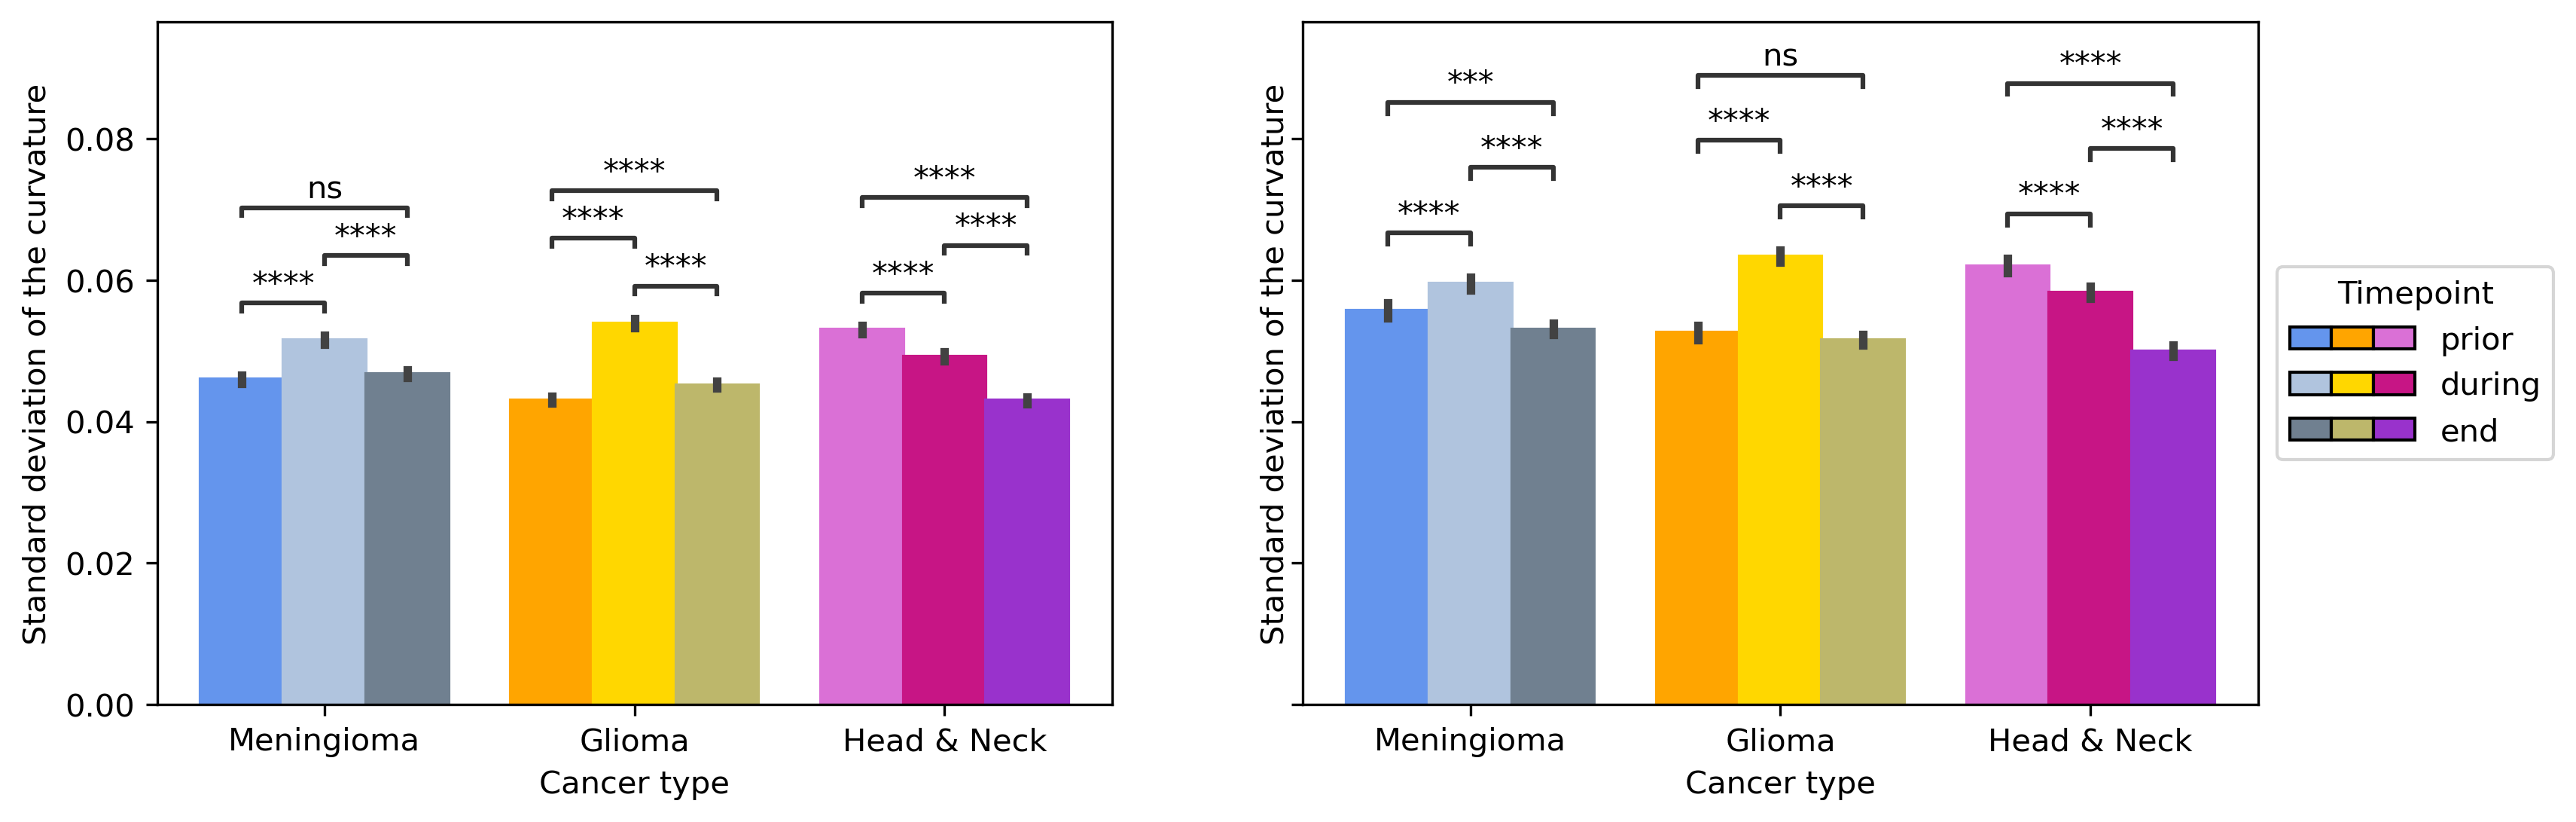

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.158e-64 t=-1.733e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.875e-01 t=1.415e-01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.122e-18 t=-8.735e+00
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.629e-45 t=-1.439e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.085e-09 t=5.905e+00
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.515e-32 t=1.189e+01
Head & Neck_prior vs. Head & Neck_end: t-test in

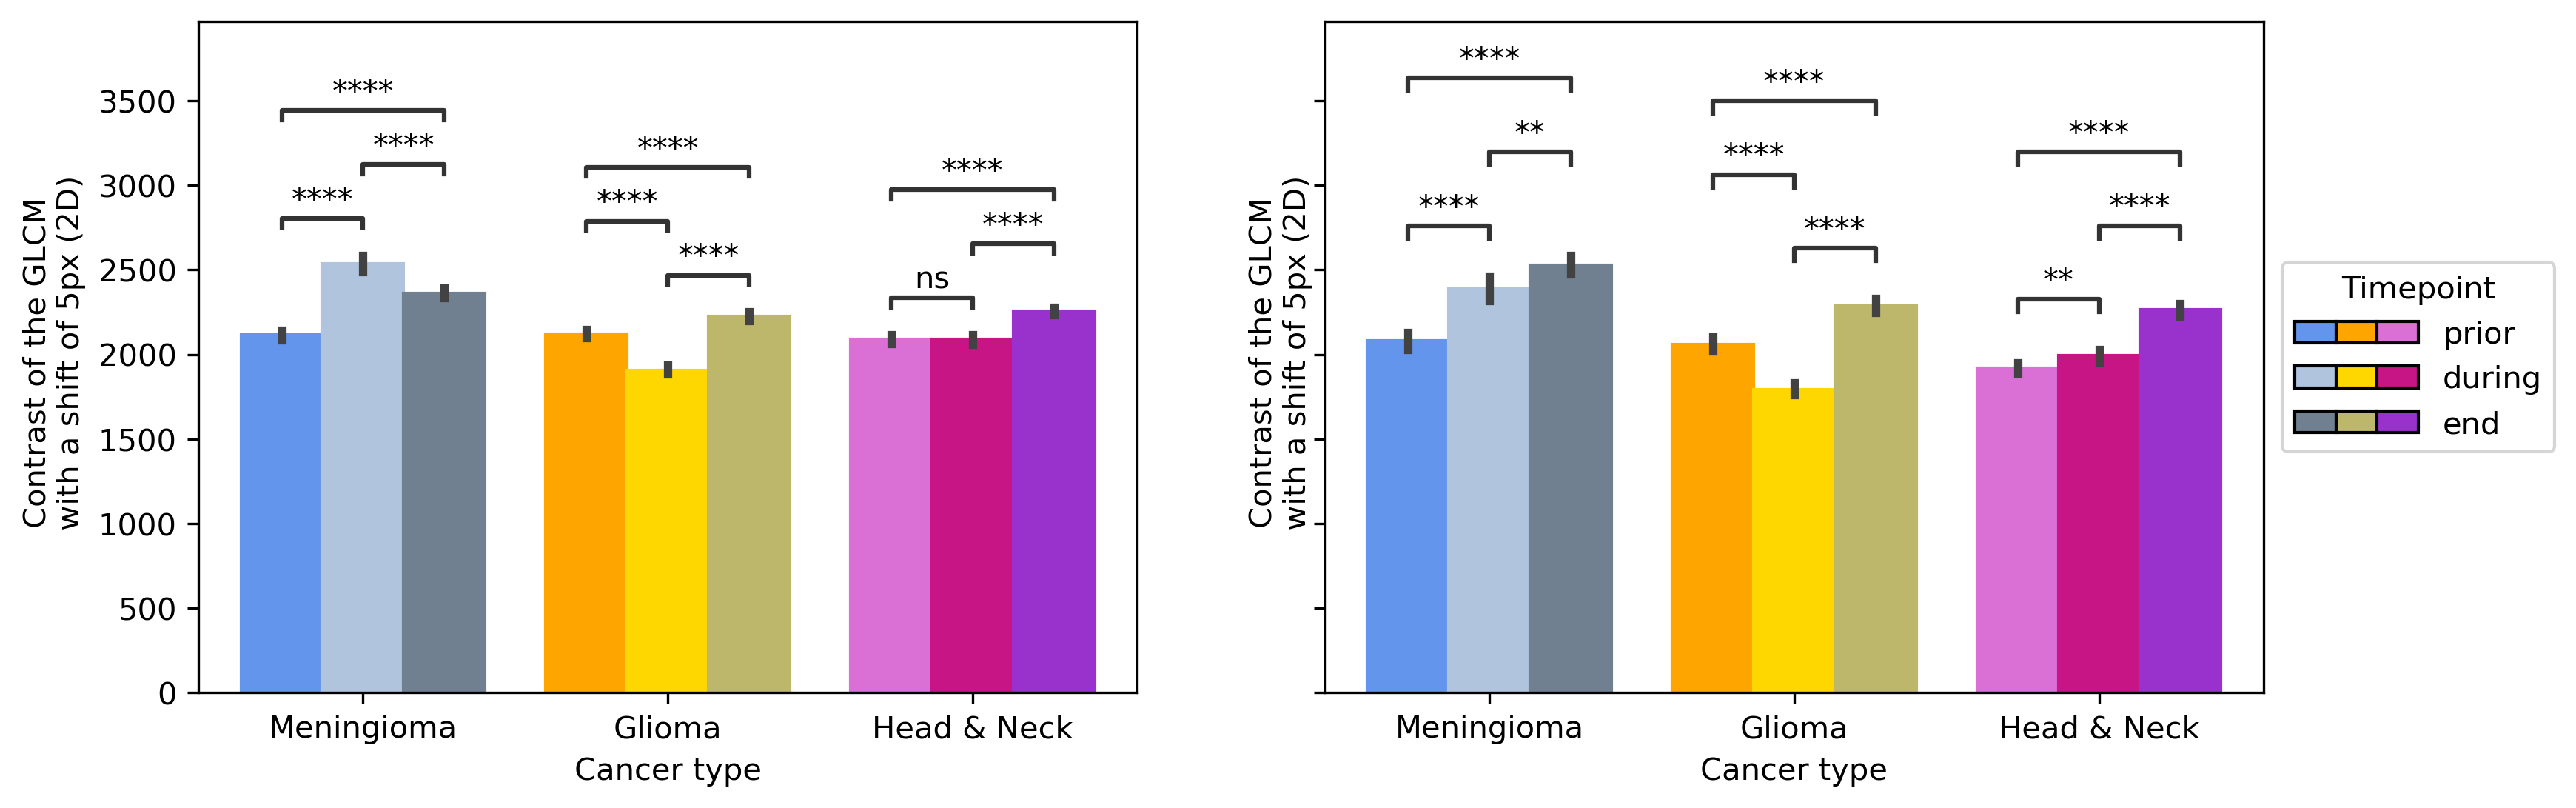

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.149e-163 t=-2.907e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.458e-14 t=-7.735e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.989e-87 t=-2.047e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.484e-06 t=4.827e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.530e-40 t=-1.354e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.496e-167 t=2.945e+01
Head & Neck_prior vs. Head & Neck_end: t-test

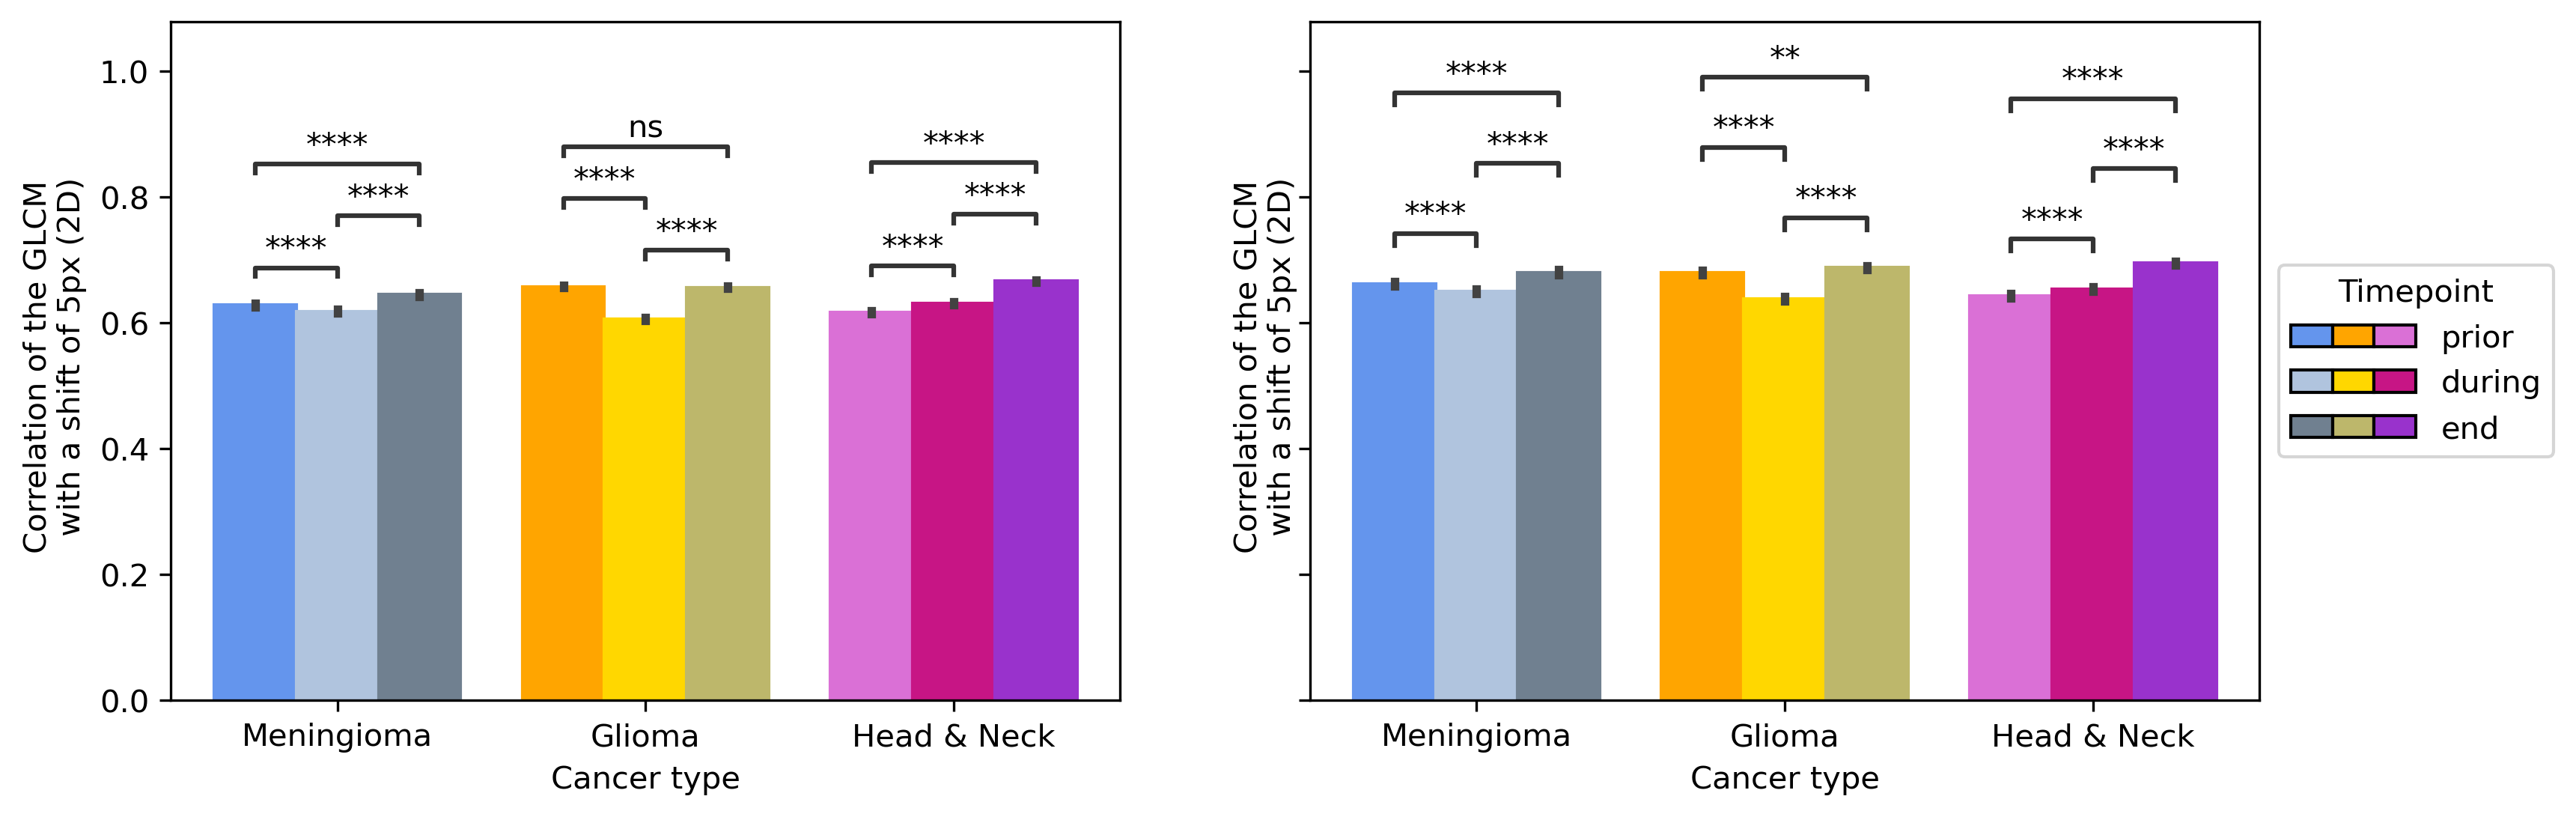

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=6.681e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.996e-58 t=1.645e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.521e-209 t=3.370e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.537e-22 t=-9.743e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.273e-211 t=3.477e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.682e+01
Head & Neck_prior vs. Head & Neck_end: t-test i

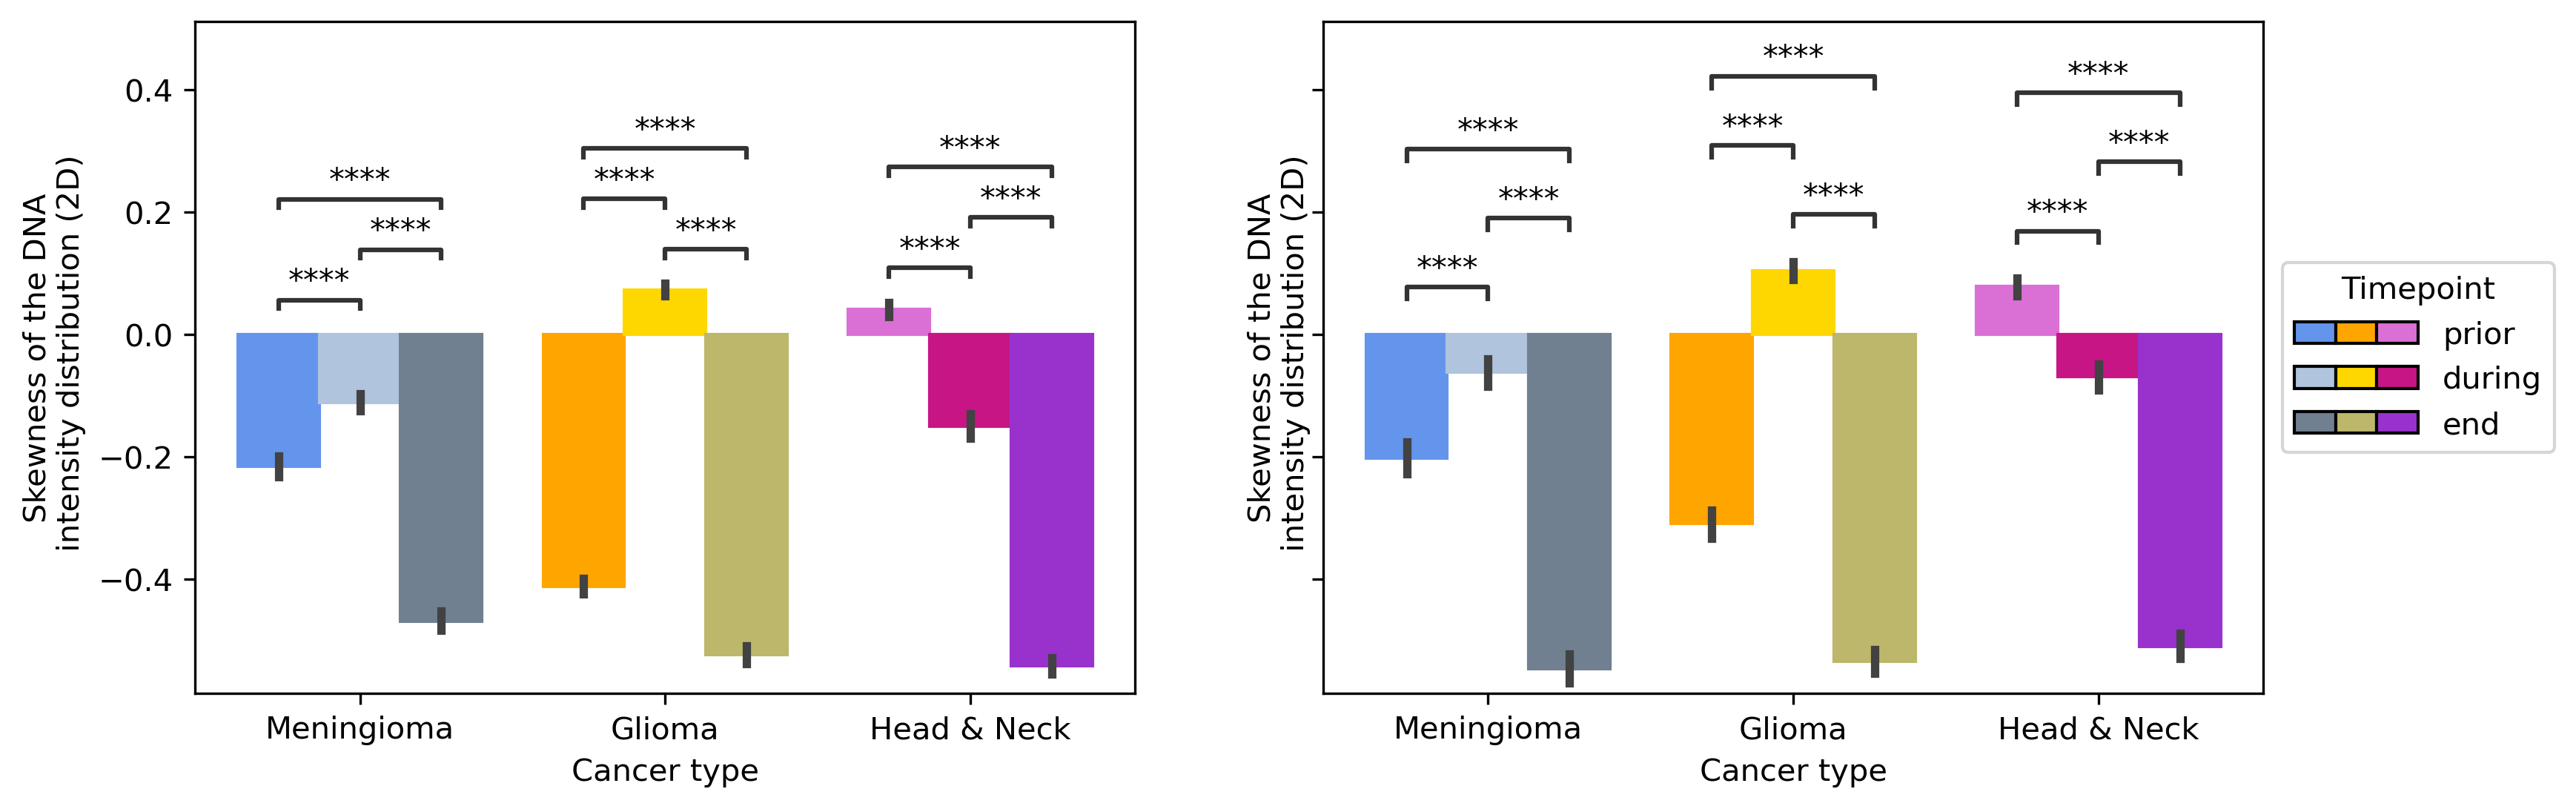

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.472e-215 t=-3.413e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.890e-58 t=-1.650e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.874e-84 t=-2.016e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.289e-92 t=2.138e+01
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.257e-171 t=-3.060e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:9.375e-230 t=3.556e+01
Head & Neck_prior vs. Head & Neck_end: t-tes

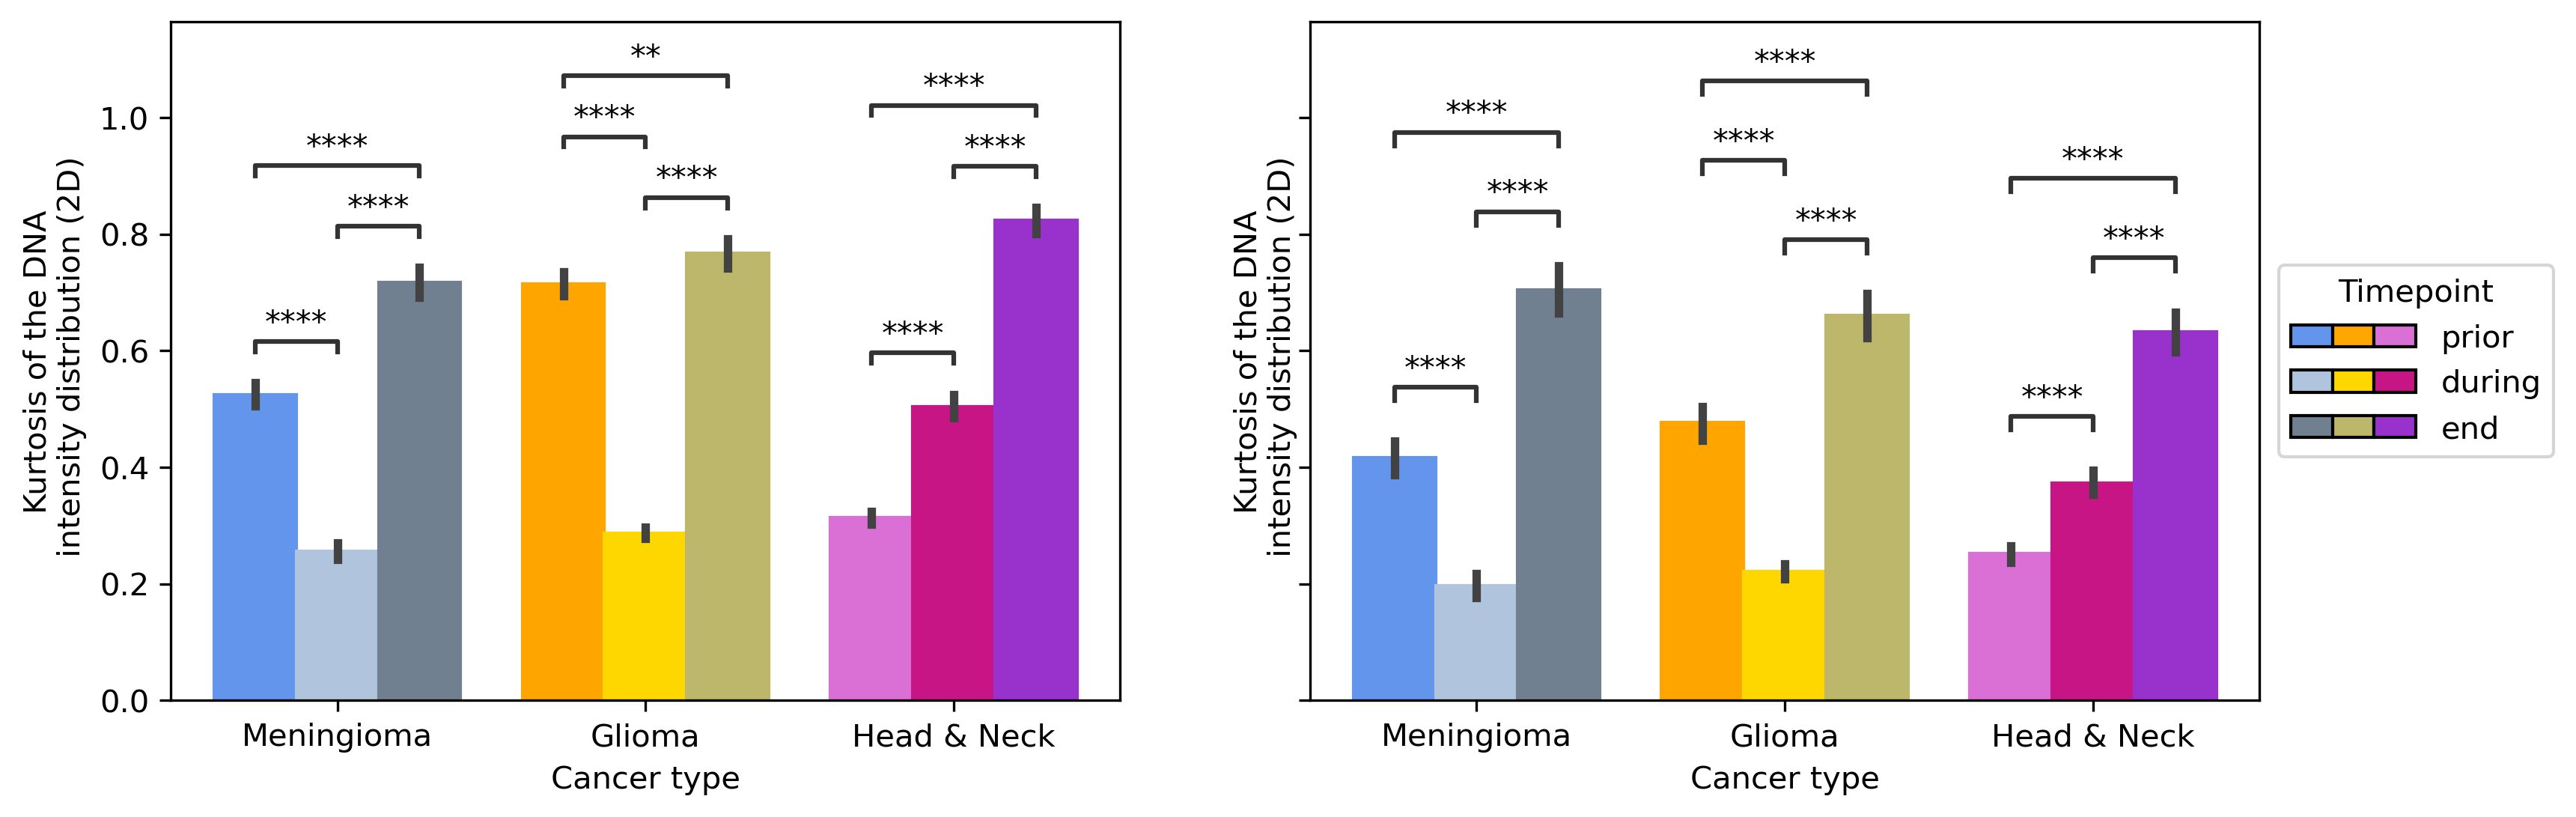

<IPython.core.display.Javascript object>

In [37]:
markers = [
    "nuclear_volume",
    "hc_ec_ratio_3d",
    "rdp_1",
    "std_curvature",
    "contrast_5",
    "correlation_5",
    "skewness",
    "kurtosis",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "relative HC/EC ratio",
    "Fraction of the overall DNA intensity \n within the inner 10% of the nuclear volume",
    "Standard deviation of the curvature",
    "Contrast of the GLCM \n with a shift of 5px (2D)",
    "Correlation of the GLCM \n with a shift of 5px (2D)",
    "Skewness of the DNA\n intensity distribution (2D)",
    "Kurtosis of the DNA\n intensity distribution (2D)",
]
plot_timepoint_cancer_celltype_markers_dist(
    data,
    markers,
    marker_labels,
    celltypes=["CD3+", "CD3-"],
    cut=0,
    palette=color_palette,
    figsize=[12, 4],
    plot_type="bar",
)

---

### 3d. Proteomic differences of PBMCs in cancer

Finally, we also assess the proteomic differences between the different treatment timepoint populations. To this end, we plot the relative Lamin and gH2AX expression measured by the sum of the intensities of the corresponding imaging channels normalized by the nuclear volume. Additionally, we plot the number of identified gH2AX foci which are computed as the local maxima peaks found in the corresponding channel images.

Note that those features are only available for the first data set that was stained for those proteins.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.266e-41 t=-1.359e+01
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.295e-15 t=-7.808e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.372e-94 t=-2.145e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.030e-22 t=-9.849e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.763e-01 t=8.849e-01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.155e-01 t=1.004e+00
Head & Neck_prior vs. Head & Neck_end: t-test i

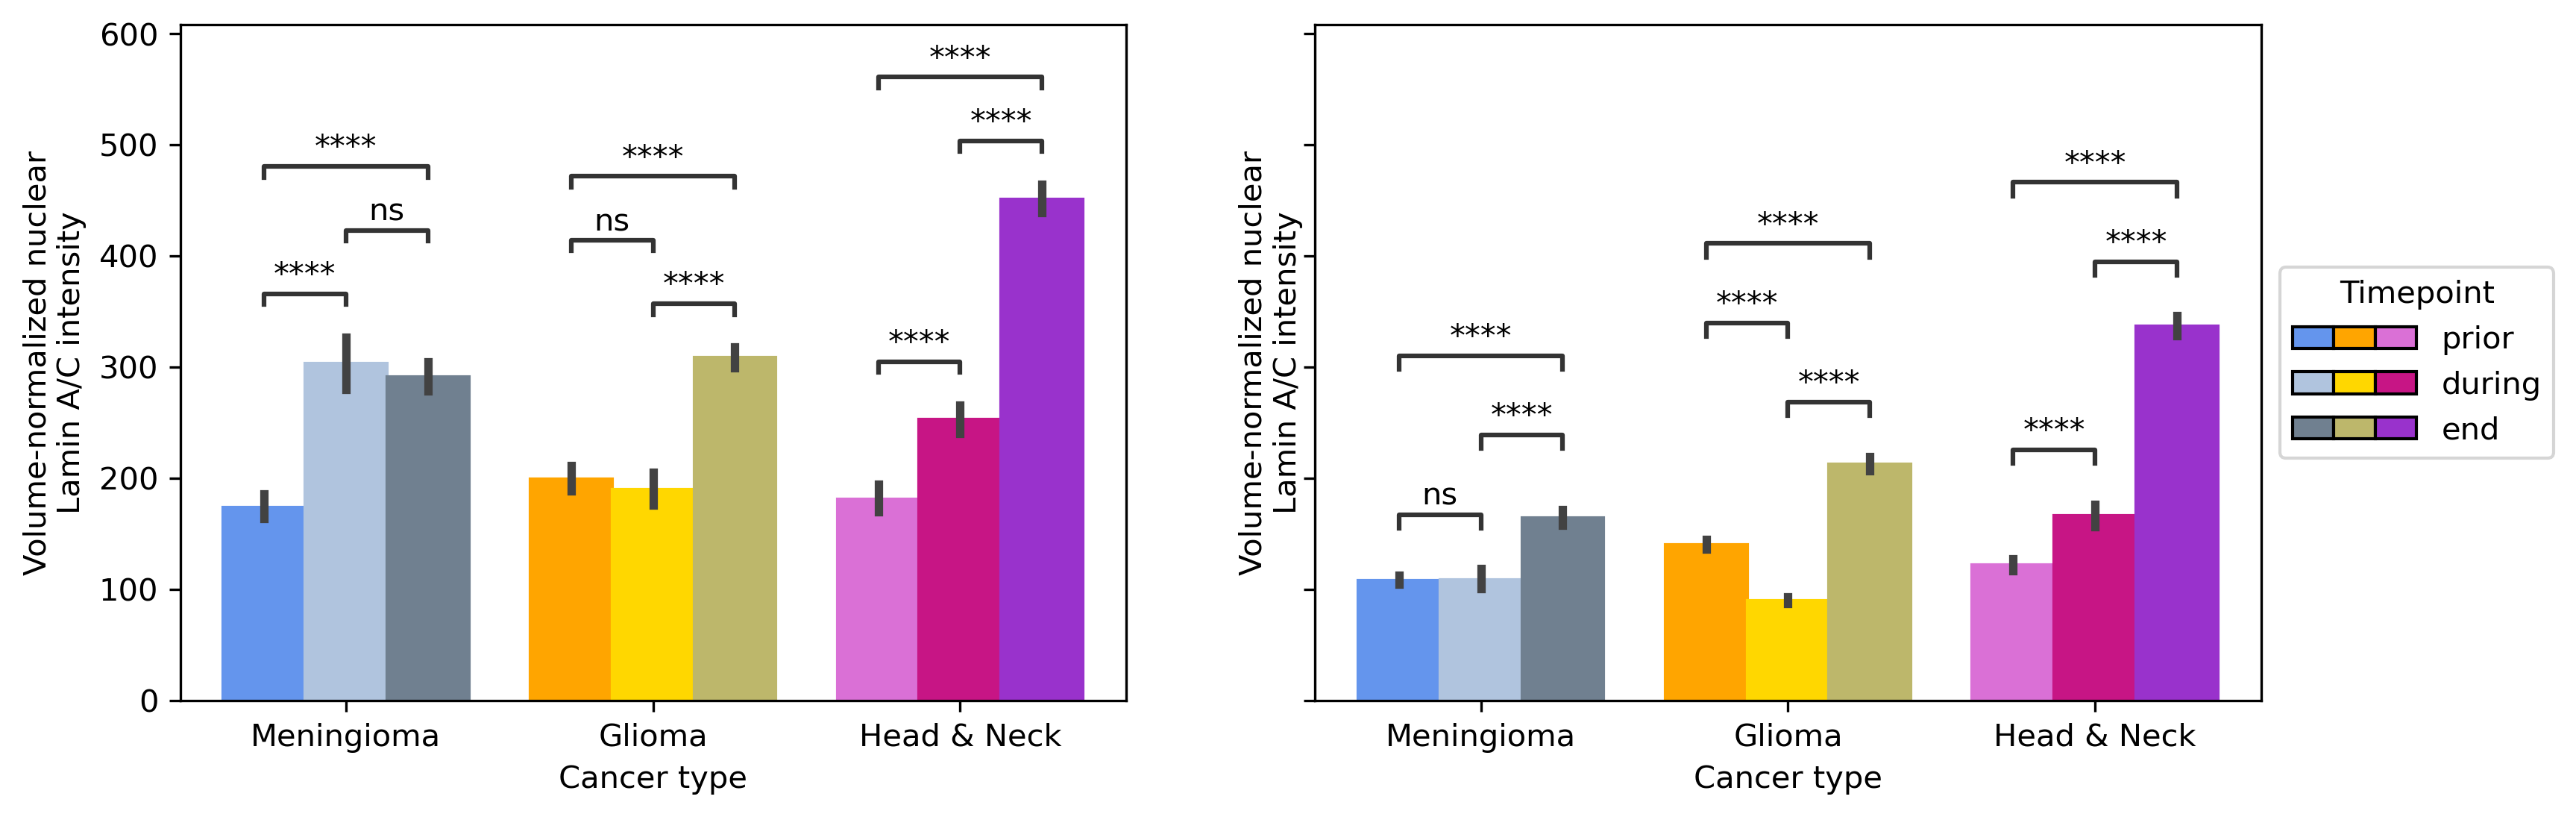

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.185e+02
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.094e-79 t=-1.953e+01
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.482e-280 t=-4.028e+01
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:8.702e-22 t=-9.695e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.978e+01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.886e-94 t=2.135e+01
Head & Neck_prior vs. Head & Neck_end: t-test

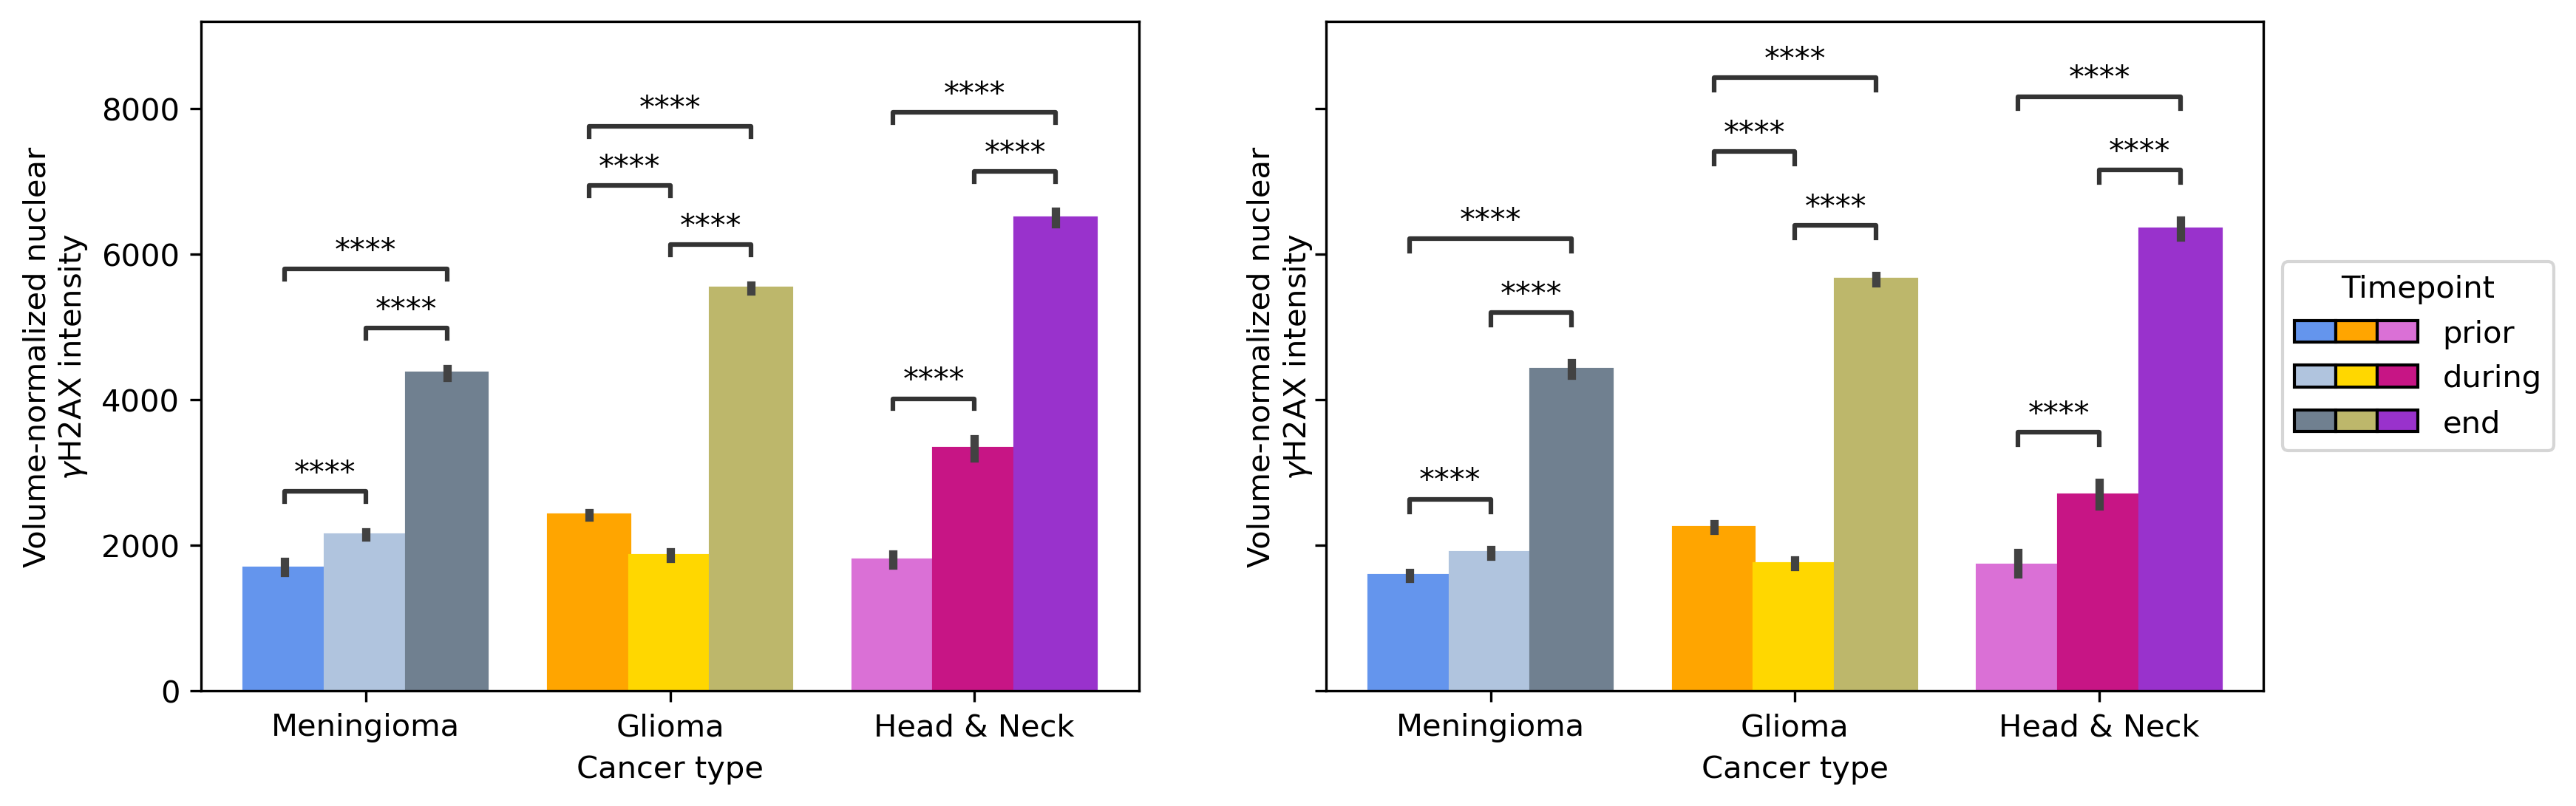

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.323e-07 t=5.026e+00
Head & Neck_prior vs. Head & Neck_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.684e-20 t=-9.358e+00
Head & Neck_during vs. Head & Neck_end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.539e-02 t=-2.237e+00
Meningioma_prior vs. Meningioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.401e-03 t=2.932e+00
Meningioma_during vs. Meningioma_end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.599e-01 t=7.391e-01
Glioma_prior vs. Glioma_during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.306e-01 t=1.512e+00
Head & Neck_prior vs. Head & Neck_end: t-test ind

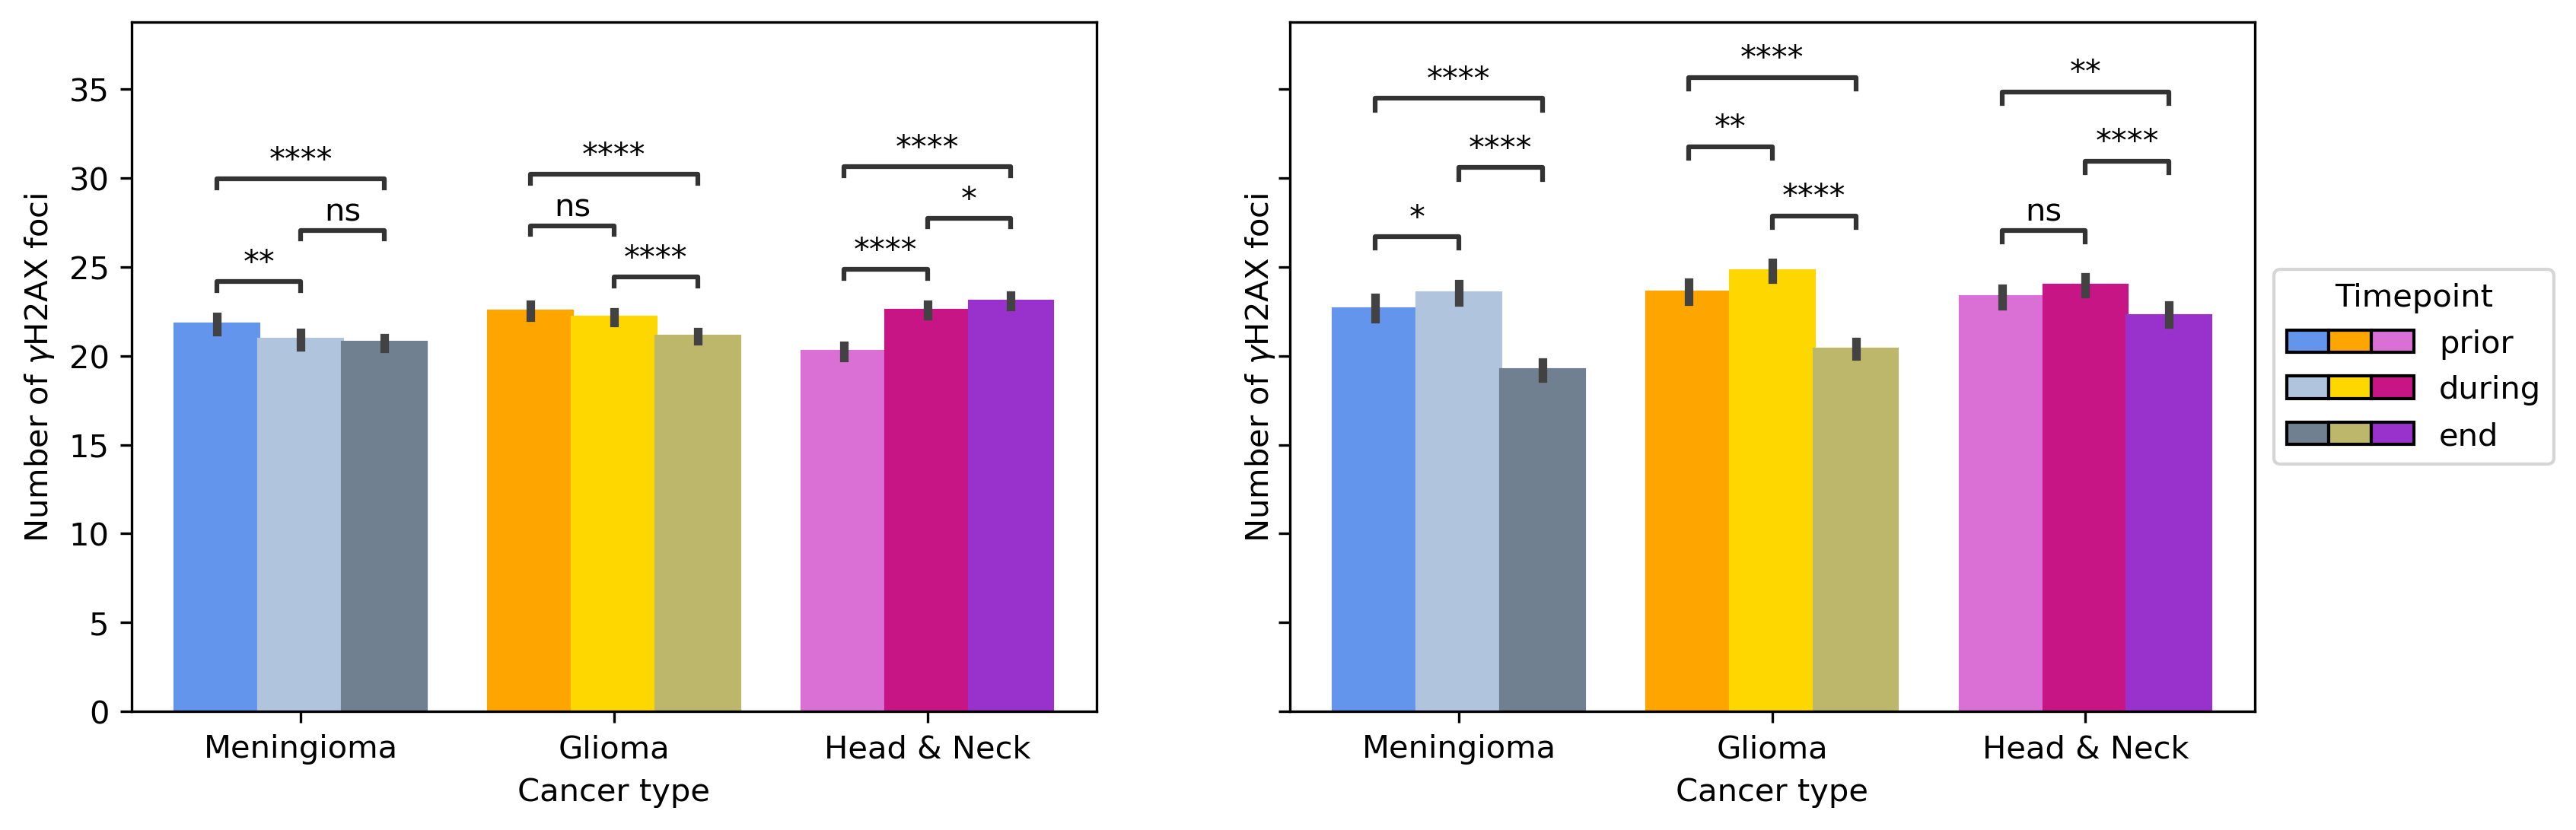

<IPython.core.display.Javascript object>

In [38]:
markers = ["rel_lamin_3d_int", "rel_gh2ax_3d_int", "gh2ax_foci_count"]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Volume-normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
]
plot_timepoint_cancer_celltype_markers_dist(
    data,
    markers,
    marker_labels,
    celltypes=["CD3+", "CD3-"],
    cut=0,
    palette=color_palette,
    figsize=[12, 4],
    plot_type="bar",
)

---

## 4. Supplemental